# <span style='font-family:"Times New Roman"'> <span styel=''>**CANCER SPECIFIC ANALYSIS**
*Emile Cohen*
    
 *April 2020*

**Goal:** In this notebook, we want to explore all the metrics for one specific cancer. The cancer_type will be a parameter of this notebook.

The notebook is composed of 3 parts:
   * **General Information**
   * **Genomic Information**
   * **Clinical Information**
---

In [14]:
%run -i '../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from cancer_utils import *
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec

data_path = '../../../data/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

In [2]:
# The following function allows to filter the non_WGD cohort, the 1_WT subgroup
def non_wgd_load_and_cut(path):
    master_no_wgd = pd.read_pickle(path)
    master_cutoff = master_no_wgd
    master_cutoff.drop(master_cutoff[master_cutoff['tp53_group'] == '1_WILD_TYPE'][master_cutoff['purity'] <= 0.3][master_cutoff['tp53_vaf_1'] <= 0.15].index , inplace=True)
    master_cutoff.drop(master_cutoff[master_cutoff['tp53_group']=='1_WILD_TYPE'][master_cutoff['tp53_cn_state']=='DIPLOID'][master_cutoff['tp53_vaf_1']>0.6].index, inplace=True)
    master_cutoff.drop(master_cutoff[master_cutoff['tp53_group']=='1_WILD_TYPE'][master_cutoff['tp53_res_1']<0.5].index, inplace=True)

    return master_cutoff

# Parameter Settings

Change the following parameter to 'wgd' or 'no_wgd'

In [3]:
cohort_type = 'no_wgd'

In [4]:
cancer_type = 'Breast Cancer'
mc = list(islice(cycle(list(sns.color_palette("muted"))), None, 6))
palette ={'>=1_LOSS':mc[0], 'HOMDEL':mc[1], '1_WILD_TYPE':mc[2], '>1muts':mc[3], '>=1_cnLOH':mc[4], '0_HETLOSS':mc[5]}
palette_list = [mc[5],mc[2],mc[3],mc[4],mc[0],mc[1]]
group_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '>=1_LOSS','HOMDEL']
if cohort_type == 'no_wgd':
    master = non_wgd_load_and_cut(data_path + 'impact-facets-tp53/processed/no_wgd/master_no_wgd.pkl')
# We remove INDETERMINATE and NaN tp53_cn_state samples
master_cancer = master[master['Cancer_Type'] == cancer_type][master['tp53_cn_state'] != 'INDETERMINATE'][~master['tp53_cn_state'].isna()]

In [5]:
master.shape[0]

15515

In [6]:
master_cancer.shape[0]

2323

# General

In [7]:
print_md('**' + cancer_type + '**')
print_md('* Number of samples: {}'.format(len(master_cancer)))
print_md('* Proportion in the entire cohort: {} %'.format(round(100*float(len(master_cancer))/float(len(master)),2)))

**Breast Cancer**

* Number of samples: 2323

* Proportion in the entire cohort: 14.97 %

In [8]:
print(master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] == 'DIPLOID'].shape[0])
print(master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] != 'DIPLOID'].shape[0])
print(master_cancer[master_cancer['tp53_count'] ==0][master_cancer['tp53_cn_state'] != 'DIPLOID'].shape[0])

28
570
856


In [9]:
master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] == 'DIPLOID'].shape[0]

28

In [10]:
master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] != 'DIPLOID'].shape[0]

570

In [11]:
master_cancer[master_cancer['tp53_count'] == 0][(master_cancer['tp53_cn_state'] == 'HOMDEL')| (master_cancer['tp53_cn_state'] == 'HETLOSS')]

Sample_Id           Tumor_Id Patient_Id  \
13     P-0018520-T01-IM6_P-0018520-N01-IM6  P-0018520-T01-IM6  P-0018520   
47     P-0016335-T01-IM6_P-0016335-N01-IM6  P-0016335-T01-IM6  P-0016335   
48     P-0016335-T02-IM6_P-0016335-N01-IM6  P-0016335-T02-IM6  P-0016335   
80     P-0016888-T01-IM6_P-0016888-N01-IM6  P-0016888-T01-IM6  P-0016888   
86     P-0002705-T01-IM3_P-0002705-N01-IM3  P-0002705-T01-IM3  P-0002705   
...                                    ...                ...        ...   
15887  P-0049733-T01-IM6_P-0049733-N01-IM6  P-0049733-T01-IM6  P-0049733   
15896  P-0033244-T03-IM6_P-0033244-N01-IM6  P-0033244-T03-IM6  P-0033244   
15933  P-0050407-T01-IM6_P-0050407-N01-IM6  P-0050407-T01-IM6  P-0050407   
15964  P-0050494-T01-IM6_P-0050494-N01-IM6  P-0050494-T01-IM6  P-0050494   
15969  P-0050528-T01-IM6_P-0050528-N01-IM6  P-0050528-T01-IM6  P-0050528   

         Cancer_Type               Cancer_Type_Detailed  Patient_Current_Age  \
13     Breast Cancer   Breast Invasive Ductal Carcinoma                 72.0   
47     Breast Cancer  Breast Invasive Lobular Carcinoma                 49.0   
48     Breast Cancer  Breast Invasive Lobular Carcinoma                 49.0   
80     Breast Cancer   Breast Invasive Ductal Carcinoma                 55.0   
86     Breast Cancer   Breast Invasive Ductal Carcinoma                 51.0   
...              ...                                ...                  ...   
15887  Breast Cancer  Breast Invasive Lobular Carcinoma                 58.0   
15896  Breast Cancer   Breast Invasive Ductal Carcinoma                 76.0   
15933  Breast Cancer          Invasive Breast Carcinoma                 44.0   
15964  Breast Cancer          Invasive Breast Carcinoma                 77.0   
15969  Breast Cancer   Breast Invasive Ductal Carcinoma                 39.0   

          Sex Sample_Type    purity    ploidy  Overall_Survival_Months  \
13     Female     Primary  0.651383  1.947238                   35.079   
47     Female     Primary  0.403738  2.074002                   36.230   
48     Female     Primary  0.358320  2.137882                   36.230   
80     Female  Metastasis  0.540401  1.983831                   37.611   
86     Female     Primary  0.590420  1.833206                    2.170   
...       ...         ...       ...       ...                      ...   
15887  Female     Primary  0.314995  2.232024                    2.762   
15896  Female  Metastasis  0.331471  1.932905                   18.181   
15933  Female  Metastasis  0.527806  2.029728                    1.841   
15964  Female     Primary  0.262102  2.255531                    2.170   
15969  Female     Primary  0.268962  2.195965                    1.940   

      Overall_Survival_Status  MSI_Score       MSI_Type  TMB_Score tp53_key_1  \
13                     LIVING       0.15  Do not report        2.6       None   
47                     LIVING       0.08  Do not report        2.6       None   
48                     LIVING       0.00  Do not report        1.8       None   
80                     LIVING       0.37  Do not report        2.6       None   
86                   DECEASED       0.73         Stable        1.1       None   
...                       ...        ...            ...        ...        ...   
15887                  LIVING       0.07         Stable        3.5       None   
15896                  LIVING       0.05         Stable        0.9       None   
15933                  LIVING       0.21         Stable        0.9       None   
15964                  LIVING       0.05         Stable        4.4       None   
15969                  LIVING       0.00         Stable        5.3       None   

      tp53_vc_1  tp53_ccf_1  tp53_vaf_1 tp53_HGVSp_1 tp53_spot_1 tp53_vt_1  \
13         None         NaN         NaN         None        None      None   
47         None         NaN         NaN         None        None      None   
48         None         NaN         NaN         None        Non

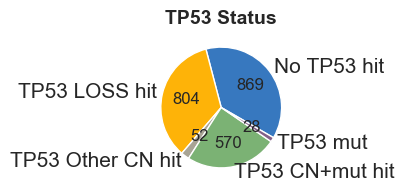

In [12]:
fig = plt.figure(figsize=(4,2))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)

sizes = [master_cancer.shape[0] - master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] == 'DIPLOID'].shape[0] - master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] != 'DIPLOID'].shape[0] - master_cancer[master_cancer['tp53_count'] ==0][master_cancer['tp53_cn_state'] != 'DIPLOID'].shape[0], 
        master_cancer[master_cancer['tp53_count'] == 0][(master_cancer['tp53_cn_state'] == 'HOMDEL')| (master_cancer['tp53_cn_state'] == 'HETLOSS')].shape[0],
        master_cancer[master_cancer['tp53_count'] ==0][master_cancer['tp53_cn_state'] != 'DIPLOID'][~((master_cancer['tp53_cn_state'] == 'HOMDEL')| (master_cancer['tp53_cn_state'] == 'HETLOSS'))].shape[0],
        master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] != 'DIPLOID'].shape[0],
        master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] == 'DIPLOID'].shape[0]  
        ]

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
total = sum(sizes)

labels = ['No TP53 hit', 'TP53 LOSS hit','TP53 Other CN hit', 'TP53 CN+mut hit',  'TP53 mut']
wedges, plt_labels, junk = ax.pie(sizes, labels=labels, startangle=330, colors=sns.xkcd_palette(colors), autopct=lambda p: '{:.0f}'.format(p * total / 100), textprops={'fontsize': 15})
junk = [ _.set_fontsize(12) for _ in junk]
ax.set_title('TP53 Status', weight='bold', fontsize=14)
plt.show()
plt.show(fig)

In [17]:
get_groupby(master_cancer[master_cancer['tp53_count'] ==0][master_cancer['tp53_cn_state'] != 'DIPLOID'][~((master_cancer['tp53_cn_state'] == 'HOMDEL')| (master_cancer['tp53_cn_state'] == 'HETLOSS'))], 'tp53_cn_state', 'count').sort_values(by='count', ascending=False)

count
tp53_cn_state       
GAIN              32
CNLOH             23
CNLOH & GAIN       5
TETRAPLOID         1

In [53]:
master_cancer[master_cancer['tp53_count'] >=1].shape[0]

512

## Sample Type proportion

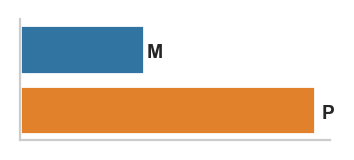

In [18]:
sns.set_style("whitegrid", {'grid.color': '1.'})
fig = plt.figure(figsize=(2,0.8))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
g = sns.countplot(data=master_cancer, y='Sample_Type', ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
g.set(xticklabels=[])
g.set(yticklabels=[])

rects = ax.patches
labels = ['M', 'P']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    width = rect.get_width()
    ax.text(width*(102/100) , rect.get_y()+(3/4)*height,  str(label),
        ha='left', va='bottom', weight='bold', fontsize=7) 


count_Sample_Type
Sample_Type                   
Primary                   1466
Metastasis                 614

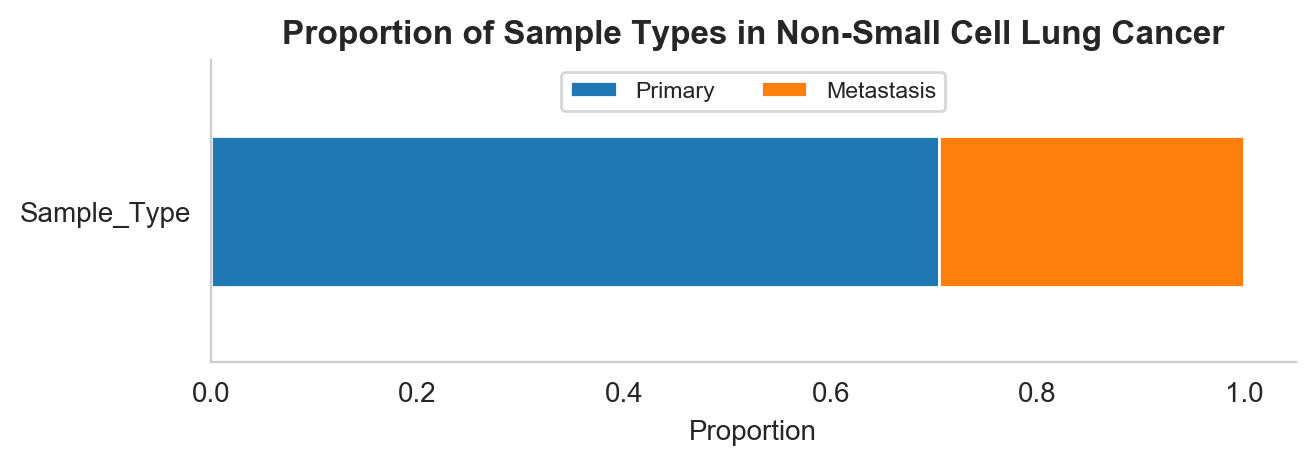

In [19]:
fig, ax = proportion_plot(master_cancer, 
                metrics='Sample_Type',
                title= 'Proportion of Sample Types in ' + cancer_type,
                figsize=(7,2),
                display_table=True, 
                ncol_legend =2)

## TP53 Mutants

**Non-Small Cell Lung Cancer**

* Number of TP53 muted samples: 757 

* Proportion of TP53 muted samples: 36.39 %

count_tp53_count
tp53_count                  
0                       1323
1                        691
2                         61
3                          5

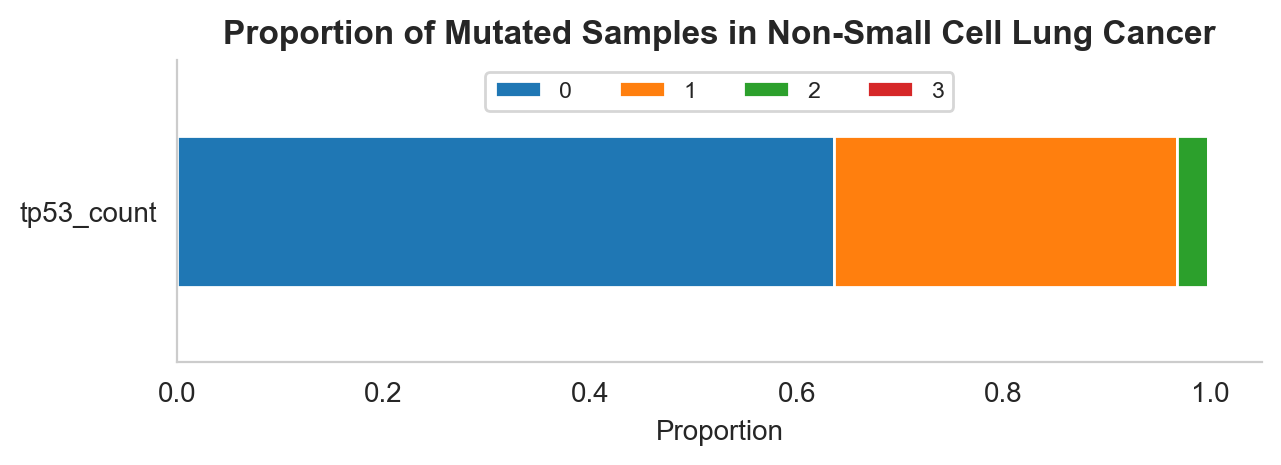

In [20]:
print_md('**' + cancer_type + '**')
print_md('* Number of TP53 muted samples: {} '.format(len(master_cancer[master_cancer['tp53_count']>=1])))
print_md('* Proportion of TP53 muted samples: {} %'.format(round(100*float(len(master_cancer[master_cancer['tp53_count']>=1]))/float(len(master_cancer)),2)))

fig, ax = proportion_plot(master_cancer, 
                metrics='tp53_count',
                title= 'Proportion of Mutated Samples in ' + cancer_type,
                figsize=(7,2),
                display_table=True, 
                ncol_legend =6)

prim_count  met_count     sum
tp53_count                               
0                 1219      640.0  1859.0
1                  946      809.0  1755.0
2                   87       49.0   136.0
3                    6        3.0     9.0
4                    1        NaN     NaN

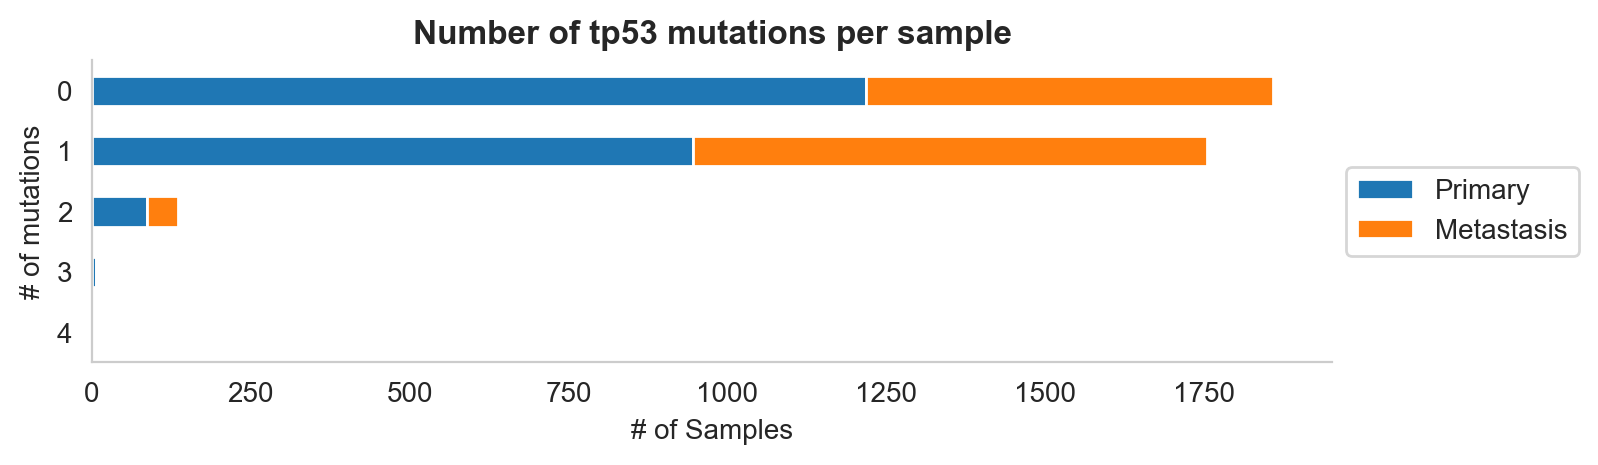

In [33]:
master_tp53 = master_cancer[master_cancer['tp53_count'] >= 0]
# We filter out the duplicates and keep only the Primary Samples
master_tp53_prim = master_tp53[master_tp53['Sample_Type'] == 'Primary']
master_tp53_met = master_tp53[master_tp53['Sample_Type'] == 'Metastasis']

# Counting
count_0hetloss = get_groupby(master_tp53_prim, 'tp53_count', 'prim_count')
count_met = get_groupby(master_tp53_met, 'tp53_count', 'met_count')

#We rename the column
count = pd.concat([count_prim, count_met],
                  axis=1).sort_values(by=['prim_count'])
count['sum'] = count.apply(lambda x: x.prim_count + x.met_count, axis=1)
count_ = count.sort_values(by='sum', ascending=False)
len(master_cancer)
print()
display(count_)

ax, fig = get_mstacked_plot(count[['prim_count', 'met_count']],
                            'Number of tp53 mutations per sample',
                            ['Primary', 'Metastasis'],
                            '# of Samples',
                            '# of mutations',
                            figsize=(10, 2))

0_HETLOSS_count  >=1_cnLOH_count  >=1_LOSS_count  >1muts_count  \
0 | P             399.0              0.0             0.0           0.0   
0 | M             385.0              0.0             0.0           0.0   
1 | P               0.0             36.0           226.0           0.0   
1 | M               0.0             28.0           255.0           0.0   
2 | P               0.0              0.0             7.0           4.0   
2 | M               0.0              0.0             6.0           0.0   
>2 | M              0.0              0.0             1.0           1.0   
>2 | P              0.0              0.0             1.0           0.0   

        1_WILD_TYPE_count  HOMDEL_count  
0 | P                 0.0           9.0  
0 | M                 0.0          11.0  
1 | P                19.0           1.0  
1 | M                 4.0           1.0  
2 | P                 0.0           1.0  
2 | M                 0.0           1.0  
>2 | M                0.0           0.0  
>2 | P                0.0           0.0

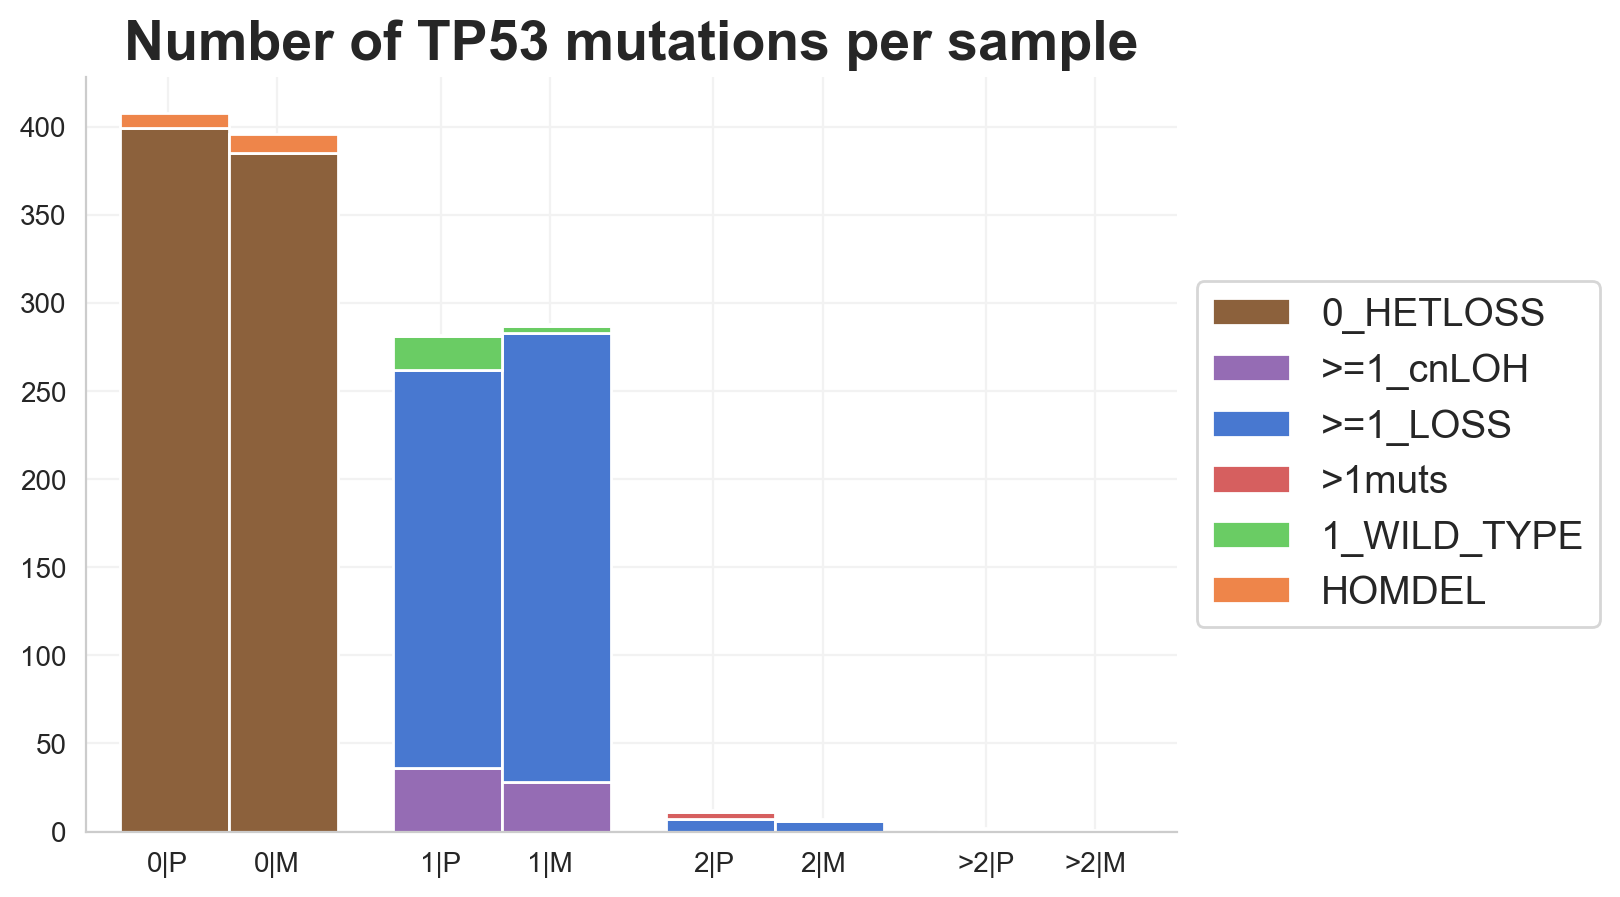

In [16]:
groups = ['0_HETLOSS', '>=1_cnLOH', '>=1_LOSS', '>1muts', '1_WILD_TYPE','HOMDEL']

for i,group in enumerate(groups):
    master_group = master_cancer[master_cancer['tp53_group'] == group]#[master_cancer['tp53_count']<4]
    groupby_prim = get_groupby(master_group[master_group['Sample_Type'] == 'Primary'], 'tp53_count', group + '_count')
    groupby_met = get_groupby(master_group[master_group['Sample_Type'] == 'Metastasis'], 'tp53_count', group + '_count')
    if i == 0 : met = groupby_met ; prim = groupby_prim
    else: met = pd.concat([met, groupby_met], axis=1) ; prim = pd.concat([prim, groupby_prim], axis=1)
for i in [0,1,2,3,4,5]:
    if i not in met.index: met.loc[i]=[0]*6
    if i not in prim.index: prim.loc[i]=[0]*6   
met = met.fillna(0) ; prim = prim.fillna(0)
met.index = ['0 | M', '1 | M', '2 | M', '3 | M', '4 | M', '5 | M'] ; prim.index = ['0 | P', '1 | P', '2 | P', '3 | P', '4 | P', '5 | P']
count = pd.concat([met, prim], axis=0)
#count['sum'] = count.sum(axis=1)
count= count.fillna(0)
count = count.reindex(['0 | P', '0 | M','1 | P','1 | M','2 | P','2 | M','3 | P','3 | M', '4 | P', '4 | M', '5 | P', '5 | M'])
count.loc['>2 | M'] = count.apply(lambda x: x['3 | M'] + x['4 | M'] + x['5 | M'], axis=0)
count.loc['>2 | P'] = count.apply(lambda x: x['3 | P'] + x['4 | P'] + x['5 | P'], axis=0)
count = count.drop(['3 | P','3 | M', '4 | P', '4 | M', '5 | P', '5 | M'])

display(count)

fig = plt.figure(figsize=(11,5))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
h = count.plot(kind = 'bar', stacked=True, ax=ax)
h.set_xticklabels(['0|P', '0|M','1|P','1|M','2|P','2|M','>2|P','>2|M'], rotation=0)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.set_title('Number of TP53 mutations per sample',weight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(True)

palette_list_new = [mc[5],mc[4],mc[0],mc[3],mc[2], mc[1]]
for j,container in enumerate(ax.containers):
    for i, child in enumerate(container.get_children()):
        child.set_facecolor(palette_list_new[j])
        if i%2 == 1: child.set_x(child.get_x() - 0.2)
        child.set_width(0.8)
        
ax.set_xticks([0.1, 0.9, 2.1, 2.9, 4.1, 4.9, 6.1, 6.9])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(['0_HETLOSS', '>=1_cnLOH', '>=1_LOSS', '>1muts', '1_WILD_TYPE','HOMDEL'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)



#h[1].set_facecolor('red')
plt.show()

## Subgroup proportion

In [ ]:
def proportion_plot(df:pd.DataFrame, metrics: str,title: str,  figsize=(7,2),display_table=False, tp53_metrics=False, ncol_legend:int =5):
    if tp53_metrics == True:
            data_1 =  pd.DataFrame(df[['Tumor_Id', metrics + '_1']])
            data_1.columns = ['Tumor_Id', metrics]
            data_2 = pd.DataFrame(df[['Tumor_Id', metrics + '_2']])
            data_2.columns = ['Tumor_Id', metrics]
            data_3 = pd.DataFrame(df[['Tumor_Id', metrics + '_3']])
            data_3.columns = ['Tumor_Id', metrics]
            data_4 = pd.DataFrame(df[['Tumor_Id', metrics + '_4']])
            data_4.columns = ['Tumor_Id', metrics]
            data_5 = pd.DataFrame(df[['Tumor_Id', metrics + '_5']])
            data_5.columns = ['Tumor_Id', metrics]
            data_tot = data_1.append(data_2)
            data_tot = data_tot.append(data_3)
            data_tot = data_tot.append(data_4)
            data_tot = data_tot.append(data_5)
    
            df = pd.merge(left=data_tot, right=df[['Tumor_Id','tp53_cn_state', 'tp53_tcn', 'Sample_Type']],how='left', left_on='Tumor_Id',right_on='Tumor_Id')

    count = get_groupby(df, metrics, 'count_' + metrics)
    freq = pd.DataFrame(count['count_' + metrics]).sort_values(by=['count_' + metrics], ascending=False)/ pd.DataFrame(count['count_' + metrics]).sum()
    freq.columns=['%']
    if display_table:
        display(count.sort_values(by = 'count_'+metrics, ascending=False))

    fig, ax = plt.subplots()
    freq.T.plot(kind = 'barh', stacked=True, figsize = figsize, ax=ax, yticks=[])
    plt.title(title, weight = 'bold')
    plt.legend(loc = 'upper center', fontsize='small', ncol=ncol_legend)
    ax.yaxis.set_major_formatter(matplotlib.ticker.IndexFormatter([metrics]))
    ax.set_xlabel('Proportion')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return fig, ax

P         M
tp53_group                     
0_HETLOSS    0.288894  0.352638
1_WILD_TYPE  0.078228  0.046654
>1muts       0.069193  0.037323
>=1_cnLOH    0.100044  0.073037
>=1_LOSS     0.443367  0.475225
HOMDEL       0.020273  0.015122

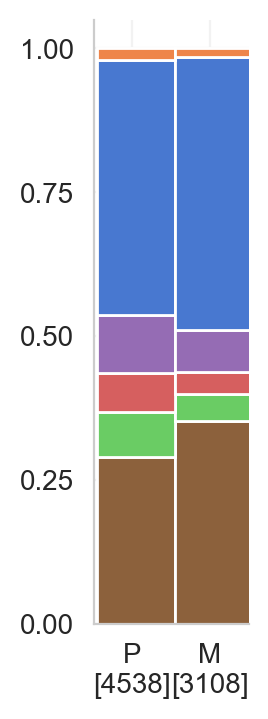

In [64]:
fig, ax = plt.subplots()
metrics='tp53_group'
master_cancer = master
count_prim = get_groupby(master_cancer[master_cancer['Sample_Type'] == 'Primary'], metrics, 'count_prim_' + metrics)
count_met = get_groupby(master_cancer[master_cancer['Sample_Type'] == 'Metastasis'], metrics, 'count_met_' + metrics)
freq_prim = pd.DataFrame(count_prim['count_prim_' + metrics]).sort_values(by=['count_prim_' + metrics], ascending=False)/ pd.DataFrame(count_prim['count_prim_' + metrics]).sum()
freq_met = pd.DataFrame(count_met['count_met_' + metrics]).sort_values(by=['count_met_' + metrics], ascending=False)/ pd.DataFrame(count_met['count_met_' + metrics]).sum()
freq_prim.columns=['P'] ; freq_met.columns=['M']
freq = pd.concat([freq_prim, freq_met], axis=1)
freq = freq.reindex(group_list)
display(freq)

freq.T.plot(kind = 'bar', stacked=True, figsize = (1,4), ax=ax, yticks=[0,0.25,0.5,0.75,1], color=palette_list)
ax.set_title('', weight = 'bold', fontsize=12)
ax.legend_.remove()
ax.xaxis.set_major_formatter(matplotlib.ticker.IndexFormatter([ 'P\n' + str(pd.DataFrame(count_prim['count_prim_' + metrics]).sum().values), 'M\n' + str(pd.DataFrame(count_met['count_met_' + metrics]).sum().values)]))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for container in ax.containers:
    for i, child in enumerate(container.get_children()):
        child.set_x(child.get_x() - 0.2)
        child.set_width(1)
        
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

#ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])
#ax.set_yticklabels(['P ' + str(pd.DataFrame(count_prim['count_prim_' + metrics]).sum().values), 'M ' + str(pd.DataFrame(count_met['count_met_' + metrics]).sum().values)])

count_prim_tp53_res_group 
 
 
 tp53_res_group 
 
 
 
 
 
 no_tp53_res 
 2708 
 
 
 tp53_res 
 1740 
 
 
 uncertain 
 84 
 
 
 
 
 
 
 count_met_tp53_res_group 
 
 
 tp53_res_group 
 
 
 
 
 
 no_tp53_res 
 1797 
 
 
 tp53_res 
 1276 
 
 
 uncertain 
 35

P         M
tp53_res_group                    
no_tp53_res     0.597529  0.578185
tp53_res        0.383936  0.410553
uncertain       0.018535  0.011261

"for rect, value in zip(ax.patches, list_values):\n    h = rect.get_height() /2.\n    w = rect.get_width() /2.\n    x, y = rect.get_xy()\n    #We do not print NaN values\n    if value == value: \n        ax.text(x+w, y+h,value,horizontalalignment='center',verticalalignment='center')"

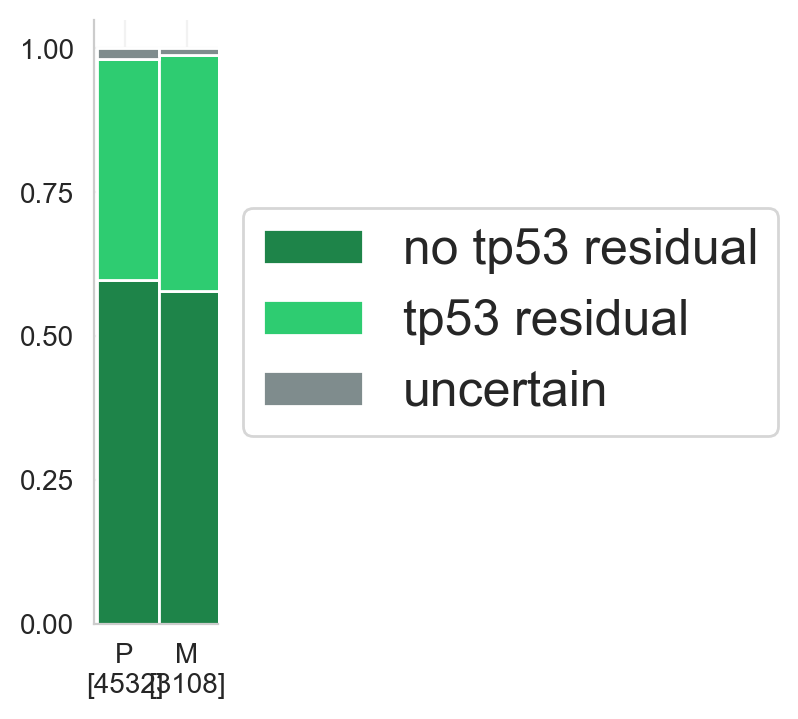

In [66]:
cancer_type = 'Breast Cancer'
master_cancer = master
#master_cancer = master[master['Cancer_Type'] == cancer_type][master['tp53_cn_state'] != 'INDETERMINATE'][~master['tp53_cn_state'].isna()]

fig, ax = plt.subplots()
metrics='tp53_res_group'
res_group_list = ['no_tp53_res','tp53_res', 'uncertain']
palette_res = ['#1E8449','#2ECC71',  '#7F8C8D']

count_prim = get_groupby(master_cancer[master_cancer['Sample_Type'] == 'Primary'], metrics, 'count_prim_' + metrics)
count_met = get_groupby(master_cancer[master_cancer['Sample_Type'] == 'Metastasis'], metrics, 'count_met_' + metrics)
count_prim = count_prim.reindex(res_group_list)
count_met = count_met.reindex(res_group_list)
display_side_by_side(count_prim, count_met)
freq_prim = pd.DataFrame(count_prim['count_prim_' + metrics]).sort_values(by=['count_prim_' + metrics], ascending=False)/ pd.DataFrame(count_prim['count_prim_' + metrics]).sum()
freq_met = pd.DataFrame(count_met['count_met_' + metrics]).sort_values(by=['count_met_' + metrics], ascending=False)/ pd.DataFrame(count_met['count_met_' + metrics]).sum()
freq_prim.columns=['P'] ; freq_met.columns=['M']
freq = pd.concat([freq_prim, freq_met], axis=1)
freq = freq.reindex(res_group_list)
display(freq)

freq.T.plot(kind = 'bar', stacked=True, figsize = (1,4), ax=ax, yticks=[0,0.25,0.5,0.75,1], color=palette_res)
ax.set_title('', weight = 'bold', fontsize=12)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(['no tp53 residual', 'tp53 residual', 'uncertain'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)



#ax.legend(['tp53 residual', 'no tp53 residual', 'uncertain'])
ax.xaxis.set_major_formatter(matplotlib.ticker.IndexFormatter([ 'P\n' + str(pd.DataFrame(count_prim['count_prim_' + metrics]).sum().values), 'M\n' + str(pd.DataFrame(count_met['count_met_' + metrics]).sum().values)]))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for container in ax.containers:
    for i, child in enumerate(container.get_children()):
        child.set_x(child.get_x() - 0.2)
        child.set_width(1)

for tick in ax.get_xticklabels():
    tick.set_rotation(0)


list_values = [None]*(len(count_prim['count_prim_tp53_res_group'].tolist())+len(count_met['count_met_tp53_res_group'].tolist()))
list_values[::2] = count_prim['count_prim_tp53_res_group'].tolist()
list_values[1::2] = count_met['count_met_tp53_res_group'].tolist()

'''for rect, value in zip(ax.patches, list_values):
    h = rect.get_height() /2.
    w = rect.get_width() /2.
    x, y = rect.get_xy()
    #We do not print NaN values
    if value == value: 
        ax.text(x+w, y+h,value,horizontalalignment='center',verticalalignment='center')'''

In [473]:
get_groupby(master_cancer, 'tp53_res_group', 'count')

count
tp53_res_group       
no_tp53_res       560
tp53_res           47
uncertain          24

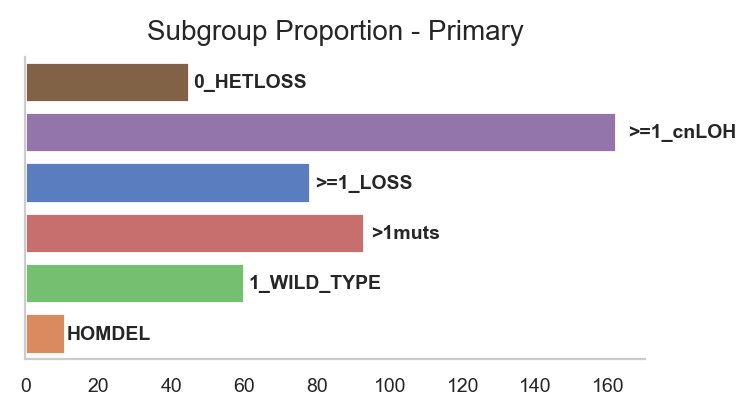

In [84]:
sns.set_style("whitegrid", {'grid.color': '1.'})
fig = plt.figure(figsize=(4,2))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
ax.set_title('Subgroup Proportion - Primary', fontsize=10)
g = sns.countplot(data=master_cancer[master_cancer['Sample_Type']== 'Primary'],
                  y='tp53_group', ax=ax,
                  order = ['0_HETLOSS', '>=1_cnLOH', '>=1_LOSS', '>1muts', '1_WILD_TYPE','HOMDEL'],
                 palette=palette)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
#g.set(xticklabels=[])
g.set(yticklabels=[])
ax.xaxis.set_tick_params(labelsize=7)


rects = ax.patches
labels = ['0_HETLOSS', '>=1_cnLOH', '>=1_LOSS', '>1muts', '1_WILD_TYPE','HOMDEL']
for rect, label in zip(rects, labels):
    height = rect.get_height() 
    width = rect.get_width()
    if np.isnan(width) : width = 0
    ax.text(width*(102/100) , rect.get_y()+(3/4)*height,  str(label),
       ha='left', va='bottom', weight='bold', fontsize=7) 

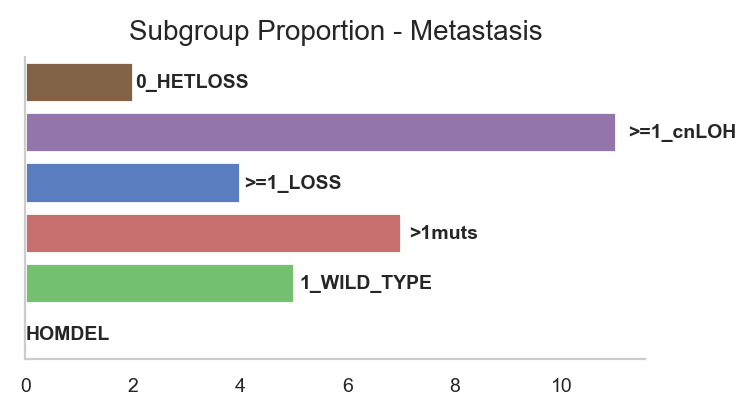

In [85]:
# Prim Samples
sns.set_style("whitegrid", {'grid.color': '1.'})
fig = plt.figure(figsize=(4,2))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
ax.set_title('Subgroup Proportion - Metastasis', fontsize=10)
g = sns.countplot(data=master_cancer[master_cancer['Sample_Type']== 'Metastasis'],
                  order=['0_HETLOSS', '>=1_cnLOH', '>=1_LOSS', '>1muts', '1_WILD_TYPE','HOMDEL'],
                  y='tp53_group', ax=ax,
                 palette=palette)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
#g.set(xticklabels=[])
g.set(yticklabels=[])
ax.xaxis.set_tick_params(labelsize=7)

rects = ax.patches
labels = ['0_HETLOSS', '>=1_cnLOH', '>=1_LOSS', '>1muts', '1_WILD_TYPE','HOMDEL']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    width = rect.get_width()
    width = rect.get_width()
    if np.isnan(width) : width = 0
    ax.text(width*(102/100) , rect.get_y()+(3/4)*height,  str(label),
        ha='left', va='bottom', weight='bold', fontsize=7) 

In [378]:
groupby_met = get_groupby(master_cancer[master_cancer['Sample_Type'] == 'Metastasis'], 'tp53_group', 'count')
groupby_prim = get_groupby(master_cancer[master_cancer['Sample_Type'] == 'Primary'], 'tp53_group', 'count')


groupby_prim = groupby_prim.to_dict()['count'] ; groupby_met = groupby_met.to_dict()['count']
    
for groupbys in [groupby_prim, groupby_met]:
    for group in ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']:
        if group not in groupbys: groupbys[group] = 0

desired_order_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']
groupby_prim = {k: groupby_prim[k] for k in desired_order_list}
groupby_met = {k: groupby_met[k] for k in desired_order_list}
print(groupby_met)
print(groupby_prim)

{'0_HETLOSS': 17, '1_WILD_TYPE': 9, '>1muts': 0, '>=1_LOSS': 104, '>=1_cnLOH': 250, 'HOMDEL': 0}
{'0_HETLOSS': 12, '1_WILD_TYPE': 9, '>1muts': 3, '>=1_LOSS': 80, '>=1_cnLOH': 144, 'HOMDEL': 3}


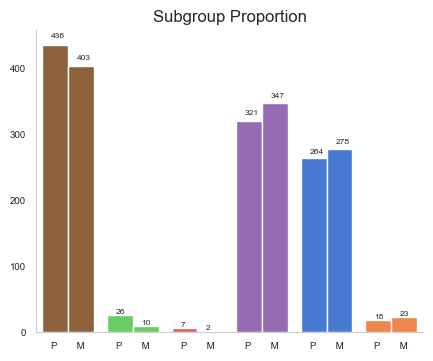

In [126]:
# Met Samples
group_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '>=1_LOSS','HOMDEL']
sns.set_style("whitegrid", {'grid.color': '1.'})
fig = plt.figure(figsize=(5,4))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
ax.set_title('Subgroup Proportion', fontsize=12)
master_cancer_prim = master_cancer[master_cancer['Sample_Type'] == 'Primary']
master_cancer_met = master_cancer[master_cancer['Sample_Type'] == 'Metastasis']
master_cancer_new = master_cancer_prim.append(master_cancer_met)
groupby_met = get_groupby(master_cancer_met, 'tp53_group', 'count')
groupby_prim = get_groupby(master_cancer_prim, 'tp53_group', 'count')
groupby_prim = groupby_prim.to_dict()['count'] ; groupby_met = groupby_met.to_dict()['count']
    
for groupbys in [groupby_prim, groupby_met]:
    for group in ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']:
        if group not in groupbys: groupbys[group] = 0

desired_order_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']
groupby_prim = {k: groupby_prim[k] for k in desired_order_list}
groupby_met = {k: groupby_met[k] for k in desired_order_list}


g = sns.countplot(data=master_cancer_new, x='tp53_group', ax=ax, hue='Sample_Type',
                  order=group_list)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_tick_params(labelsize=7)
ax.yaxis.set_tick_params(labelsize=7)
ax.set_xticklabels(['P       M']*6)
ax.get_legend().remove()

rects = ax.patches
labels = group_list*2
met_prim = ['P']*6 + ['M']*6
for rect, label, i in zip(rects, labels, range(12)):
    height = rect.get_height()
    width = rect.get_width()
    rect.set_width(1*width)
    if np.isnan(height) : height = 0
    if i<=5:
        ax.text(rect.get_x()+width/3,height*(102/100),  str(groupby_prim[group_list[i]]),
        ha='left', va='bottom', fontsize=6)
    if i>5:
        ax.text(rect.get_x()+width/3,height*(102/100),  str(groupby_met[group_list[i-6]]),
        ha='left', va='bottom', fontsize=6)
    rect.set_facecolor(palette[label])


## Densities (Purity, VAF, CCF)

### Purity

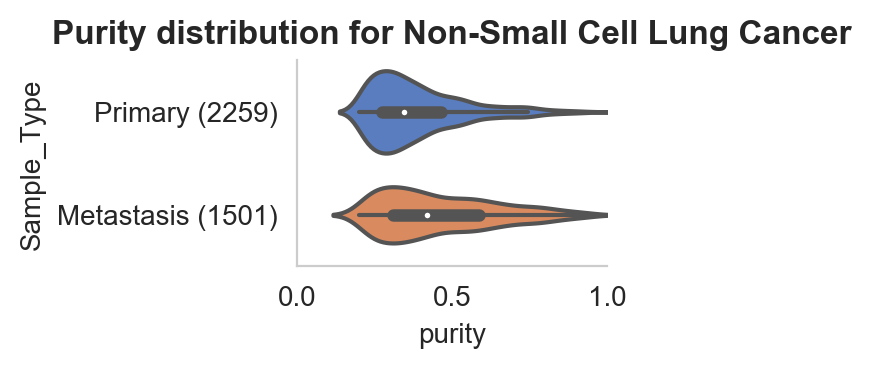

In [10]:
sns.set_style("whitegrid", {'grid.color': '1.'})
fig, ax = boxplot_sampletype(master_cancer,
                             'purity',
                             figsize= (2,3),
                             title='Purity distribution for ' + cancer_type, 
                             title_font=12,
                            continuous=True)

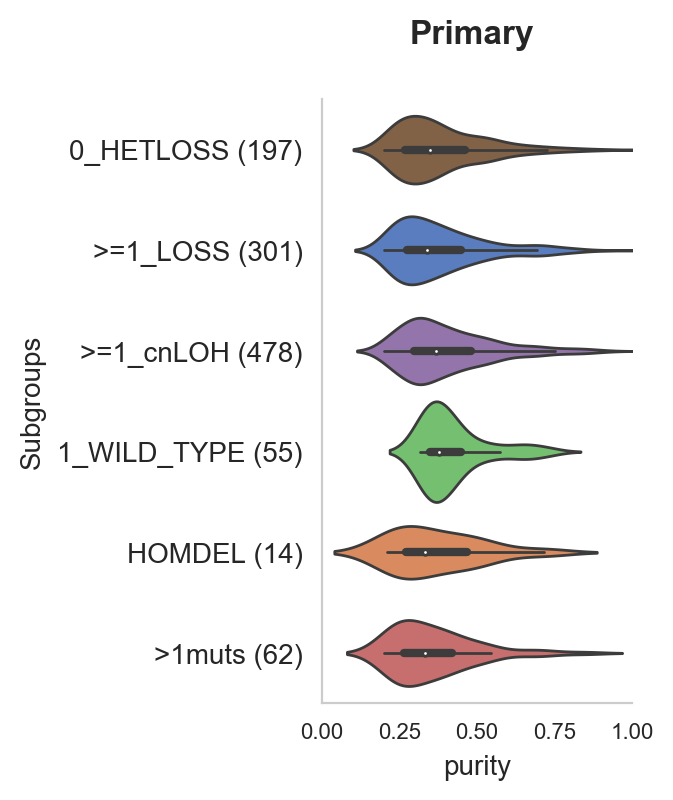

In [24]:
fig, ax = plot_mut_count_subgroups(master_cancer, 
                         cancer_type, 
                         metrics='purity', 
                         title= 'Primary', 
                         figsize = (2, 4),  
                         xlim=1, 
                         met_prim = 'Primary',
                         continuous=True,
                         linewidth=1)

plt.show(fig)

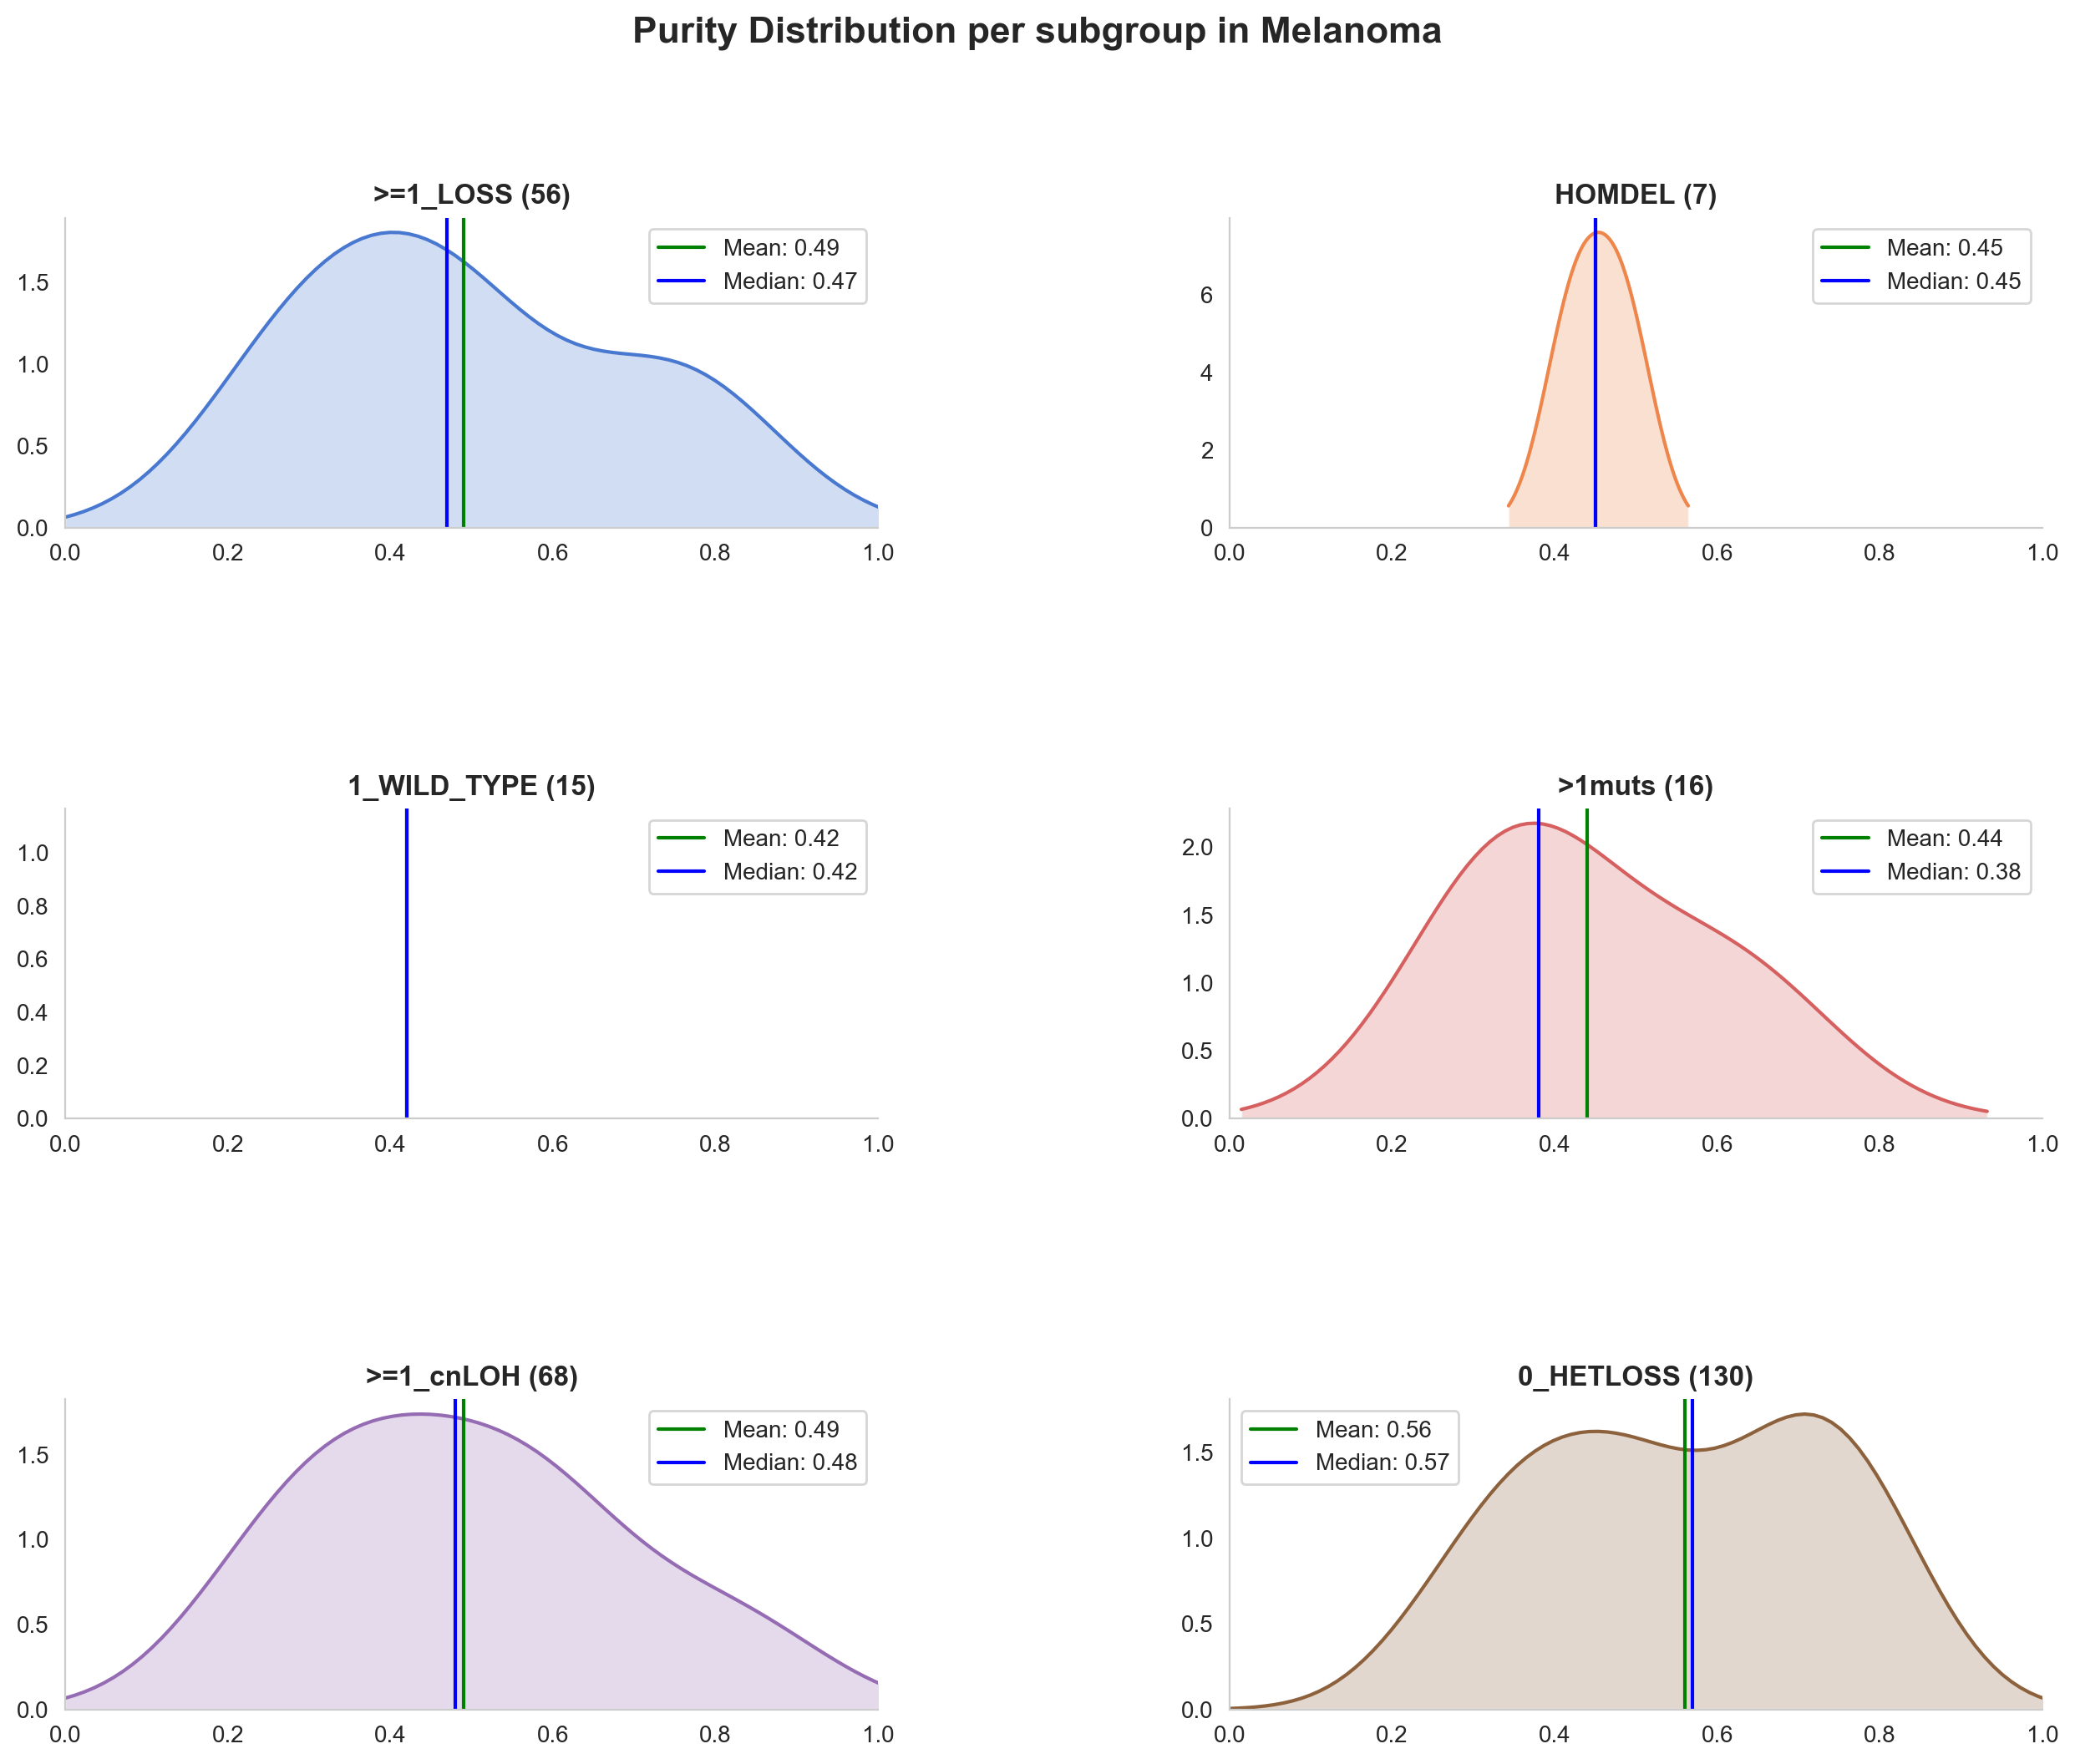

In [251]:
fig, ax = get_densities(master_cancer,
              metrics= 'purity', 
              fig_title= 'Purity Distribution per subgroup in ' + cancer_type, 
              xlabel='', 
              ylabel='',  
              number=6, 
              tp53_metrics=False,
              met_prim = 'Primary', 
              clip = (0.0,3.0), 
              x_lim =[0,1])

### TP53

#### VAF

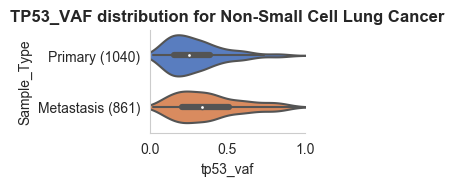

In [4]:
sns.set_style("whitegrid", {'grid.color': '1.'})
fig, ax = boxplot_sampletype(master_cancer,
                             'tp53_vaf', 
                             figsize= (2,3), 
                             title='TP53_VAF distribution for ' + cancer_type, 
                             tp53_metrics=True,
                             title_font=12,
                            continuous=True)

{'1_WILD_TYPE': 55, '>1muts': 62, '>=1_LOSS': 301, '>=1_cnLOH': 478, 'HOMDEL': 4}


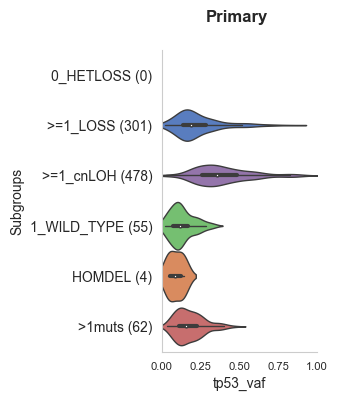

In [5]:
fig, ax = plot_mut_count_subgroups(master_cancer, 
                         cancer_type, 
                         metrics='tp53_vaf', 
                         title= 'Primary', 
                         figsize = (2, 4),  
                         xlim=1, 
                         met_prim = 'Primary',
                         continuous=True,
                         tp53_metrics=True,
                         linewidth=1)

plt.show(fig)

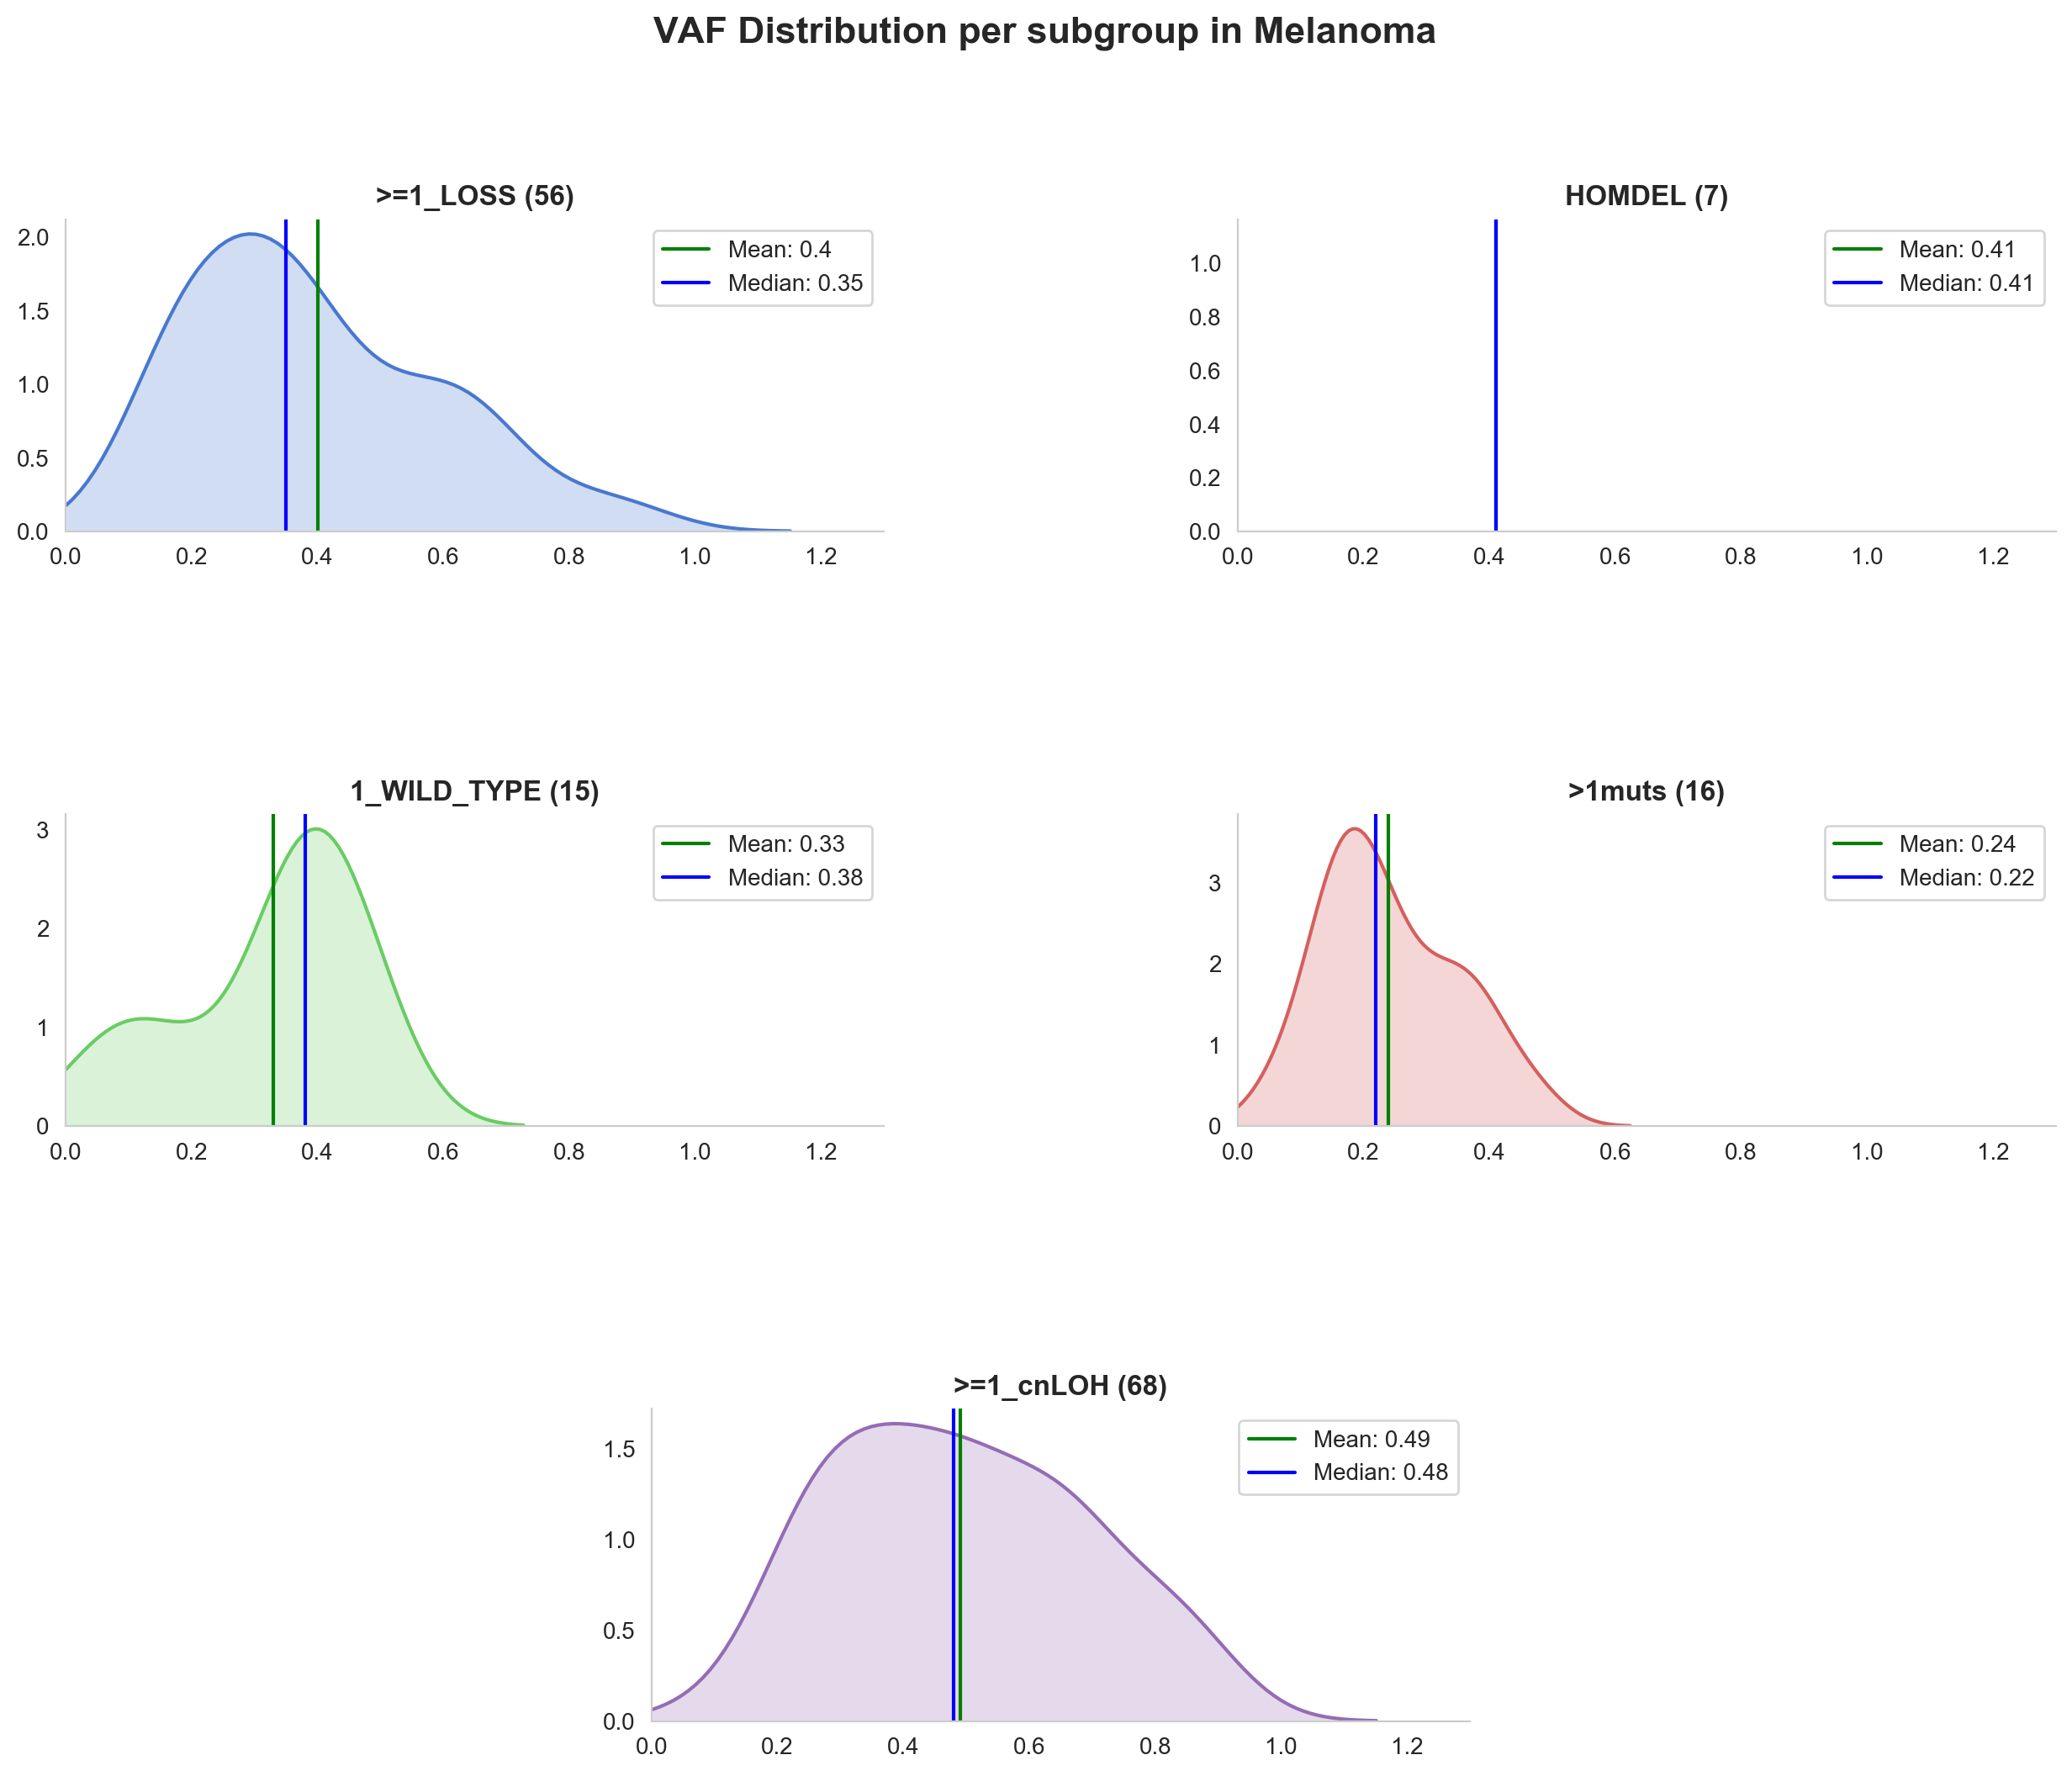

In [253]:
fig, ax = get_densities(master_cancer,
              metrics= 'tp53_vaf', 
              fig_title= 'VAF Distribution per subgroup in ' + cancer_type, 
              xlabel='', 
              ylabel='',  
              number=5, 
              tp53_metrics=True,
              met_prim = None, 
              clip = (0.0,3.0), 
              x_lim =[0,1.3])

### CCF

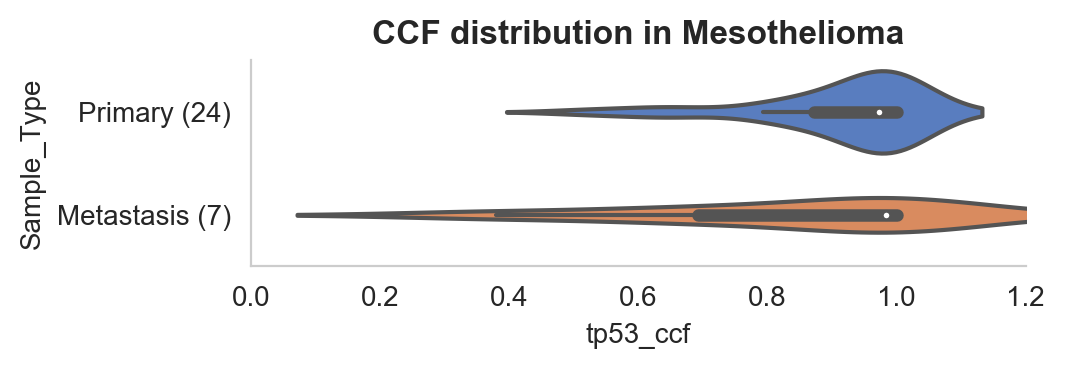

In [15]:
fig, ax = boxplot_sampletype(master_cancer, 
                             'tp53_ccf', 
                             figsize= (5,3), 
                             title='CCF distribution in ' + cancer_type, 
                             title_font=12,
                             tp53_metrics=True,
                             xlim=[0,1.2], 
                            continuous=True)

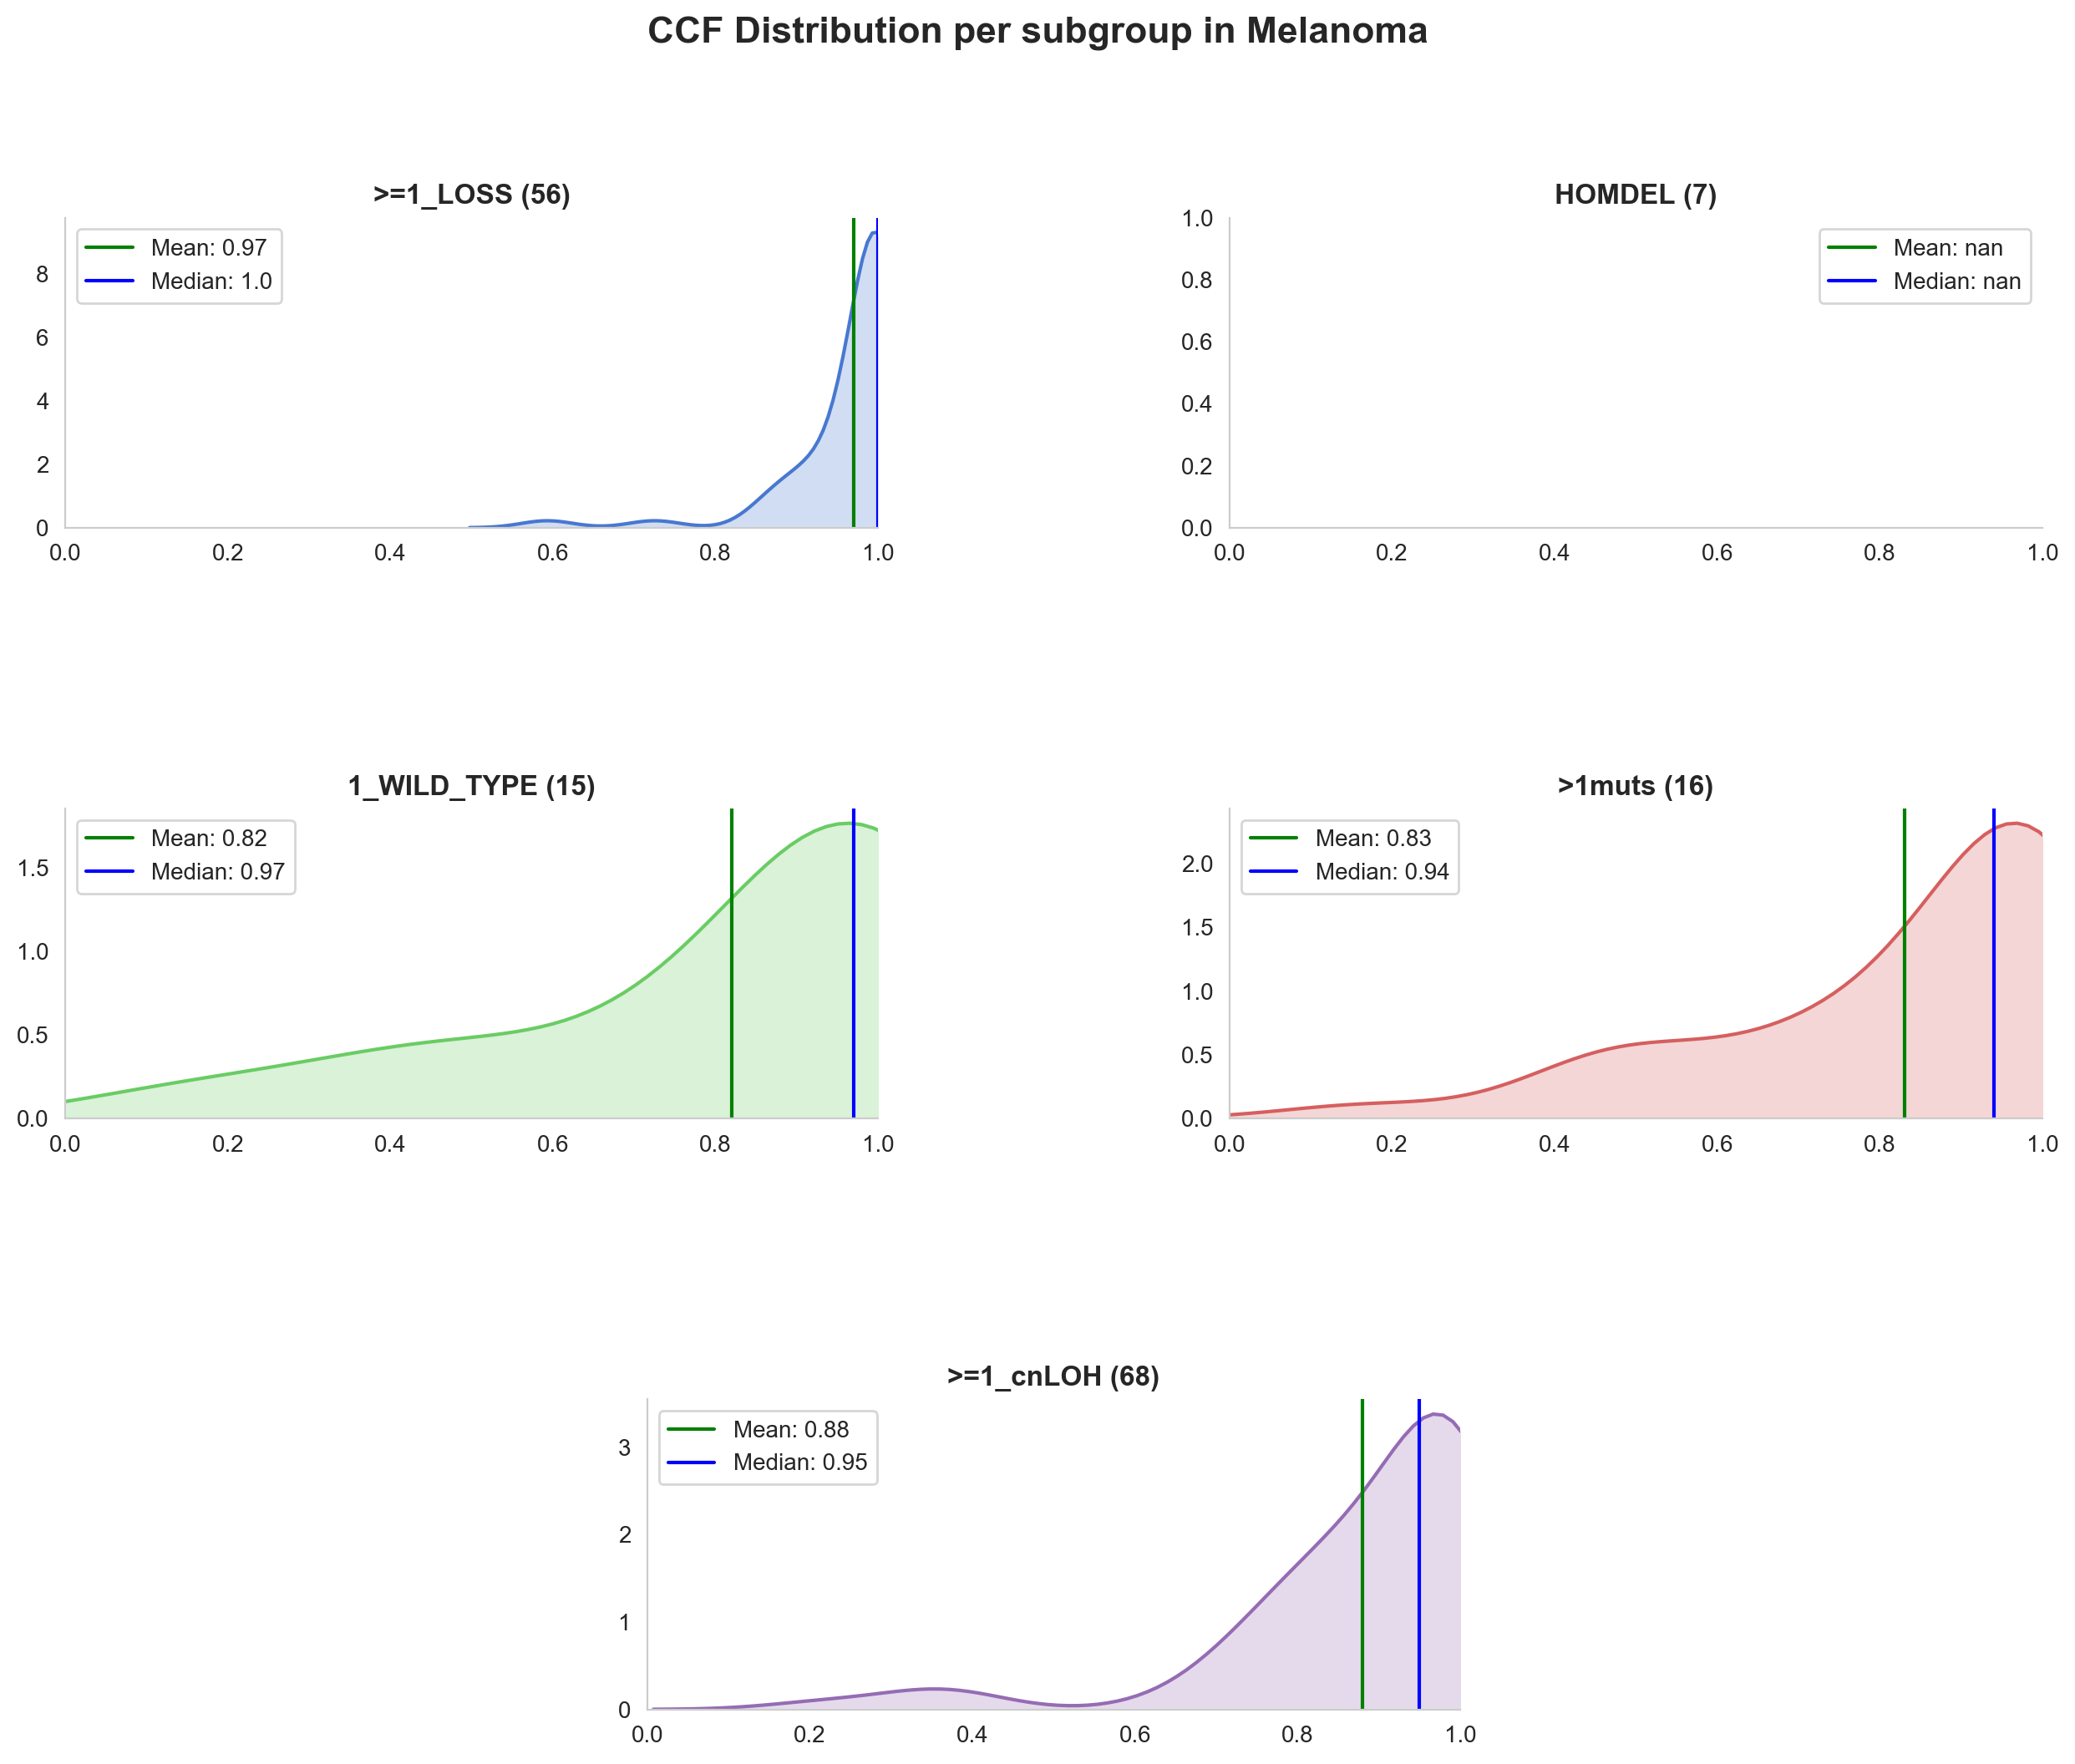

In [255]:
fig, ax = get_densities(master_cancer,
              metrics= 'tp53_ccf', 
              fig_title= 'CCF Distribution per subgroup in ' + cancer_type, 
              xlabel='', 
              ylabel='',  
              number=5, 
              tp53_metrics=True,
              met_prim = None, 
              clip = (0.0,3.0), 
              x_lim =[0,1])

## Scatter Plots (VAF, CCF)

In [112]:
def plot_scatters(data: pd.DataFrame, title:str, metrics: str, met_prim=False, figsize=(4,4)):
    fig=plt.figure(figsize=figsize)
    ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
    
    data = data[data['tp53_count']>=2]
    if met_prim:
        data = data[data['Sample_Type'] == met_prim]
    data_ccf = data[[metrics + '_1', metrics + '_2',metrics + '_3',metrics + '_4',metrics + '_5']]
    max_table_ccf = pd.DataFrame(np.sort(data_ccf.fillna(0).values)[:,-2:], columns=['2nd-largest','largest'])
    max_table_ccf = pd.concat([max_table_ccf, data.reset_index().tp53_group], axis=1)
    #display(max_table_ccf)
    
    sns.scatterplot(x='largest', y='2nd-largest', data=max_table_ccf, ax=ax, hue='tp53_group', palette=palette, legend=False)
    ax.plot([0,1], [0,1], linewidth=0.5, color='grey')
    ax.set_ylabel(metrics + '_2')
    ax.set_xlabel(metrics + '_1')
    ax.set_title(title, weight = 'bold')
    ax.text(.5,.9, str(data.shape[0]) +' samples',
        horizontalalignment='center',
        transform=ax.transAxes)
    
    return fig, ax

### VAF

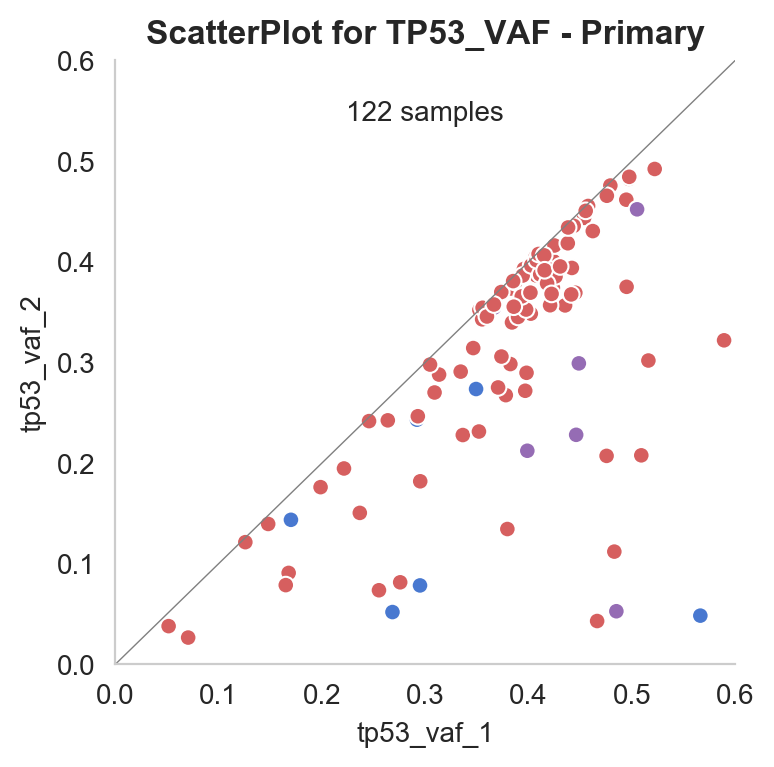

In [113]:
fig, ax = plot_scatters(master_cancer, 
              title='ScatterPlot for TP53_VAF - Primary', 
              metrics='tp53_vaf', 
              met_prim='Primary', 
              figsize=(4,4))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0, 0.6)
ax.set_ylim(0, 0.6)
plt.show(fig)

In [118]:
fig, ax = plot_scatters(master_cancer, 
              title='ScatterPlot for TP53_VAF - Metastasis', 
              metrics='tp53_vaf', 
              met_prim='Metastasis', 
              figsize=(4,4))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_xlim(0, 0.6)
#ax.set_ylim(0, 0.6)
plt.show(fig)

TypeError: plot_scatters() got an unexpected keyword argument 'figsize'

### CCF

In [ ]:
fig, ax = plot_scatters(master_cancer, 
              title='ScatterPlot for TP53_CCF - Primary', 
              metrics='tp53_ccf', 
              met_prim='Primary', 
              figsize=(4,4))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_xlim(0, 0.6)
#ax.set_ylim(0, 0.6)
plt.show(fig)

In [ ]:
fig, ax = plot_scatters(master_cancer, 
              title='ScatterPlot for TP53_CCF - Metastasis', 
              metrics='tp53_ccf', 
              met_prim='Metastasis', 
              figsize=(4,4))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_xlim(0, 0.6)
#ax.set_ylim(0, 0.6)
plt.show(fig)

# Genomic

## Genome Instability

### # of affected chromosomes

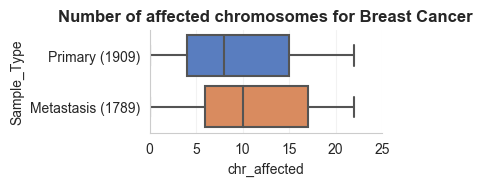

In [4]:
master_cancer_gi = master_cancer[master_cancer['chr_affected']!='NaN']
fig, ax = boxplot_sampletype(master_cancer_gi, 'chr_affected', figsize= (3,3), title='Number of affected chromosomes for '+cancer_type, title_font=12, xlim=[0,25])

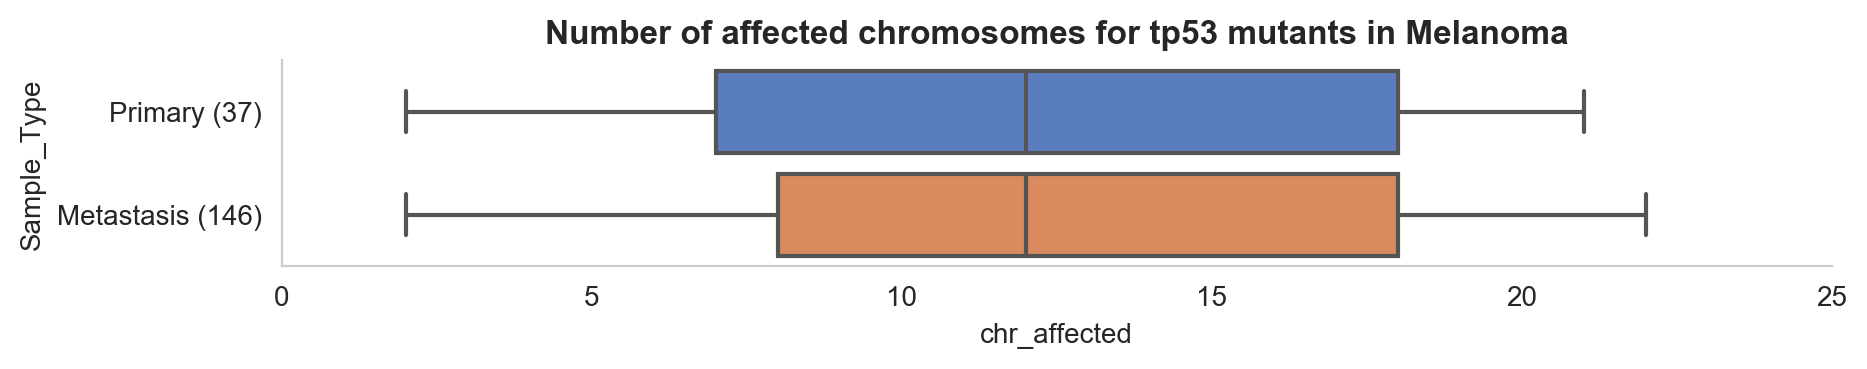

In [262]:
fig, ax = boxplot_sampletype(master_cancer_gi[master_cancer_gi['tp53_count']>=1], 'chr_affected', figsize= (10,3), title='Number of affected chromosomes for tp53 mutants in '+cancer_type, title_font=12, xlim=[0,25])

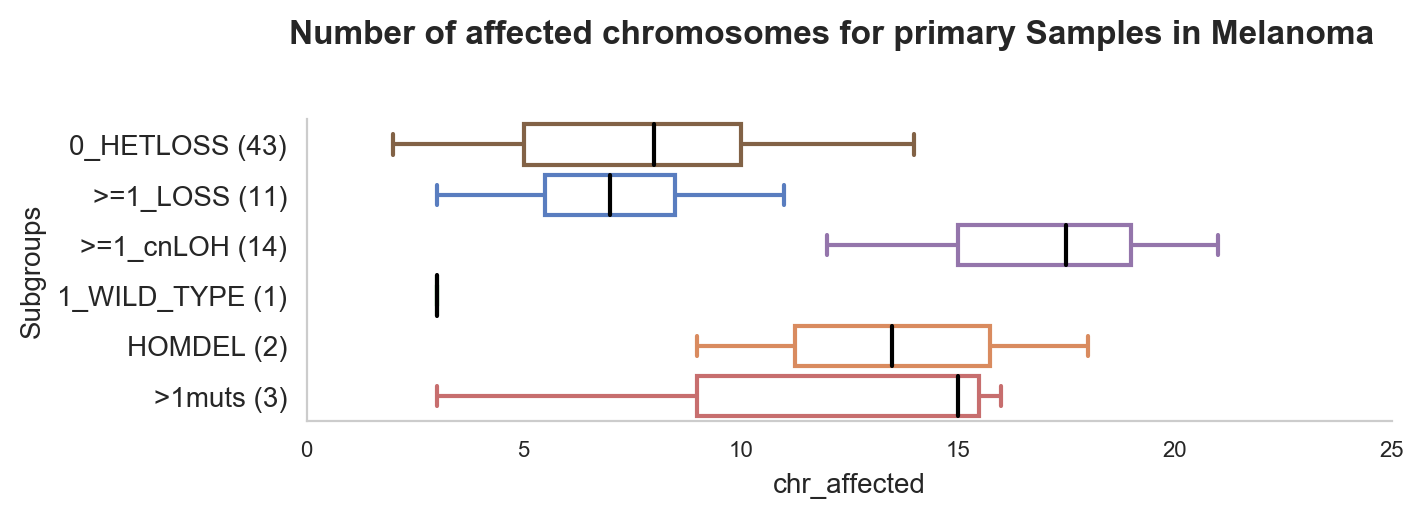

In [263]:
fig, ax = plot_mut_count_subgroups(master_cancer, 
                         cancer_type, 
                         metrics='chr_affected', 
                         title= 'Number of affected chromosomes for primary Samples in ' + cancer_type, 
                         figsize = (7, 2),  
                         xlim=25, 
                         met_prim = 'Primary')

plt.show(fig)

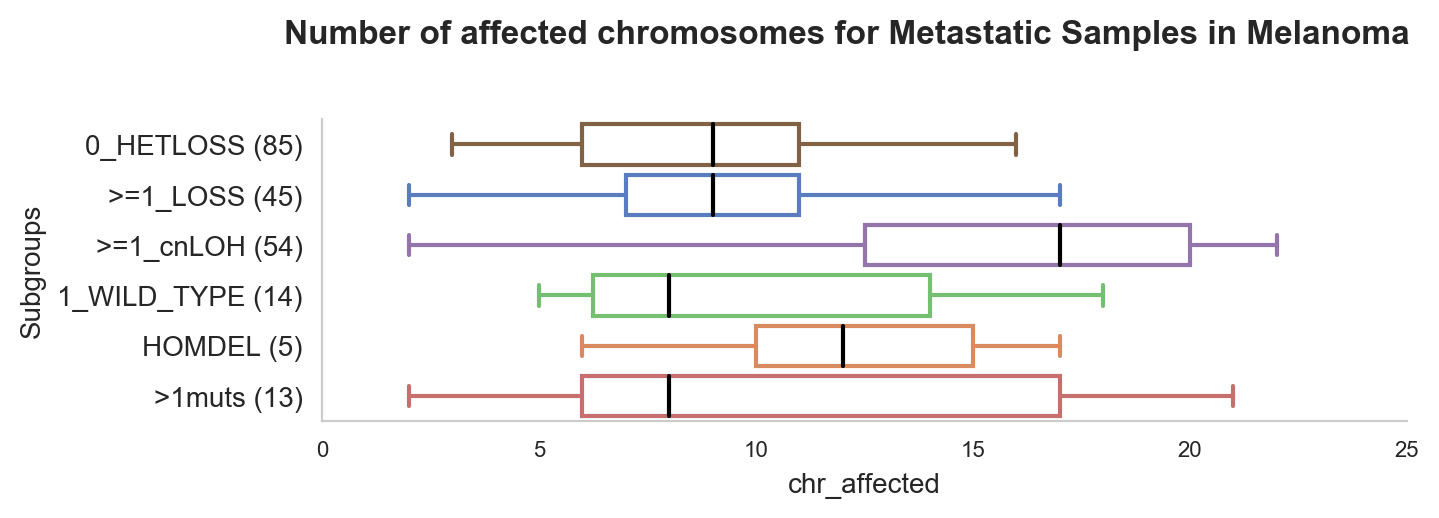

In [264]:
fig, ax = plot_mut_count_subgroups(master_cancer, 
                         cancer_type, 
                         metrics='chr_affected', 
                         title= 'Number of affected chromosomes for Metastatic Samples in ' + cancer_type, 
                         figsize = (7, 2),  
                         xlim=25, 
                         met_prim = 'Metastasis')

plt.show(fig)

### # of chromosomes affected by a LOSS

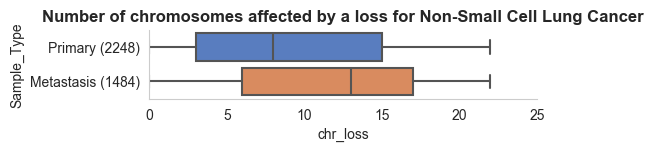

In [9]:
master_cancer_gi = master_cancer[master_cancer['chr_loss']!='NaN']
fig, ax = boxplot_sampletype(master_cancer_gi, 'chr_loss', figsize= (5,2), title='Number of chromosomes affected by a loss for '+cancer_type, title_font=12, xlim=[0,25])

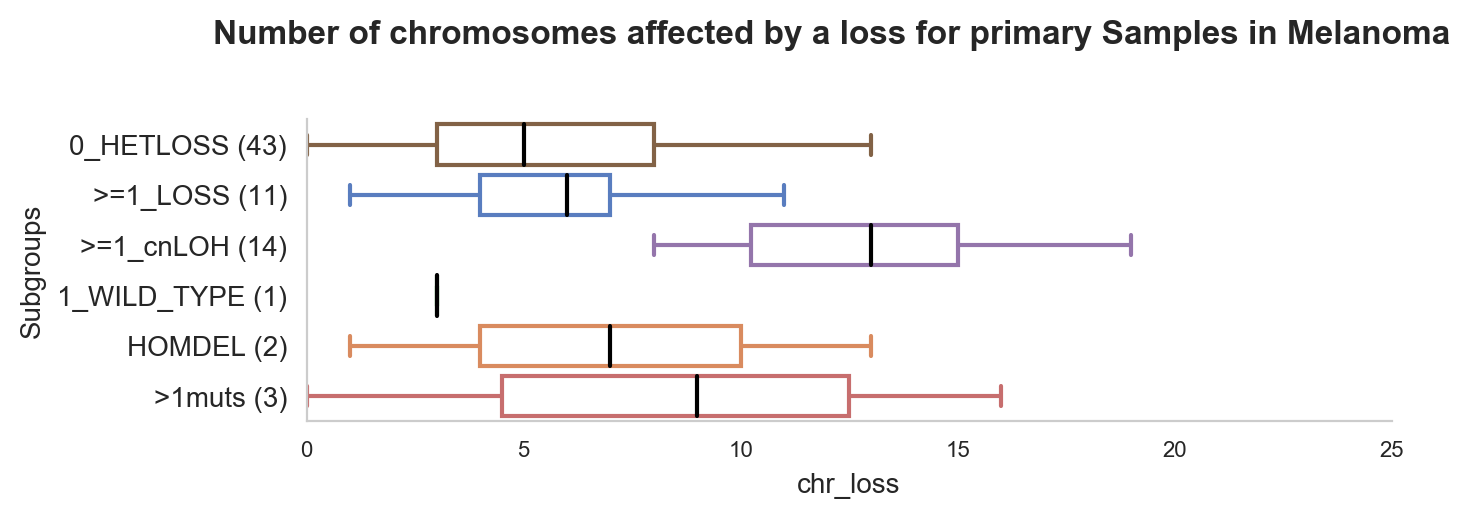

In [266]:
fig, ax = plot_mut_count_subgroups(master_cancer, 
                         cancer_type, 
                         metrics='chr_loss', 
                         title= 'Number of chromosomes affected by a loss for primary Samples in ' + cancer_type, 
                         figsize = (7, 2),  
                         xlim=25, 
                         met_prim = 'Primary')

plt.show(fig)

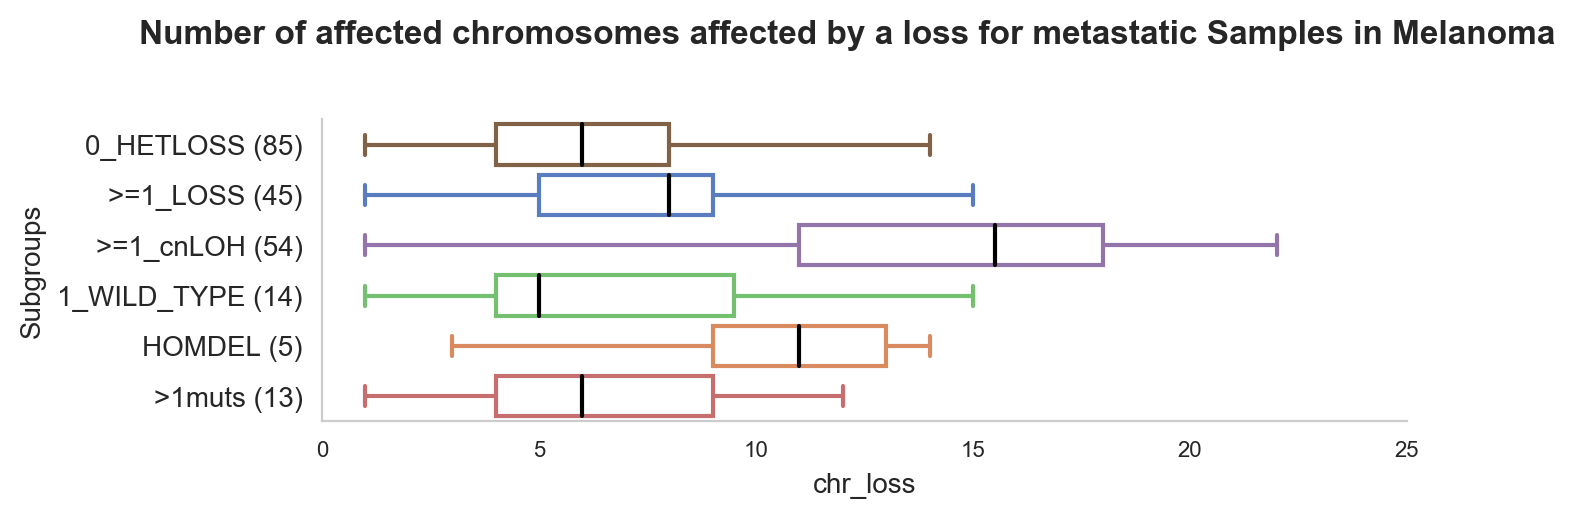

In [267]:
fig, ax = plot_mut_count_subgroups(master_cancer, 
                         cancer_type, 
                         metrics='chr_loss', 
                         title= 'Number of affected chromosomes affected by a loss for metastatic Samples in ' + cancer_type, 
                         figsize = (7, 2),  
                         xlim=25, 
                         met_prim = 'Metastasis')

plt.show(fig)

### # of chromosomes affected by a CNLOH

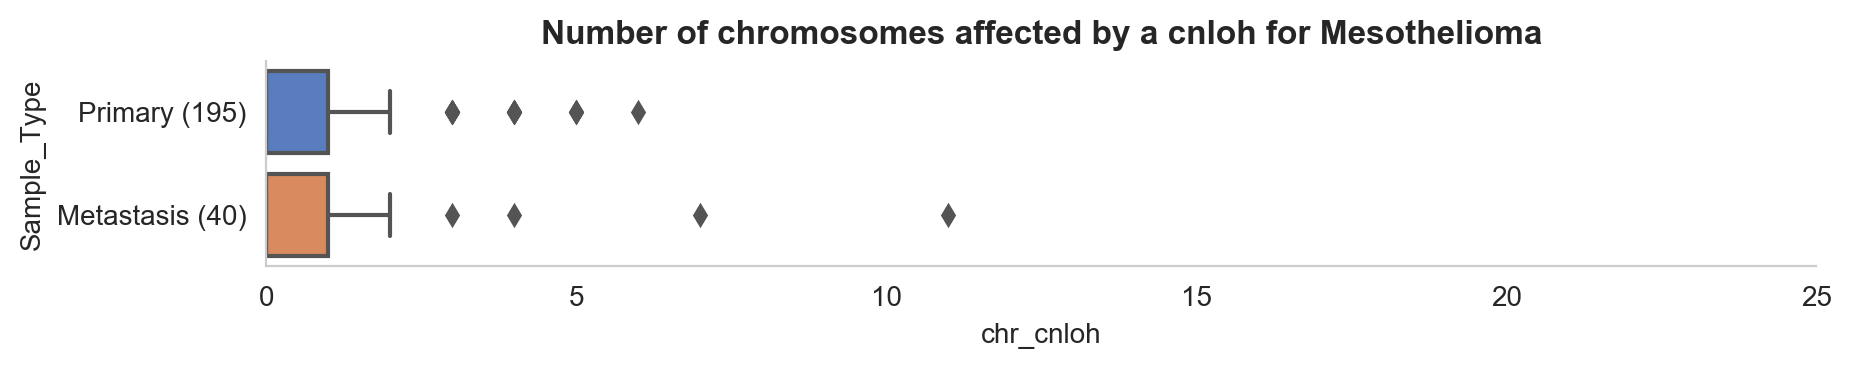

In [273]:
master_cancer_gi = master_cancer[master_cancer['chr_cnloh']!='NaN']
fig, ax = boxplot_sampletype(master_cancer_gi, 'chr_cnloh', figsize= (10,3), title='Number of chromosomes affected by a cnloh for '+cancer_type, title_font=12, xlim=[0,25])

(<Figure size 700x200 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x130eb9e10>)

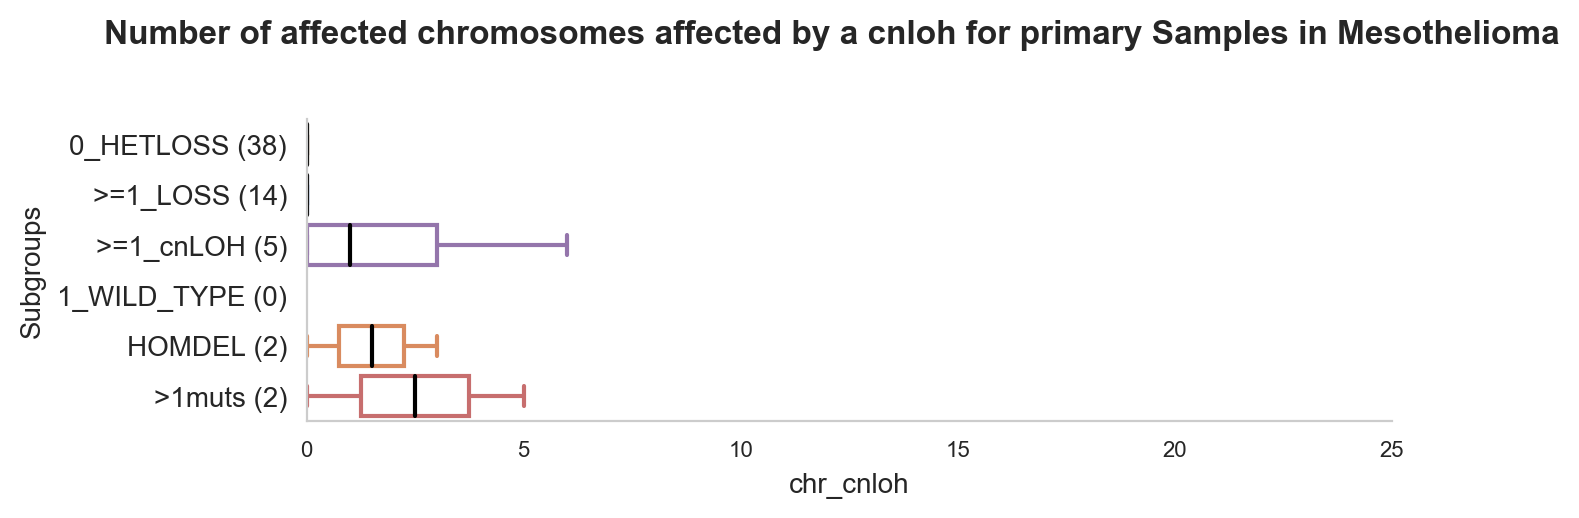

In [289]:
fig, ax = plot_mut_count_subgroups(master_cancer, 
                         cancer_type, 
                         metrics='chr_cnloh', 
                         title= 'Number of affected chromosomes affected by a cnloh for primary Samples in ' + cancer_type, 
                         figsize = (7, 2),  
                         xlim=25, 
                         met_prim = 'Primary')

plt.show(fig)

(<Figure size 700x200 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13b5878d0>)

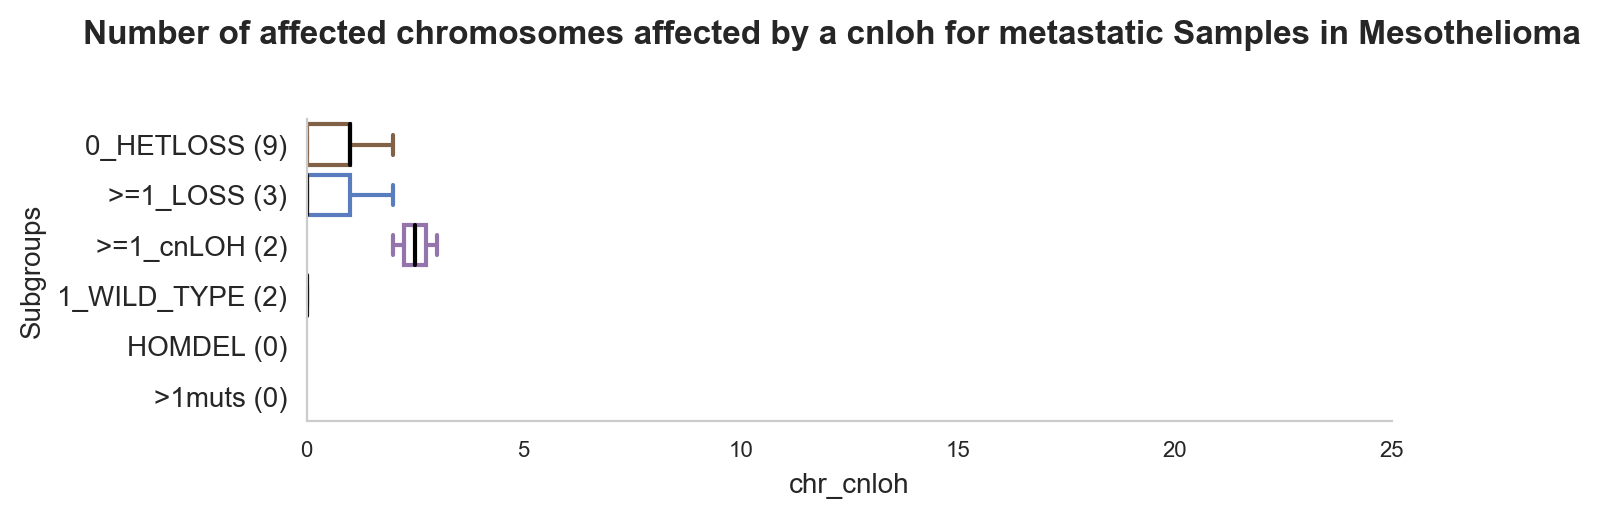

In [290]:
fig, ax = plot_mut_count_subgroups(master_cancer, 
                         cancer_type, 
                         metrics='chr_cnloh', 
                         title= 'Number of affected chromosomes affected by a cnloh for metastatic Samples in ' + cancer_type, 
                         figsize = (7, 2),  
                         xlim=25, 
                         met_prim = 'Metastasis')

plt.show(fig)

### Proportion of Whole Genome Doubling events

#### Primary / Metastasis

no_wgd  wgd     wgd_r  no_wgd_r
Sample_Type                                 
Metastasis     1109  654  0.370959  0.629041
Primary        1333  531  0.284871  0.715129

[]

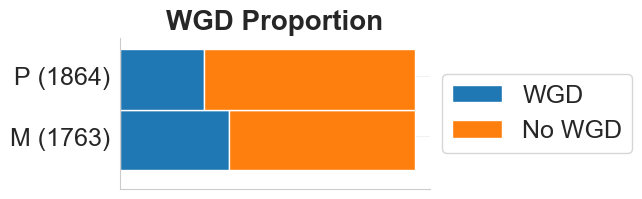

In [65]:
a = pd.DataFrame(master_cancer[['Sample_Type', 'wgd']].groupby(['Sample_Type','wgd']).size(), columns=['count_'])
a = a.unstack()
a.columns = ['no_wgd', 'wgd']
a['wgd_r'] = a.apply(lambda x: x.wgd / (x.no_wgd + x.wgd), axis=1)
a['no_wgd_r'] = a.apply(lambda x: x.no_wgd / (x.no_wgd + x.wgd), axis=1)

fig = plt.figure(figsize=(5,2))
ax = plt.subplot()
h = a[['wgd_r', 'no_wgd_r']].plot(kind = 'barh', stacked=True, ax=ax, yticks=[])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(['WGD', 'No WGD'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
ax.set_title('WGD Proportion',weight='bold', fontsize=20)

for container in ax.containers:
    for i, child in enumerate(container.get_children()):
        child.set_height(0.8)
        if i%2 == 1:
            child.set_y(child.get_y() - 0.2)

ax.set_yticklabels(['M (' + str(int(a.loc['Metastasis', ['no_wgd', 'wgd']].sum())) + ')',
                   'P (' + str(int(a.loc['Primary', ['no_wgd', 'wgd']].sum())) + ')'], 
                                fontsize=18)
'''for container in ax.containers:
    for i, child in enumerate(container.get_children()):
        if i%2 == 1: child.set_y(child.get_y() - child.get_height())  
        if i%2 == 0: child.set_y(child.get_y() + child.get_height())'''
display(a)

ax.set_yticks([0.2,1])
ax.set_xticks([])

#### TP53 residual groups

no_wgd_p  wgd_p   wgd_r_p  no_wgd_r_p  sum_p  no_wgd_m  \
tp53_res | P        458.0    8.0  0.017167    0.982833  466.0       0.0   
no_tp53_res | P     259.0  274.0  0.514071    0.485929  533.0       0.0   
uncertain | P        26.0   30.0  0.535714    0.464286   56.0       0.0   
tp53_res | M          0.0    0.0  0.000000    0.000000    0.0     415.0   
no_tp53_res | M       0.0    0.0  0.000000    0.000000    0.0     276.0   
uncertain | M         0.0    0.0  0.000000    0.000000    0.0      17.0   

                 wgd_m   wgd_r_m  no_wgd_r_m  sum_m  
tp53_res | P       0.0  0.000000    0.000000    0.0  
no_tp53_res | P    0.0  0.000000    0.000000    0.0  
uncertain | P      0.0  0.000000    0.000000    0.0  
tp53_res | M       3.0  0.007177    0.992823  418.0  
no_tp53_res | M  305.0  0.524957    0.475043  581.0  
uncertain | M     21.0  0.552632    0.447368   38.0

no_wgd_p  wgd_p   wgd_r_p  no_wgd_r_p  sum_p  no_wgd_m  \
tp53_res | P        458.0    8.0  0.017167    0.982833  466.0       0.0   
tp53_res | M          0.0    0.0  0.000000    0.000000    0.0     415.0   
no_tp53_res | P     259.0  274.0  0.514071    0.485929  533.0       0.0   
no_tp53_res | M       0.0    0.0  0.000000    0.000000    0.0     276.0   
uncertain | P        26.0   30.0  0.535714    0.464286   56.0       0.0   
uncertain | M         0.0    0.0  0.000000    0.000000    0.0      17.0   

                 wgd_m   wgd_r_m  no_wgd_r_m  sum_m  
tp53_res | P       0.0  0.000000    0.000000    0.0  
tp53_res | M       3.0  0.007177    0.992823  418.0  
no_tp53_res | P    0.0  0.000000    0.000000    0.0  
no_tp53_res | M  305.0  0.524957    0.475043  581.0  
uncertain | P      0.0  0.000000    0.000000    0.0  
uncertain | M     21.0  0.552632    0.447368   38.0

[]

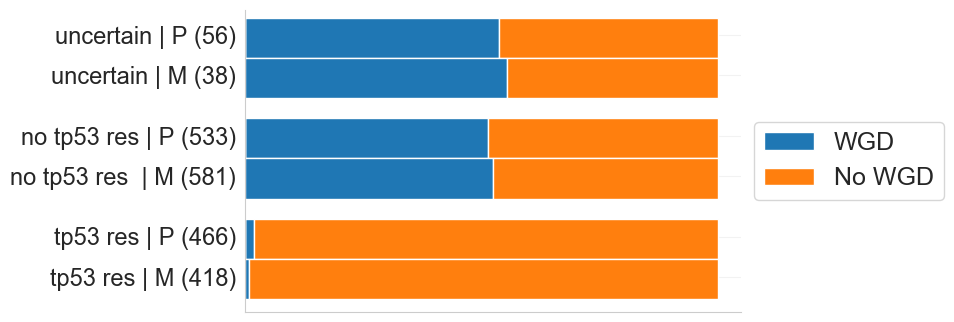

In [69]:
fig = plt.figure(figsize=(8,4))
ax = plt.subplot()

# Proportion of WGD
group='tp53_res_group'
countp = pd.DataFrame(master_cancer[master_cancer['Sample_Type'] == 'Primary'][[group, 'wgd']].groupby([group,'wgd']).size(), columns=['count_'])
countm = pd.DataFrame(master_cancer[master_cancer['Sample_Type'] == 'Metastasis'][[group, 'wgd']].groupby([group,'wgd']).size(), columns=['count_'])
countp = countp.unstack() ; countm = countm.unstack()
countm = countm.fillna(0) ; countp = countp.fillna(0)
countm.columns = ['no_wgd_m', 'wgd_m'] ; countp.columns = ['no_wgd_p', 'wgd_p']

countm['wgd_r_m'] = countm.apply(lambda x: x.wgd_m / (x.no_wgd_m + x.wgd_m), axis=1)
countm['no_wgd_r_m'] = countm.apply(lambda x: x.no_wgd_m / (x.no_wgd_m + x.wgd_m), axis=1)

countp['wgd_r_p'] = countp.apply(lambda x: x.wgd_p / (x.no_wgd_p + x.wgd_p), axis=1)
countp['no_wgd_r_p'] = countp.apply(lambda x: x.no_wgd_p / (x.no_wgd_p + x.wgd_p), axis=1)

#display(countm)
columns_m = list(countm.columns)
columns_p = list(countp.columns)
#display(countm.index)


for line in ['tp53_res', 'no_tp53_res', 'uncertain']:
    if line not in list(countm.index):
        countm = countm.append(pd.Series({'no_wgd_m':0,'wgd_m':0,'wgd_r_m':0,'no_wgd_r_m':0}, name=line))
    if line not in list(countp.index):
        countp = countp.append(pd.Series({'no_wgd_p':0,'wgd_p':0,'wgd_r_p':0,'no_wgd_r_p':0}, name=line))

        
countm = countm.reindex(['tp53_res', 'no_tp53_res', 'uncertain'])
countp = countp.reindex(['tp53_res', 'no_tp53_res', 'uncertain'])
countp['sum_p'] = countp[['no_wgd_p', 'wgd_p']].sum(axis=1) ; countm['sum_m'] = countm[['no_wgd_m', 'wgd_m']].sum(axis=1)

countm = countm.set_index(pd.Series(['tp53_res | M','no_tp53_res | M', 'uncertain | M']))
countp = countp.set_index(pd.Series(['tp53_res | P','no_tp53_res | P', 'uncertain | P']))

count = pd.concat([countp, countm], axis=0).fillna(0)
display(count)
#display(count)
count = count.reindex(['tp53_res | P','tp53_res | M','no_tp53_res | P','no_tp53_res | M', 'uncertain | P', 'uncertain | M'])

display(count)

df = count[['wgd_r_p', 'no_wgd_r_p','wgd_r_m', 'no_wgd_r_m']]
h = df.plot(kind = 'barh', stacked=True, ax=ax, yticks=[], color=['#1f77b4','#ff7f0e'])
ax.legend(fontsize='small', ncol=1)
ax.set_xlabel('', fontsize=17)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(['WGD', 'No WGD'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
ax.set_title('',weight='bold', fontsize=20)


for container in ax.containers:
    for i, child in enumerate(container.get_children()):
        child.set_height(0.8)
        if i%2 == 1:
            child.set_y(child.get_y() - 0.2)
            

for container in ax.containers:
    for i, child in enumerate(container.get_children()):
        if i%2 == 1: child.set_y(child.get_y() - child.get_height())  
        if i%2 == 0: child.set_y(child.get_y() + child.get_height())


ax.set_yticklabels(['uncertain | P ('+ str(int(count.loc['uncertain | P', 'sum_p'])) + ')',
                            'uncertain | M ('+ str(int(count.loc['uncertain | M', 'sum_m'])) + ')',
                            'no tp53 res | P ('+ str(int(count.loc['no_tp53_res | P', 'sum_p'])) + ')',
                            'no tp53 res  | M ('+ str(int(count.loc['no_tp53_res | M', 'sum_m'])) + ')',
                            'tp53 res | P ('+ str(int(count.loc['tp53_res | P', 'sum_p'])) + ')',
                            'tp53 res | M ('+ str(int(count.loc['tp53_res | M', 'sum_m'])) + ')'][::-1],
                             fontsize=10)


ax.set_yticks([ 0.2,1, 2.2,3,  4.2,5])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(17)
ax.set_xticks([])

#### TP53 subgroups

no_wgd_p  wgd_p   wgd_r_p  no_wgd_r_p  sum_p  no_wgd_m  \
0_HETLOSS | P       434.0    1.0  0.002299    0.997701  435.0       0.0   
1_WILD_TYPE | P      23.0    6.0  0.206897    0.793103   29.0       0.0   
>1muts | P            4.0    2.0  0.333333    0.666667    6.0       0.0   
>=1_LOSS | P        246.0   15.0  0.057471    0.942529  261.0       0.0   
>=1_cnLOH | P        36.0  285.0  0.887850    0.112150  321.0       0.0   
HOMDEL | P            0.0    3.0  1.000000    0.000000    3.0       0.0   
0_HETLOSS | M         0.0    0.0  0.000000    0.000000    0.0     406.0   
1_WILD_TYPE | M       0.0    0.0  0.000000    0.000000    0.0       8.0   
>1muts | M            0.0    0.0  0.000000    0.000000    0.0       1.0   
>=1_LOSS | M          0.0    0.0  0.000000    0.000000    0.0     266.0   
>=1_cnLOH | M         0.0    0.0  0.000000    0.000000    0.0      27.0   
HOMDEL | M            0.0    0.0  0.000000    0.000000    0.0       0.0   

                 wgd_m   wgd_r_m  no_wgd_r_m  sum_m  
0_HETLOSS | P      0.0  0.000000    0.000000    0.0  
1_WILD_TYPE | P    0.0  0.000000    0.000000    0.0  
>1muts | P         0.0  0.000000    0.000000    0.0  
>=1_LOSS | P       0.0  0.000000    0.000000    0.0  
>=1_cnLOH | P      0.0  0.000000    0.000000    0.0  
HOMDEL | P         0.0  0.000000    0.000000    0.0  
0_HETLOSS | M      0.0  0.000000    1.000000  406.0  
1_WILD_TYPE | M    3.0  0.272727    0.727273   11.0  
>1muts | M         0.0  0.000000    1.000000    1.0  
>=1_LOSS | M      15.0  0.053381    0.946619  281.0  
>=1_cnLOH | M    308.0  0.919403    0.080597  335.0  
HOMDEL | M         3.0  1.000000    0.000000    3.0

no_wgd_p  wgd_p   wgd_r_p  no_wgd_r_p  sum_p  no_wgd_m  \
HOMDEL | P            0.0    3.0  1.000000    0.000000    3.0       0.0   
HOMDEL | M            0.0    0.0  0.000000    0.000000    0.0       0.0   
>=1_cnLOH | P        36.0  285.0  0.887850    0.112150  321.0       0.0   
>=1_cnLOH | M         0.0    0.0  0.000000    0.000000    0.0      27.0   
>=1_LOSS | P        246.0   15.0  0.057471    0.942529  261.0       0.0   
>=1_LOSS | M          0.0    0.0  0.000000    0.000000    0.0     266.0   
>1muts | P            4.0    2.0  0.333333    0.666667    6.0       0.0   
>1muts | M            0.0    0.0  0.000000    0.000000    0.0       1.0   
1_WILD_TYPE | P      23.0    6.0  0.206897    0.793103   29.0       0.0   
1_WILD_TYPE | M       0.0    0.0  0.000000    0.000000    0.0       8.0   
0_HETLOSS | P       434.0    1.0  0.002299    0.997701  435.0       0.0   
0_HETLOSS | M         0.0    0.0  0.000000    0.000000    0.0     406.0   

                 wgd_m   wgd_r_m  no_wgd_r_m  sum_m  
HOMDEL | P         0.0  0.000000    0.000000    0.0  
HOMDEL | M         3.0  1.000000    0.000000    3.0  
>=1_cnLOH | P      0.0  0.000000    0.000000    0.0  
>=1_cnLOH | M    308.0  0.919403    0.080597  335.0  
>=1_LOSS | P       0.0  0.000000    0.000000    0.0  
>=1_LOSS | M      15.0  0.053381    0.946619  281.0  
>1muts | P         0.0  0.000000    0.000000    0.0  
>1muts | M         0.0  0.000000    1.000000    1.0  
1_WILD_TYPE | P    0.0  0.000000    0.000000    0.0  
1_WILD_TYPE | M    3.0  0.272727    0.727273   11.0  
0_HETLOSS | P      0.0  0.000000    0.000000    0.0  
0_HETLOSS | M      0.0  0.000000    1.000000  406.0

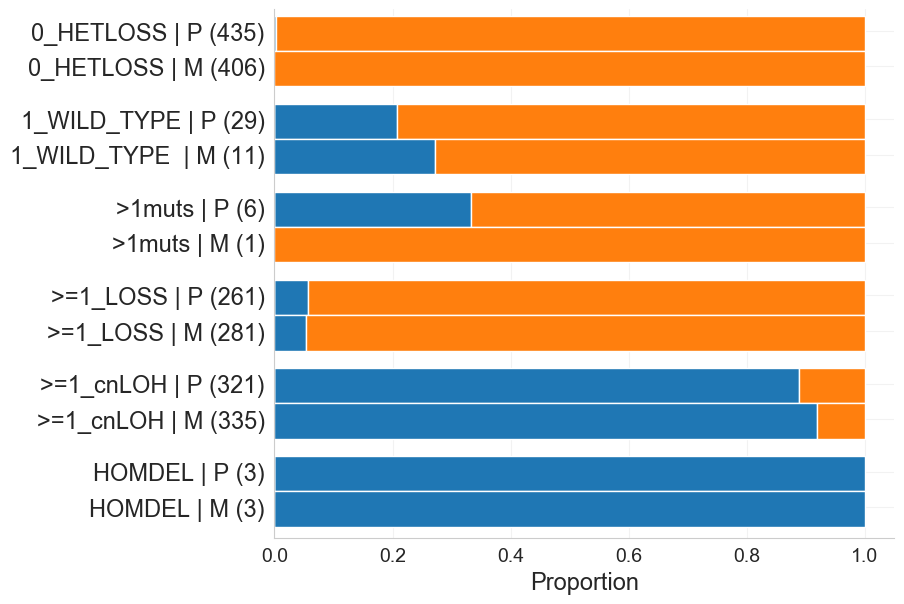

In [57]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot()

# Proportion of WGD
group='tp53_group'
group_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '>=1_LOSS','HOMDEL']

countp = pd.DataFrame(master_cancer[master_cancer['Sample_Type'] == 'Primary'][[group, 'wgd']].groupby([group,'wgd']).size(), columns=['count_'])
countm = pd.DataFrame(master_cancer[master_cancer['Sample_Type'] == 'Metastasis'][[group, 'wgd']].groupby([group,'wgd']).size(), columns=['count_'])
countp = countp.unstack() ; countm = countm.unstack()
countm = countm.fillna(0) ; countp = countp.fillna(0)
countm.columns = ['no_wgd_m', 'wgd_m'] ; countp.columns = ['no_wgd_p', 'wgd_p']

countm['wgd_r_m'] = countm.apply(lambda x: x.wgd_m / (x.no_wgd_m + x.wgd_m), axis=1)
countm['no_wgd_r_m'] = countm.apply(lambda x: x.no_wgd_m / (x.no_wgd_m + x.wgd_m), axis=1)

countp['wgd_r_p'] = countp.apply(lambda x: x.wgd_p / (x.no_wgd_p + x.wgd_p), axis=1)
countp['no_wgd_r_p'] = countp.apply(lambda x: x.no_wgd_p / (x.no_wgd_p + x.wgd_p), axis=1)

#display(countm)
columns_m = list(countm.columns)
columns_p = list(countp.columns)
#display(countm.index)


for line in group_list:
    if line not in list(countm.index):
        countm = countm.append(pd.Series({'no_wgd_m':0,'wgd_m':0,'wgd_r_m':0,'no_wgd_r_m':0}, name=line))
    if line not in list(countp.index):
        countp = countp.append(pd.Series({'no_wgd_p':0,'wgd_p':0,'wgd_r_p':0,'no_wgd_r_p':0}, name=line))

        
countm = countm.reindex(['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL'])
countp = countp.reindex(['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL'])
countp['sum_p'] = countp[['no_wgd_p', 'wgd_p']].sum(axis=1) ; countm['sum_m'] = countm[['no_wgd_m', 'wgd_m']].sum(axis=1)

countm = countm.set_index(pd.Series(['0_HETLOSS | M','1_WILD_TYPE | M', '>1muts | M', '>=1_LOSS | M', '>=1_cnLOH | M', 'HOMDEL | M']))
countp = countp.set_index(pd.Series(['0_HETLOSS | P','1_WILD_TYPE | P', '>1muts | P', '>=1_LOSS | P', '>=1_cnLOH | P', 'HOMDEL | P']))

count = pd.concat([countp, countm], axis=0).fillna(0)
display(count)
#display(count)
count = count.reindex(['0_HETLOSS | M', '0_HETLOSS | P',
                       '1_WILD_TYPE | M','1_WILD_TYPE | P',
                       '>1muts | M','>1muts | P', 
                       '>=1_LOSS | M','>=1_LOSS | P',
                       '>=1_cnLOH | M','>=1_cnLOH | P',
                        'HOMDEL | M', 'HOMDEL | P'][::-1])

display(count)

df = count[['wgd_r_p', 'no_wgd_r_p','wgd_r_m', 'no_wgd_r_m']]
h = df.plot(kind = 'barh', stacked=True, ax=ax, yticks=[], color=['#1f77b4','#ff7f0e'])
ax.legend(fontsize='small', ncol=1)
ax.set_xlabel('Proportion', fontsize=17)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(['WGD', 'No WGD'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
ax.set_title('',weight='bold', fontsize=20)


for container in ax.containers:
    for i, child in enumerate(container.get_children()):
        child.set_height(0.8)
        if i%2 == 1:
            child.set_y(child.get_y() - 0.2)
            

for container in ax.containers:
    for i, child in enumerate(container.get_children()):
        if i%2 == 1: child.set_y(child.get_y() - child.get_height())  
        if i%2 == 0: child.set_y(child.get_y() + child.get_height())


ax.set_yticklabels(['0_HETLOSS | P ('+ str(int(count.loc['0_HETLOSS | P', 'sum_p'])) + ')',
                    '0_HETLOSS | M ('+ str(int(count.loc['0_HETLOSS | M', 'sum_m'])) + ')',
                    '1_WILD_TYPE | P ('+ str(int(count.loc['1_WILD_TYPE | P', 'sum_p'])) + ')',
                    '1_WILD_TYPE  | M ('+ str(int(count.loc['1_WILD_TYPE | M', 'sum_m'])) + ')',
                    '>1muts | P ('+ str(int(count.loc['>1muts | P', 'sum_p'])) + ')',
                    '>1muts | M ('+ str(int(count.loc['>1muts | M', 'sum_m'])) + ')',
                    '>=1_LOSS | P ('+ str(int(count.loc['>=1_LOSS | P', 'sum_p'])) + ')',
                    '>=1_LOSS | M ('+ str(int(count.loc['>=1_LOSS | M', 'sum_m'])) + ')',
                    '>=1_cnLOH | P ('+ str(int(count.loc['>=1_cnLOH | P', 'sum_p'])) + ')',
                    '>=1_cnLOH | M ('+ str(int(count.loc['>=1_cnLOH | M', 'sum_m'])) + ')',
                    'HOMDEL | P ('+ str(int(count.loc['HOMDEL | P', 'sum_p'])) + ')',
                    'HOMDEL | M ('+ str(int(count.loc['HOMDEL | M', 'sum_m'])) + ')'][::-1],
                     fontsize=10)


ax.set_yticks([ 0.2,1, 2.2,3,  4.2,5, 6.2,7, 8.2,9 ,10.2,11])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(17)
ax.get_legend().remove()

In [74]:
get_groupby(master_cancer[master_cancer['tp53_group'] == '1_WILD_TYPE'][master_cancer['Sample_Type'] == 'Primary'],'wgd', 'count')

count
wgd        
-1.0     23
 1.0      6

## Mutational Landscape

## Mutation Count

In [248]:
def boxplot_mutation_count(df: pd.DataFrame, metrics: str, ax, title: str = '',tp53_metrics=False, title_font: int=20, xlim=[0,1], continuous= False):
    groupby = get_groupby(df, 'Sample_Type', 'count')

    statistic, p_value = ranksums(df[df['Sample_Type'] == 'Primary'][metrics].dropna().values,df[df['Sample_Type'] == 'Metastasis'][metrics].dropna().values)
    if p_value<0.001: s='P < 0.001'
    else: s='P = %.3f'%p_value
    ax.annotate(s=s, xy=(0.8,0.5), xycoords='axes fraction', fontsize='x-large')
    
    #g = sns.boxplot(x=metrics, y='Sample_Type',data=df,ax=ax, dodge=False,order=['Primary', 'Metastasis'], palette='muted', showfliers=False).set_title(title, weight='bold', fontsize=title_font)
    h = sns.boxplot(x='driver_count', y='Sample_Type', data=df,dodge=False,order=['Primary', 'Metastasis'], palette='seismic', showfliers=False)
    if tp53_metrics:
        try:
            ax.set_yticklabels(['P (' + str(numbers[0]) + ')',
                                'M (' + str(numbers[1]) + ')'], 
                                fontsize=18)
        except: pass
    else: 
        try:
            ax.set_yticklabels(['P (' + str(int(groupby.loc['Primary'])) + ')',
                                'M (' + str(int(groupby.loc['Metastasis'])) + ')'], 
                                fontsize=18)
        except: pass

    ax.set_xlim(xlim)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    
    '''for i, artist in enumerate(ax.artists[2:]):
        #col = artist.get_facecolor()
        artist.set_edgecolor('green')
        artist.set_facecolor('None')
        for j in range(i * 5, i * 5 + 5):
            line = artist.lines[j]
            if j % 5 == 1: line.set_color('None')
            if j % 5 == 2: line.set_color('None')
            if j % 5 == 3: line.set_color('None')
            if j % 5 == 4: line.set_color('green')
            #if j % 5 == 5: line.set_color('black')
            line.set_mfc('None')
            line.set_mec('None')'''
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(h[element], color='red')

    for patch in h['boxes']:
        patch.set(facecolor='green')     

    #print(ax.containers)


TypeError: 'AxesSubplot' object is not subscriptable

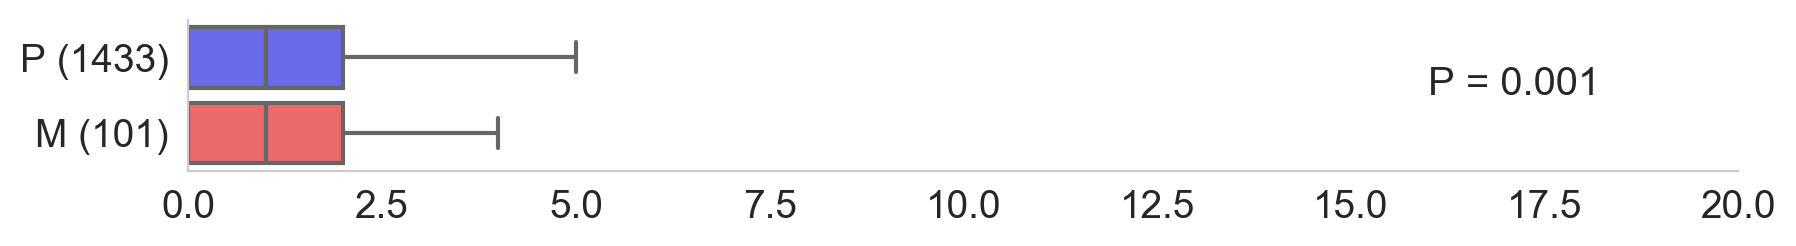

In [249]:
fig = plt.figure(figsize=(10,1))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)

boxplot_mutation_count(master_cancer, 
                       metrics='mutation_count', 
                       ax=ax, 
                       title= '',
                       tp53_metrics=False,
                       title_font=20,
                       xlim=[0,20],
                       continuous= False)

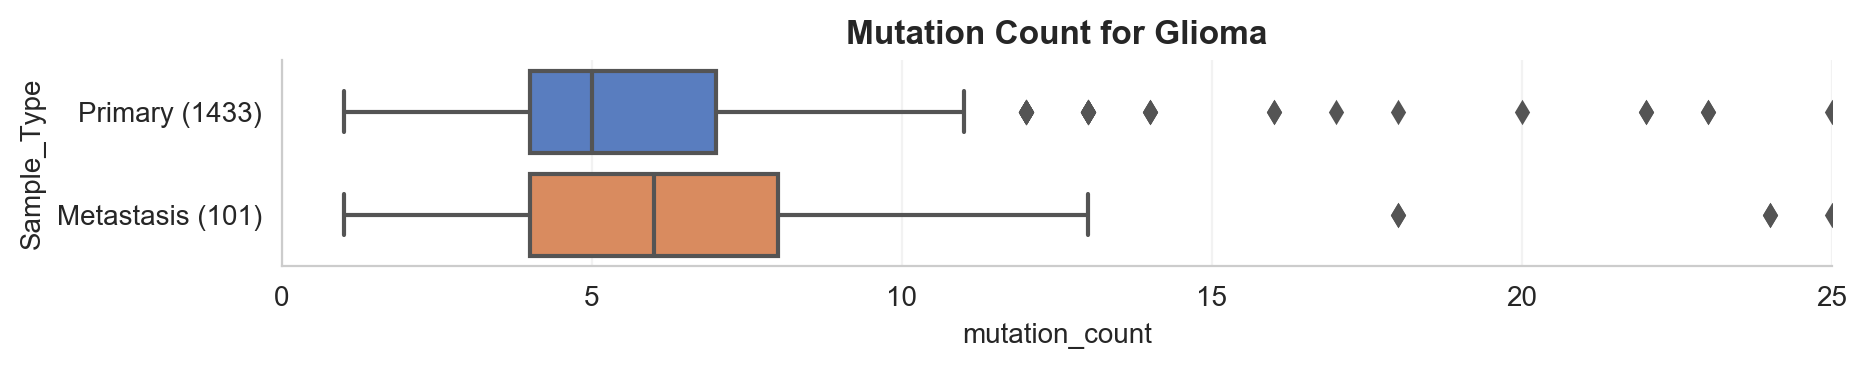

In [52]:
fig, ax = boxplot_sampletype(master_cancer, 'mutation_count', figsize= (10,3), title='Mutation Count for '+cancer_type, title_font=12, xlim=[0,25])

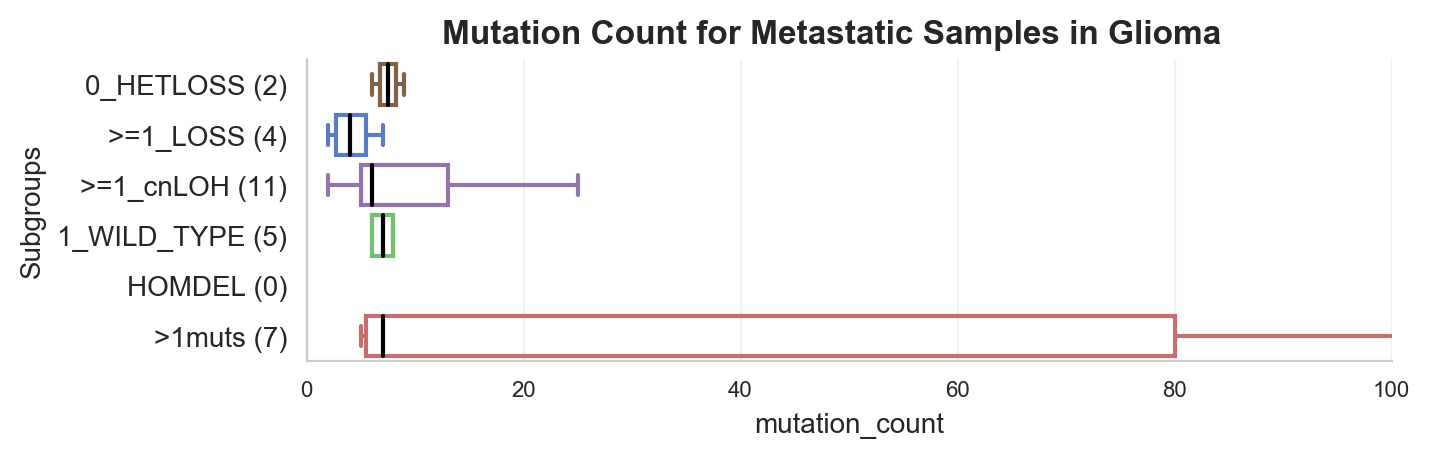

In [53]:
fig, ax = plot_mut_count_subgroups(master_cancer, 
                         cancer_type, 
                         metrics='mutation_count', 
                         title= 'Mutation Count for Metastatic Samples in ' + cancer_type, 
                         figsize = (7, 2),  
                         xlim=100, 
                         met_prim = 'Metastasis')

plt.show(fig)

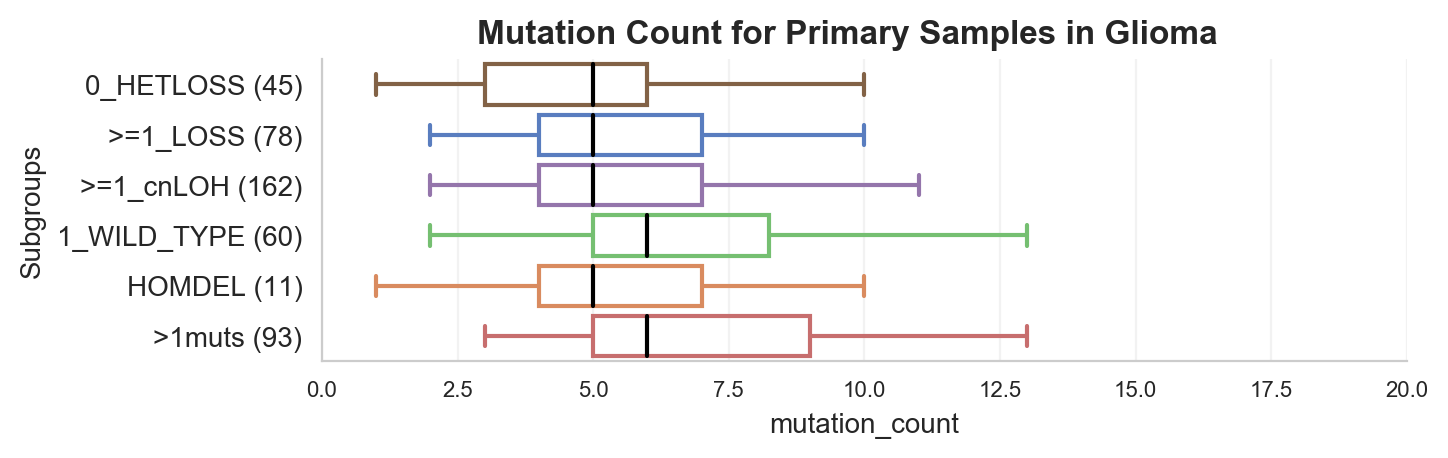

In [54]:
fig, ax = plot_mut_count_subgroups(master_cancer, 
                         cancer_type, 
                         metrics='mutation_count', 
                         title= 'Mutation Count for Primary Samples in ' + cancer_type, 
                         figsize = (7, 2),  
                         xlim=20, 
                         met_prim = 'Primary')

plt.show(fig)

## Tumor Mutational Burden

## MSI Score

## TP53 Metrics

### Hotspot distribution

            count
tp53_spots       
248            27
273            19
175            17
342            14
280            13
220            11
285            11
176            11
196            10
245            10
306            10
241             8
213             8
337             7
282             7
194             6
271             6
272             6
274             6
163             6
180             5
262             5
179             5
287             5
286             5
135             5
255             5
249             5
172             5
192             5
195             5
270             4
339             4
127             4
193             4
278             4
242             4
141             4
133             4
146             4
132             4
237             4
204             4
215             3
236             3
259             3
73              3
113             3
209             3
244             3
110             3
205             3
246             3
134       

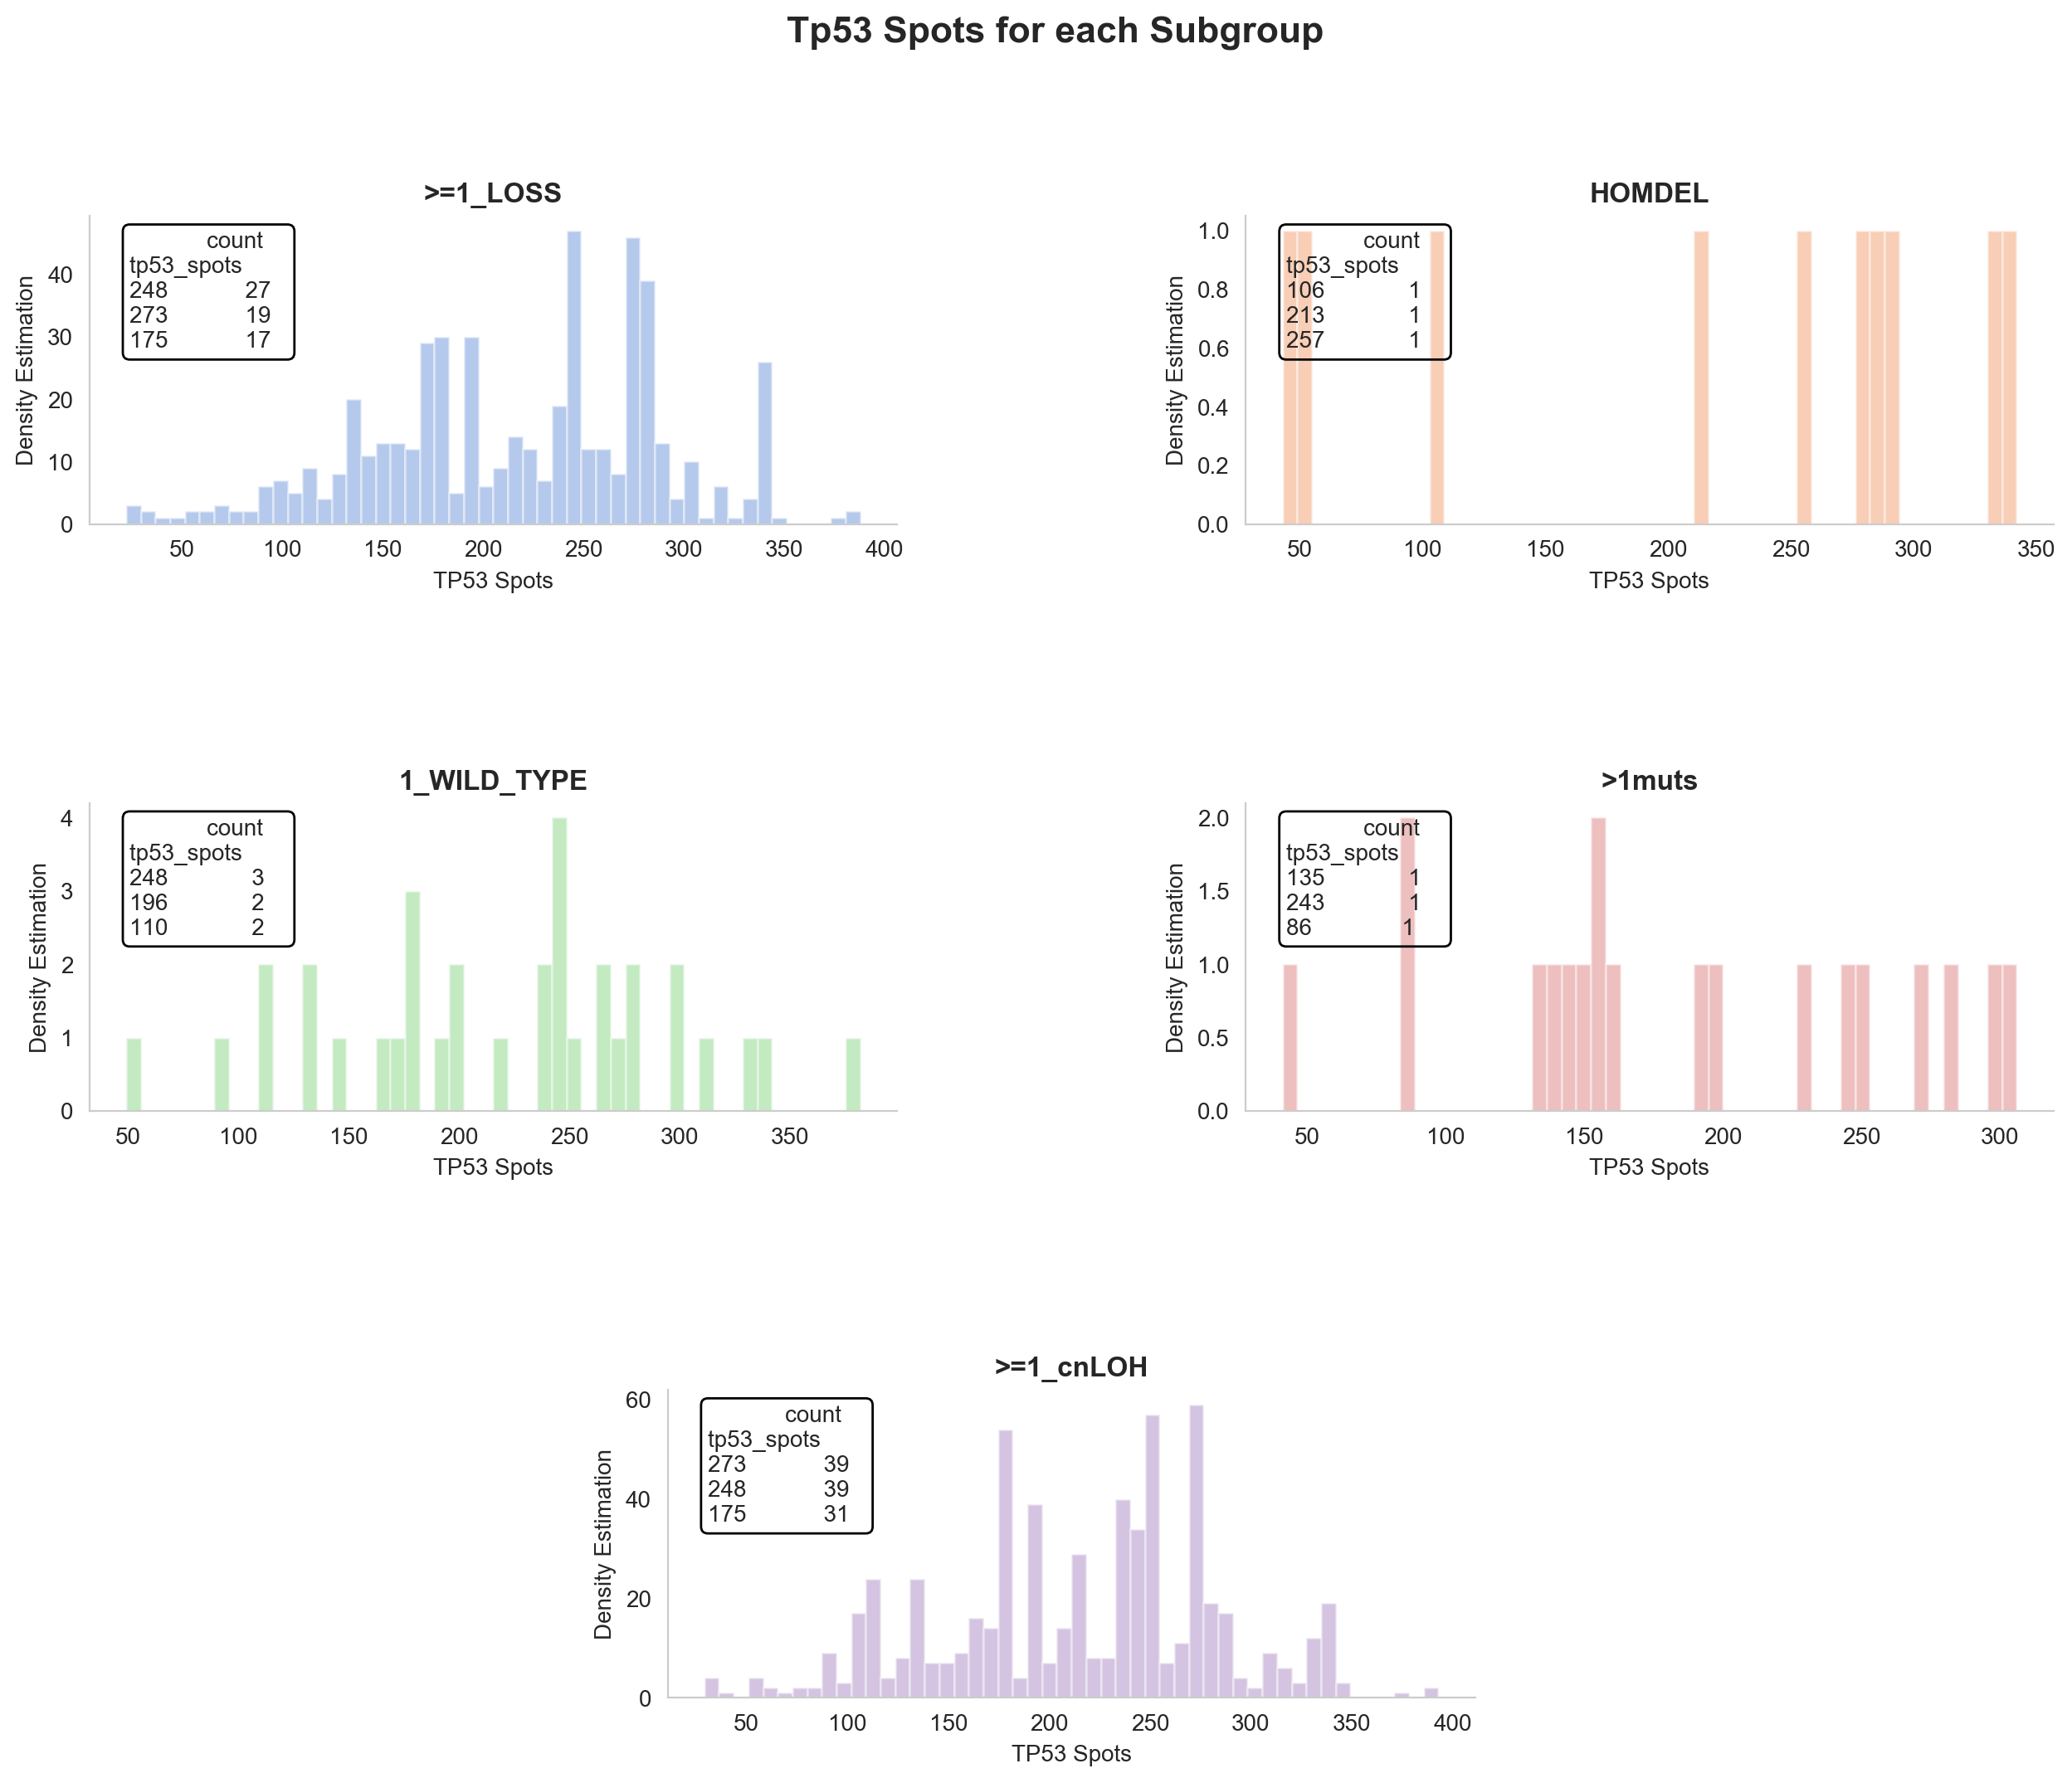

In [79]:
fig = def_fig_set(number = 5)
fig.tight_layout(pad=10, w_pad=0.5, h_pad=10)
fig.suptitle('Tp53 Spots for each Subgroup', fontsize=16, weight='bold')

groups = ['>=1_LOSS', 'HOMDEL', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '0_HETLOSS']
for ax, subgroup,i in zip(fig.axes, groups, range(len(groups))):
    data = master_cancer[master_cancer['tp53_group'] == subgroup]
    
    data_spots = list(data['tp53_spot_1']) + list(data['tp53_spot_2']) + list(data['tp53_spot_3']) + list(data['tp53_spot_4']) + list(data['tp53_spot_5'])
    data_spot_df = pd.DataFrame(data_spots, columns=['tp53_spots']).dropna()
    data_spot_df = data_spot_df[data_spot_df['tp53_spots'] !='nan']
    count = pd.DataFrame(data_spot_df.groupby(['tp53_spots']).size(), columns=['count']).sort_values(by=['count'], ascending=False)
    print(count)
    #count.index = count.index.drop('nan')
    count = pd.DataFrame(count, index = count.index).head(3)
    
    sns.distplot(data_spot_df, bins=50, kde=False, color=my_colors[i], ax=ax)
    ax.set_xlabel('TP53 Spots')
    ax.set_ylabel('Density Estimation')
    ax.set_title(subgroup, weight = 'bold')
    ax.text(.05, .95, str(count), transform=ax.transAxes, ha="left", va="top", bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

### Mutation Type

count_tp53_vc_group
tp53_vc_group                     
missense                       817
truncated                      606
in_frame                        50

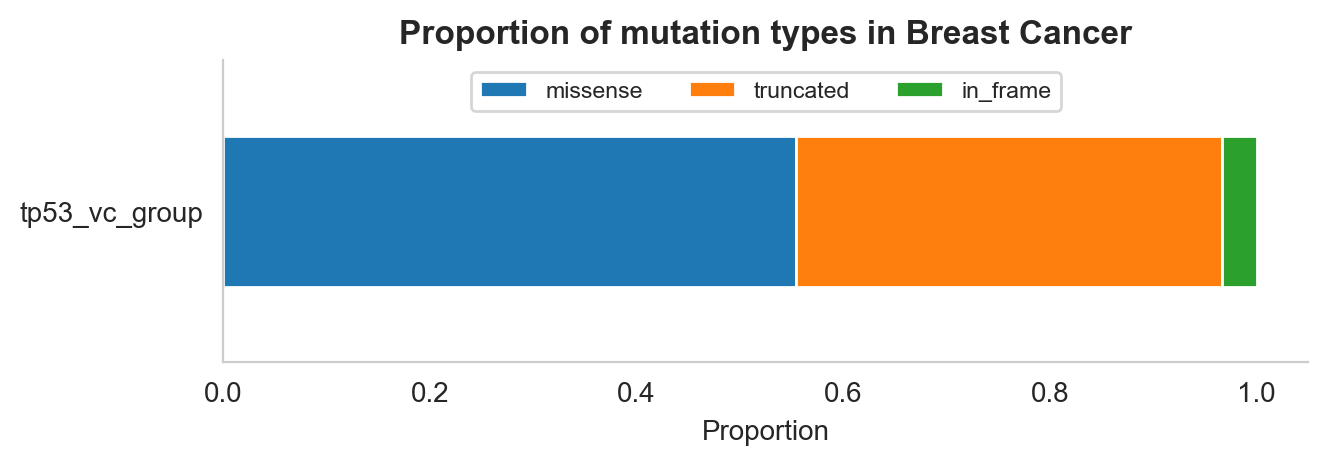

In [80]:
fig, ax = proportion_plot(master_cancer, 
                        metrics='tp53_vc_group',
                        title= 'Proportion of mutation types in ' + cancer_type,
                        figsize=(7,2),
                        display_table=True,
                        tp53_metrics=True,
                        ncol_legend =3)

175  248  273  hotspot  in_frame  missense  truncated  175_r  \
>=1_LOSS       1    3    1        2         3        18         17  0.022   
>=1_cnLOH      3    3    1        4         0        19         20  0.060   
1_WILD_TYPE    0    0    0        1         0         1          1  0.000   
HOMDEL         0    0    0        0         0         1          0  0.000   
>1muts         0    1    0        0         0        10         10  0.000   

             248_r  273_r  hotspot_r  in_frame_r  missense_r  truncated_r  
>=1_LOSS     0.067  0.022      0.044       0.067       0.400        0.378  
>=1_cnLOH    0.060  0.020      0.080       0.000       0.380        0.400  
1_WILD_TYPE  0.000  0.000      0.333       0.000       0.333        0.333  
HOMDEL       0.000  0.000      0.000       0.000       1.000        0.000  
>1muts       0.048  0.000      0.000       0.000       0.476        0.476

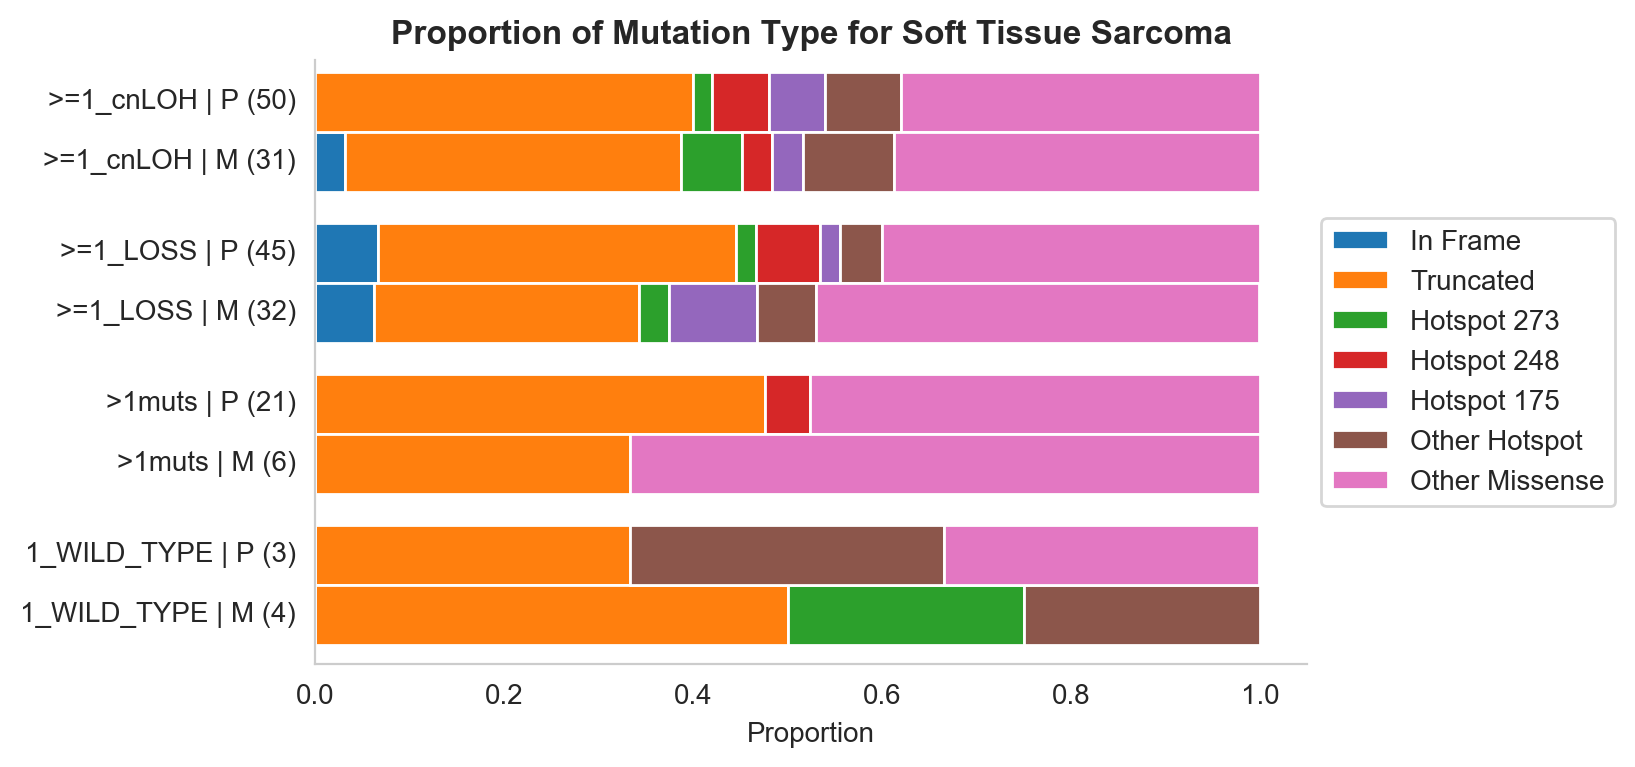

In [543]:
mut_subgroups = ['>=1_LOSS', '>=1_cnLOH', '1_WILD_TYPE', 'HOMDEL', '>1muts']
for subgroup in mut_subgroups:
    data_prim = master_cancer[master_cancer['tp53_group'] == subgroup][master_cancer['Sample_Type'] == 'Primary']
    data_met = master_cancer[master_cancer['tp53_group'] == subgroup][master_cancer['Sample_Type'] == 'Metastasis']
    data_1p = get_groupby(data_prim,'tp53_vc_group_1', 'count'); data_2p = get_groupby(data_prim,'tp53_vc_group_2', 'count'); data_3p = get_groupby(data_prim,'tp53_vc_group_3', 'count') ; data_4p = get_groupby(data_prim,'tp53_vc_group_4', 'count') ; data_5p = get_groupby(data_prim,'tp53_vc_group_5', 'count') 
    data_1m = get_groupby(data_met,'tp53_vc_group_1', 'count'); data_2m = get_groupby(data_met,'tp53_vc_group_2', 'count'); data_3m = get_groupby(data_met,'tp53_vc_group_3', 'count') ; data_4m = get_groupby(data_met,'tp53_vc_group_4', 'count') ; data_5m = get_groupby(data_met,'tp53_vc_group_5', 'count') 
    series_p = [data_1p,data_2p,data_3p,data_4p,data_5p]
    series_m = [data_1m,data_2m,data_3m,data_4m,data_5m]
    for i in range(len(series_p)):
        for line in ['175', '248', '273', 'hotspot', 'in_frame', 'missense', 'truncated']:
            if line not in list(series_p[i].index):
                series_p[i] = series_p[i].append(pd.Series({'count': 0}, name=line))
    for i in range(len(series_m)):
        for line in ['175', '248', '273', 'hotspot', 'in_frame', 'missense', 'truncated']:
            if line not in list(series_m[i].index):
                series_m[i] = series_m[i].append(pd.Series({'count': 0}, name=line))
    count_p = series_p[0].add(series_p[1]).add(series_p[2]).add(series_p[3]).add(series_p[4])
    count_m = series_m[0].add(series_m[1]).add(series_m[2]).add(series_m[3]).add(series_m[4])
    count_m.columns=[subgroup] ; count_p.columns=[subgroup]
    if subgroup == '>=1_LOSS': countm = count_m ; countp = count_p
        
    else: countm = pd.concat([countm, count_m], axis=1) ; countp = pd.concat([countp, count_p], axis=1)
        
countm = countm.T.fillna(0) ; countp = countp.T.fillna(0)

columns_m = list(countm.columns)
columns_p = list(countp.columns)

for column in columns_m:
    countm[column + '_r'] = countm.apply(lambda x: round(x[column]/x[columns_m].sum(),3), axis=1)
for column in columns_p:   
    countp[column + '_r'] = countp.apply(lambda x: round(x[column]/x[columns_p].sum(),3), axis=1)
display(countp)
countp['sum_p'] = countp[columns_p].sum(axis=1) ; countm['sum_m'] = countm[columns_m].sum(axis=1)
countm = countm.set_index(pd.Series(['>=1_LOSS | M', '>=1_cnLOH | M', '1_WILD_TYPE | M', 'HOMDEL | M', '>1muts | M']))
countp = countp.set_index(pd.Series(['>=1_LOSS | P', '>=1_cnLOH | P', '1_WILD_TYPE | P', 'HOMDEL | P', '>1muts | P']))

count = pd.concat([countp, countm], axis=0).fillna(0)
count = count.reindex(['1_WILD_TYPE | P','1_WILD_TYPE | M', '>1muts | P', '>1muts | M'
                       ,'>=1_LOSS | P','>=1_LOSS | M', '>=1_cnLOH | P', '>=1_cnLOH | M',
                        'HOMDEL | P','HOMDEL | M'])

count = count.drop(['HOMDEL | P', 'HOMDEL | M'])

for column in ['in_frame_r','truncated_r', '273_r', '248_r', '175_r','hotspot_r', 'missense_r']:
    if column not in list(count.columns):
        count[column] = [0]*8
#df = count[['in_frame_r','truncated_r', '273_r', '248_r', '175_r','hotspot_r', 'missense_r']]

fig, ax = get_mstacked_plot(count[['in_frame_r','truncated_r', '273_r', '248_r', '175_r','hotspot_r', 'missense_r']], 
                  'Proportion of Mutation Type for ' + cancer_type,
                  ['In Frame', 'Truncated', 'Hotspot 273','Hotspot 248','Hotspot 175', 'Other Hotspot', 'Other Missense'],
                  'Proportion',
                  'Subgroups',
                  figsize = (8,4),
                  horiz=True)

        


ax.set_ylabel('')

for container in ax.containers:
    for i, child in enumerate(container.get_children()):
        child.set_height(0.8)
        if i%2 == 1:
            child.set_y(child.get_y() - 0.2)
     
for container in ax.containers:
    for i, child in enumerate(container.get_children()):
        if i%2 == 1: child.set_y(child.get_y() - child.get_height())  
        if i%2 == 0: child.set_y(child.get_y() + child.get_height())

try:
        ax.set_yticklabels(['1_WILD_TYPE | P ('+ str(int(count.loc['1_WILD_TYPE | P', 'sum_p'])) + ')',
                            '1_WILD_TYPE | M ('+ str(int(count.loc['1_WILD_TYPE | M', 'sum_m'])) + ')',
                            '>1muts | P ('+ str(int(count.loc['>1muts | P', 'sum_p'])) + ')',
                            '>1muts | M ('+ str(int(count.loc['>1muts | M', 'sum_m'])) + ')',
                            '>=1_LOSS | P ('+ str(int(count.loc['>=1_LOSS | P', 'sum_p'])) + ')',
                            '>=1_LOSS | M ('+ str(int(count.loc['>=1_LOSS | M', 'sum_m'])) + ')',
                            '>=1_cnLOH | P ('+ str(int(count.loc['>=1_cnLOH | P', 'sum_p'])) + ')',
                            '>=1_cnLOH | M ('+ str(int(count.loc['>=1_cnLOH | M', 'sum_m'])) + ')'],
                             fontsize=10)
except: pass


ax.set_yticks([1, 0.2, 3,2.2, 5, 4.2, 7, 6.2])

# Clinical

## Age

"fig, ax = boxplot_sampletype(master_cancer_age, \n                             'Patient_Current_Age', \n                             figsize= (10,3), \n                             title='Patient Age distribution in ' + cancer_type, \n                             title_font=12,\n                             tp53_metrics=False,\n                             xlim=[0,1.2])"

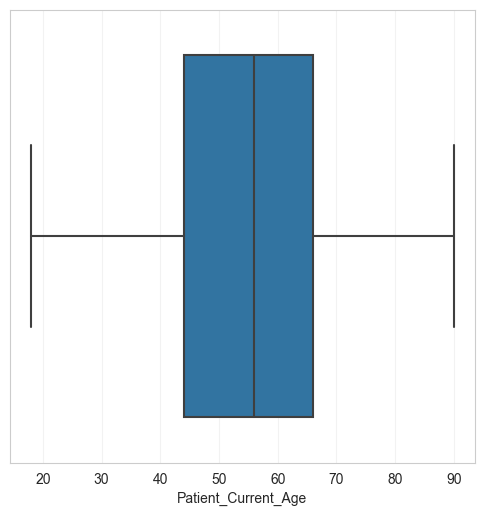

In [18]:
master_cancer_age = master_cancer.dropna(subset=['Patient_Current_Age'])


h = sns.boxplot(data=master_cancer,x='Patient_Current_Age', hue='Sample_Type', dodge=True)

'''fig, ax = boxplot_sampletype(master_cancer_age, 
                             'Patient_Current_Age', 
                             figsize= (10,3), 
                             title='Patient Age distribution in ' + cancer_type, 
                             title_font=12,
                             tp53_metrics=False,
                             xlim=[0,1.2])'''

## Sex

count_Sex
Sex              
Female       3930
Male           36

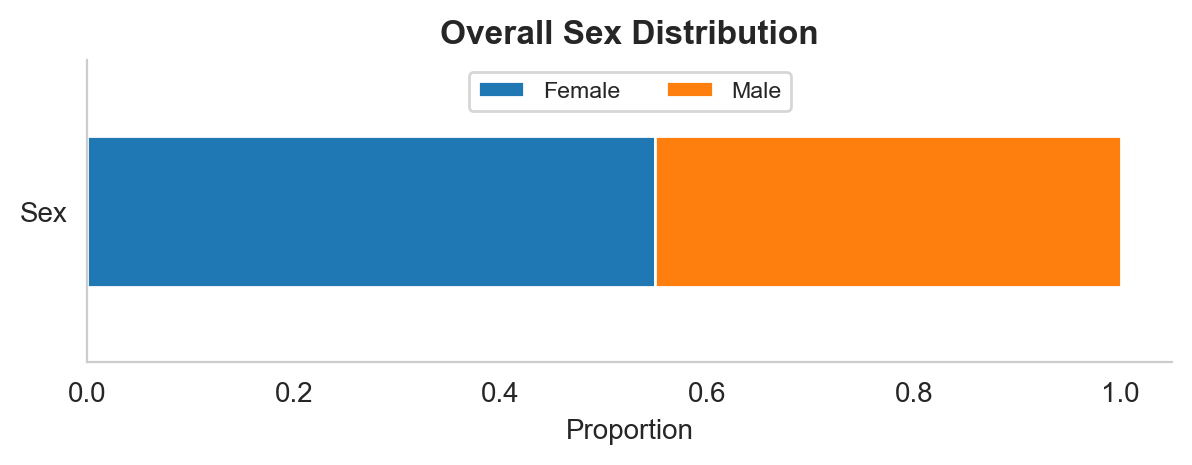

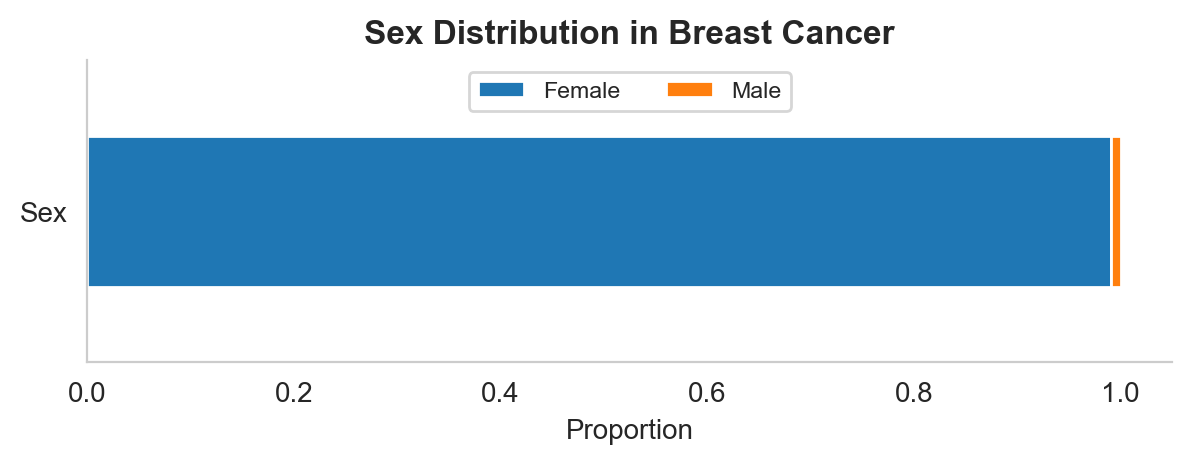

In [83]:
fig, ax = proportion_plot(master, 
                metrics='Sex',
                title= 'Overall Sex Distribution',
                figsize=(7,2),
                display_table=False, 
                ncol_legend =6)

fig, ax = proportion_plot(master_cancer, 
                metrics='Sex',
                title= 'Sex Distribution in ' + cancer_type,
                figsize=(7,2),
                display_table=True, 
                ncol_legend =6)

count_Race_Category
Race_Category                                      
WHITE                                         21233
ASIAN-FAR EAST/INDIAN SUBCONT                  1914
BLACK OR AFRICAN AMERICAN                      1796
PT REFUSED TO ANSWER                            932
OTHER                                           711
NO VALUE ENTERED                                567
UNKNOWN                                         143
NATIVE AMERICAN-AM IND/ALASKA                    51
NATIVE HAWAIIAN OR PACIFIC ISL                   10

count_Race_Category
Race_Category                                     
WHITE                                         2889
BLACK OR AFRICAN AMERICAN                      365
ASIAN-FAR EAST/INDIAN SUBCONT                  273
OTHER                                          140
PT REFUSED TO ANSWER                           136
NO VALUE ENTERED                               127
UNKNOWN                                         30
NATIVE AMERICAN-AM IND/ALASKA                    6

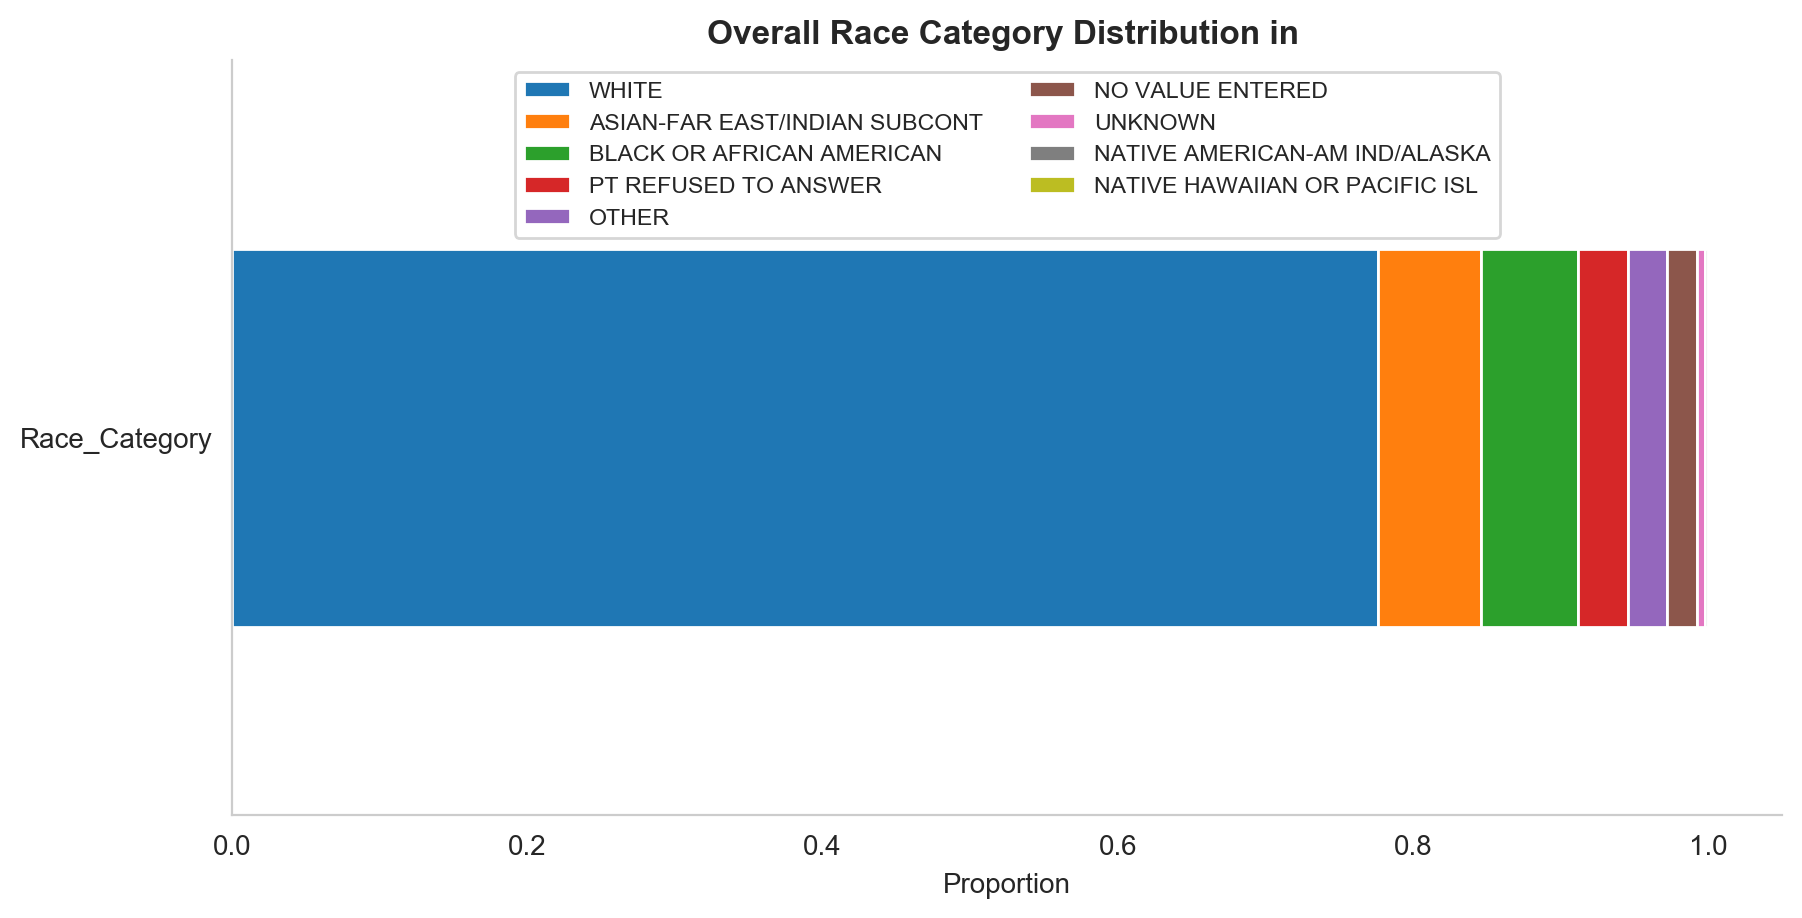

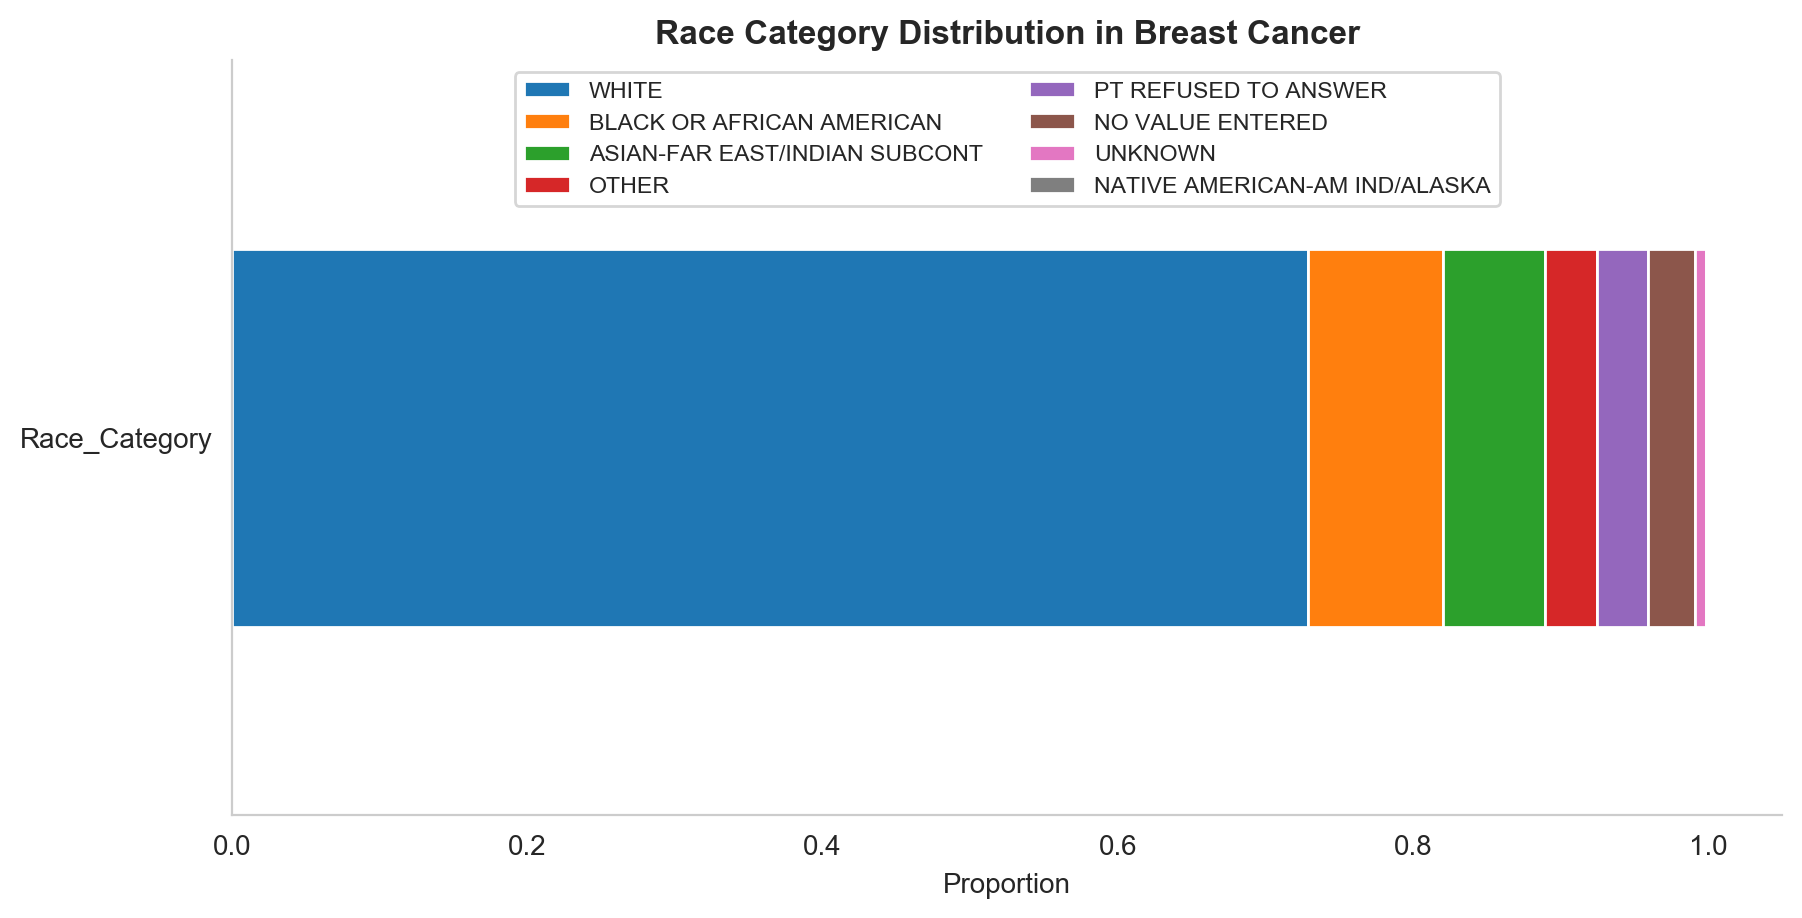

In [87]:
fig, ax = proportion_plot(master, 
                metrics='Race_Category',
                title= 'Overall Race Category Distribution in ',
                figsize=(10,5),
                display_table=True, 
                ncol_legend =2)

fig, ax = proportion_plot(master_cancer, 
                metrics='Race_Category',
                title= 'Race Category Distribution in ' + cancer_type,
                figsize=(10,5),
                display_table=True, 
                ncol_legend =2)

# Cancer Summary

In [71]:
def plot_scatters(data: pd.DataFrame, title:str, metrics: str, ax, met_prim=False):
    data = data[data['tp53_count']>=2]
    if met_prim:
        data = data[data['Sample_Type'] == met_prim]
    data_ccf = data[[metrics + '_1', metrics + '_2',metrics + '_3',metrics + '_4',metrics + '_5']]
    max_table_ccf = pd.DataFrame(np.sort(data_ccf.fillna(0).values)[:,-2:], columns=['2nd-largest','largest'])
    max_table_ccf = pd.concat([max_table_ccf, data.reset_index().tp53_group], axis=1)
    
    sns.scatterplot(x='largest', y='2nd-largest', data=max_table_ccf, ax=ax, hue='tp53_group', palette=palette, legend=False, s=100)
    ax.plot([0,1], [0,1], linewidth=0.5, color='grey')
    ax.set_ylabel('')
    ax.set_xlabel('')
    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    ax.set_title(title, weight = 'bold', fontsize=20)
    ax.text(.5,.9, str(data.shape[0]) +' samples',
        horizontalalignment='center',
        transform=ax.transAxes, fontsize=18)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
def boxplot_sampletype(df: pd.DataFrame, metrics: str, ax, title: str = '',tp53_metrics=False, title_font: int=20, xlim=[0,1], continuous= False, legend=True):
    groupby = get_groupby(df, 'Sample_Type', 'count')

    if tp53_metrics:
        groupby= get_groupby(df[~df[metrics + '_1'].isna()], 'Sample_Type', 'count')
        data_1 =  pd.DataFrame(df[['Tumor_Id', metrics + '_1']])
        data_1.columns = ['Tumor_Id', metrics]
        data_2 = pd.DataFrame(df[['Tumor_Id', metrics + '_2']])
        data_2.columns = ['Tumor_Id', metrics]
        data_3 = pd.DataFrame(df[['Tumor_Id', metrics + '_3']])
        data_3.columns = ['Tumor_Id', metrics]
        data_4 = pd.DataFrame(df[['Tumor_Id', metrics + '_4']])
        data_4.columns = ['Tumor_Id', metrics]
        data_5 = pd.DataFrame(df[['Tumor_Id', metrics + '_5']])
        data_5.columns = ['Tumor_Id', metrics]
        data_tot = data_1.append(data_2)
        data_tot = data_tot.append(data_3)
        data_tot = data_tot.append(data_4)
        data_tot = data_tot.append(data_5)

        df = pd.merge(left=data_tot, right=df[['Tumor_Id','tp53_cn_state', 'tp53_tcn', 'Sample_Type']],how='left', left_on='Tumor_Id',right_on='Tumor_Id')
        data_cancer_prim = df[df['Sample_Type'] == 'Primary'][~df[metrics].isna()]
        data_cancer_met = df[df['Sample_Type'] == 'Metastasis'][~df[metrics].isna()]
        numbers = [data_cancer_prim.shape[0], data_cancer_met.shape[0]]
    if continuous == True:
        statistic, p_value = ranksums(df[df['Sample_Type'] == 'Primary'][metrics].dropna().values,df[df['Sample_Type'] == 'Metastasis'][metrics].dropna().values)
        if p_value<=0.001: s='***'
        elif p_value<=0.01: s='**'
        elif p_value<=0.05: s='*'
        elif p_value>0.05: s=''
        else: s=''
        ax.annotate(s=s, xy=(1,0.4), xycoords='axes fraction', fontsize=20)
    
    else:
        statistic, p_value = ranksums(df[df['Sample_Type'] == 'Primary'][metrics].dropna().values,df[df['Sample_Type'] == 'Metastasis'][metrics].dropna().values)
        if p_value<=0.001: s='***'
        elif p_value<=0.01: s='**'
        elif p_value<=0.05: s='*'
        elif p_value>0.05: s=''
        else: s=''
        ax.annotate(s=s, xy=(1,0.4), xycoords='axes fraction', fontsize=20)
    
    
    
    if continuous: sns.violinplot(x=metrics, y='Sample_Type',data=df,ax=ax, inner='quartile', dodge=False,order=['Primary', 'Metastasis'], palette='muted').set_title(title, weight='bold', fontsize=title_font)
    else: h=sns.boxplot(x=metrics, y='Sample_Type',data=df,ax=ax, dodge=False,order=['Primary', 'Metastasis'], palette='muted', showfliers=False).set_title(title, weight='bold', fontsize=title_font)
    
    if tp53_metrics:
        try:
            ax.set_yticklabels(['P (' + str(numbers[0]) + ')',
                                'M (' + str(numbers[1]) + ')'], 
                                fontsize=18)
        except: pass
    else: 
        try:
            ax.set_yticklabels(['P (' + str(int(groupby.loc['Primary'])) + ')',
                                'M (' + str(int(groupby.loc['Metastasis'])) + ')'], 
                                fontsize=18)
        except: pass

    ax.set_xlim(xlim)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
        
    if legend == False:
        ax.axes.get_yaxis().set_ticks([])
    
    '''for i, artist in enumerate(ax.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        artist.set_edgecolor('black')
        print(ax.lines)
        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i * 6, i * 6 + 6):
            line = ax.lines[j]
            if j % 6 == 4: line.set_color('black')
            else: line.set_color('black')'''



def plot_mut_count_subgroups(df: pd.DataFrame, ax1, cancer_type: str, metrics: str, title: str = '',  xlim: int=25, met_prim = None, continuous=False, tp53_metrics=False, linewidth=1, width=1, hue=False, legend=True, colors=False, tp53_res_group=False):
    
    res_group_list = ['no_tp53_res','tp53_res', 'uncertain']
    palette_res = ['#1E8449','#2ECC71',  '#7F8C8D']
    
    # Figure initialization
    if met_prim:
        df = df[df['Sample_Type'] == met_prim]

    ax1.set_xlim(0, xlim)
    ax1.tick_params(axis='both', which='major', labelsize=8)

    my_colors = list(islice(cycle(list(sns.color_palette("muted"))), None, 6))
    my_colors_remixed = [my_colors[5], my_colors[2], my_colors[3], my_colors[0], my_colors[4], my_colors[1]]
    my_colors_remixed_hue = [my_colors[5],my_colors[5], my_colors[2], my_colors[2],my_colors[3], my_colors[3],
                             my_colors[0],my_colors[0], my_colors[4],my_colors[4], my_colors[1], my_colors[1]]
    
    
    data = df
    data_cancer = data[data['Cancer_Type'] == cancer_type]

    if tp53_metrics:
        groupby= get_groupby(data_cancer[~data_cancer[metrics + '_1'].isna()], 'tp53_group', 'count')
        groupby_prim = get_groupby(data_cancer[data_cancer['Sample_Type'] == 'Primary'][~data_cancer[metrics + '_1'].isna()], 'tp53_group', 'count') 
        groupby_met = get_groupby(data_cancer[data_cancer['Sample_Type'] == 'Metastasis'][~data_cancer[metrics + '_1'].isna()], 'tp53_group', 'count')
        groupby = groupby.to_dict()['count'] ; groupby_prim = groupby_prim.to_dict()['count'] ; groupby_met = groupby_met.to_dict()['count']
        data_1 =  pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_1']])
        data_1.columns = ['Tumor_Id', metrics]
        data_2 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_2']])
        data_2.columns = ['Tumor_Id', metrics]
        data_3 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_3']])
        data_3.columns = ['Tumor_Id', metrics]
        data_4 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_4']])
        data_4.columns = ['Tumor_Id', metrics]
        data_5 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_5']])
        data_5.columns = ['Tumor_Id', metrics]
        data_tot = data_1.append(data_2)
        data_tot = data_tot.append(data_3)
        data_tot = data_tot.append(data_4)
        data_tot = data_tot.append(data_5)

        data_cancer = pd.merge(left=data_tot, right=data_cancer[['Tumor_Id','tp53_group', 'tp53_tcn', 'Sample_Type']],how='left', left_on='Tumor_Id',right_on='Tumor_Id')
        
        data_cancer_prim = data_cancer[data_cancer['Sample_Type'] == 'Primary'][~data_cancer[metrics].isna()]
        data_cancer_met = data_cancer[data_cancer['Sample_Type'] == 'Metastasis'][~data_cancer[metrics].isna()]
        groupby_met = get_groupby(data_cancer_met, 'tp53_group', 'count')
        groupby_prim = get_groupby(data_cancer_prim, 'tp53_group', 'count')
        groupby_prim = groupby_prim.to_dict()['count'] ; groupby_met = groupby_met.to_dict()['count']
        
    else:
        if tp53_res_group:
            groupby = get_groupby(data_cancer, 'tp53_res_group', 'count') 
            groupby_prim = get_groupby(data_cancer[data_cancer['Sample_Type'] == 'Primary'], 'tp53_res_group', 'count') 
            groupby_met = get_groupby(data_cancer[data_cancer['Sample_Type'] == 'Metastasis'], 'tp53_res_group', 'count')
            groupby = groupby.to_dict()['count'] ; groupby_prim = groupby_prim.to_dict()['count'] ; groupby_met = groupby_met.to_dict()['count']
        else:
            groupby = get_groupby(data_cancer, 'tp53_group', 'count') 
            groupby_prim = get_groupby(data_cancer[data_cancer['Sample_Type'] == 'Primary'], 'tp53_group', 'count') 
            groupby_met = get_groupby(data_cancer[data_cancer['Sample_Type'] == 'Metastasis'], 'tp53_group', 'count')
            groupby = groupby.to_dict()['count'] ; groupby_prim = groupby_prim.to_dict()['count'] ; groupby_met = groupby_met.to_dict()['count']

    if tp53_res_group:
        for groupbys in [groupby, groupby_prim, groupby_met]:
            for group in res_group_list:
                if group not in groupbys: groupbys[group] = 0
        desired_order_list = res_group_list
        groupby_prim = {k: groupby_prim[k] for k in desired_order_list}
        groupby_met = {k: groupby_met[k] for k in desired_order_list}


    else:  
        for groupbys in [groupby, groupby_prim, groupby_met]:
            for group in ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']:
                if group not in groupbys: groupbys[group] = 0
                    
        desired_order_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']
        groupby_prim = {k: groupby_prim[k] for k in desired_order_list}
        groupby_met = {k: groupby_met[k] for k in desired_order_list}

    if continuous:
        if hue == True: 
            h=sns.violinplot(y="tp53_group",
                    x=metrics,
                    data=data_cancer,
                    ax=ax1,
                    dodge=False,
                    hue='Sample_Type',
                    split=True,
                    cut=0,
                    inner="quartile",
                    palette=['#D5DBDB', '#95A5A6'],
                    order=['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL'],
                    hue_order=['Primary', 'Metastasis'],
                    linewidth=linewidth, 
                    width=width,
                    legend_out=False)
            #patch_violinplot(my_colors_remixed_hue, ax1, groupby_met, groupby_prim)
        else:
            h=sns.violinplot(y="tp53_group",
                    x=metrics,
                    data=data_cancer,
                    ax=ax1,
                    dodge=False,
                    split=True,
                    inner="quartile",
                    palette=my_colors_remixed,
                    order=['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL'],
                    linewidth=linewidth, 
                    width=width).set_title(title, weight='bold', fontsize=20)

    else:
        if hue==True:
            if tp53_res_group:
                h=sns.boxplot(y="tp53_res_group",
                        x=metrics,
                        data=data_cancer,
                        ax=ax1,
                        dodge=True,
                        hue='Sample_Type',
                        hue_order=['Primary', 'Metastasis'],
                        palette=['#D5DBDB', '#95A5A6'],
                        order=res_group_list)
            
            else:
                h=sns.boxplot(y="tp53_group",
                        x=metrics,
                        data=data_cancer,
                        ax=ax1,
                        dodge=True,
                        hue='Sample_Type',
                        hue_order=['Primary', 'Metastasis'],
                        palette=['#D5DBDB', '#95A5A6'],
                        order=['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL'])
            
        else:
            h=sns.boxplot(y="tp53_group",
                    x=metrics,
                    data=data_cancer,
                    ax=ax1,
                    dodge=False,
                    palette=my_colors_remixed,
                    order=['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']
                         ).set_title(title, weight='bold', fontsize=20)

    ax1.set_xlabel('')
    ax1.set_ylabel('')
    if hue:
        if tp53_res_group:
            ax1.set_yticklabels(['no_tp53_res: P ' + str(int(groupby_prim['no_tp53_res'])) + '\nM '+str(int(groupby_met['no_tp53_res'])),
                                 'tp53_res: P '+ str(int(groupby_prim['tp53_res']))+ '\nM '+str(int(groupby_met['tp53_res'])),
                                 'uncertain: P '+ str(int(groupby_prim['uncertain']))+ '\nM '+str(int(groupby_met['uncertain']))
                                 ], fontsize=18)
            
        else:
            ax1.set_yticklabels(['0_HETLOSS: P ' + str(int(groupby_prim['0_HETLOSS'])) + '\nM '+str(int(groupby_met['0_HETLOSS'])),
                                 '1_WILD_TYPE: P '+ str(int(groupby_prim['1_WILD_TYPE']))+ '\nM '+str(int(groupby_met['1_WILD_TYPE'])),
                                 '>1muts: P '+ str(int(groupby_prim['>1muts']))+ '\nM '+str(int(groupby_met['>1muts'])),
                                 '>=1_LOSS: P '+ str(int(groupby_prim['>=1_LOSS']))+ '\nM '+str(int(groupby_met['>=1_LOSS'])),
                                 '>=1_cnLOH: P '+ str(int(groupby_prim['>=1_cnLOH']))+ '\nM '+str(int(groupby_met['>=1_cnLOH'])),
                                 'HOMDEL: P '+ str(int(groupby_prim['HOMDEL']))+ '\nM '+str(int(groupby_met['HOMDEL'])),
                                  ], fontsize=18)
        ax1.legend_.remove()
        ax1.set_title(title, weight='bold', fontsize=20)
            
    
    else:   
        try:
            ax1.set_yticklabels(['0_HETLOSS (' + str(int(groupby['0_HETLOSS'])) + ')',
                                 '1_WILD_TYPE ('+ str(int(groupby['1_WILD_TYPE'])) + ')',
                                 '>1muts ('+ str(int(groupby['>1muts'])) + ')',
                                 '>=1_LOSS ('+ str(int(groupby['>=1_LOSS'])) + ')',
                                 '>=1_cnLOH ('+ str(int(groupby['>=1_cnLOH'])) + ')',
                                 'HOMDEL ('+ str(int(groupby['HOMDEL'])) + ')',
                                  ], fontsize=20)
        except: pass
    
    # Add significance
    if tp53_res_group == False:
        for i,group in enumerate(['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']):
            master_group = data_cancer[data_cancer['tp53_group'] == group]
            statistic, p_value = ranksums(master_group[master_group['Sample_Type'] == 'Primary'][metrics].dropna().values,master_group[master_group['Sample_Type'] == 'Metastasis'][metrics].dropna().values)
            if p_value<=0.001: s='***'
            elif p_value<=0.01: s='**'
            elif p_value<=0.05: s='*'
            elif p_value>0.05: s=''
            else: s=''
            if continuous == True:
                ax1.annotate(s=s, xy=(1,0.9 - (1/6)*i), xycoords='axes fraction', fontsize=20)
            else:
                ax1.annotate(s=s, xy=(1.,0.9 - (1/6)*i), xycoords='axes fraction', fontsize=20)
    else:
        for i,group in enumerate(res_group_list):
            master_group = data_cancer[data_cancer['tp53_res_group'] == group]
            statistic, p_value = ranksums(master_group[master_group['Sample_Type'] == 'Primary'][metrics].dropna().values,master_group[master_group['Sample_Type'] == 'Metastasis'][metrics].dropna().values)
            if p_value<=0.001: s='***'
            elif p_value<=0.01: s='**'
            elif p_value<=0.05: s='*'
            elif p_value>0.05: s=''
            else: s=''
            if continuous == True:
                ax1.annotate(s=s, xy=(1,0.8 - (1/3)*i), xycoords='axes fraction', fontsize=20)
            else:
                ax1.annotate(s=s, xy=(1.,0.8 - (1/3)*i), xycoords='axes fraction', fontsize=20)
        
        # adding p_values for tp53_res VS no_tp53_res AND tp53_res VS uncertain
        statistic, p_value_prim = ranksums(data_cancer[data_cancer['tp53_res_group'] == 'tp53_res'][data_cancer['Sample_Type'] == 'Primary'][metrics].dropna().values, data_cancer[data_cancer['tp53_res_group'] == 'no_tp53_res'][data_cancer['Sample_Type'] == 'Primary'][metrics].dropna().values)
        statistic, p_value_met = ranksums(data_cancer[data_cancer['tp53_res_group'] == 'tp53_res'][data_cancer['Sample_Type'] == 'Metastasis'][metrics].dropna().values, data_cancer[data_cancer['tp53_res_group'] == 'no_tp53_res'][data_cancer['Sample_Type'] == 'Metastasis'][metrics].dropna().values)
        statistic, p_value_uprim = ranksums(data_cancer[data_cancer['tp53_res_group'] == 'tp53_res'][data_cancer['Sample_Type'] == 'Primary'][metrics].dropna().values, data_cancer[data_cancer['tp53_res_group'] == 'uncertain'][data_cancer['Sample_Type'] == 'Primary'][metrics].dropna().values)
        statistic, p_value_umet = ranksums(data_cancer[data_cancer['tp53_res_group'] == 'tp53_res'][data_cancer['Sample_Type'] == 'Metastasis'][metrics].dropna().values, data_cancer[data_cancer['tp53_res_group'] == 'uncertain'][data_cancer['Sample_Type'] == 'Metastasis'][metrics].dropna().values)
       
        if p_value_prim<=0.001: s='***'
        elif p_value_prim<=0.01: s='**'
        elif p_value_prim<=0.05: s='*'
        elif p_value_prim>0.05: s=''
        ax1.annotate(s=s, xy=(0, 0.88), xycoords='axes fraction', fontsize=20)
        if p_value_met<=0.001: s='***'
        elif p_value_met<=0.01: s='**'
        elif p_value_met<=0.05: s='*'
        elif p_value_met>0.05: s=''
        ax1.annotate(s=s, xy=(0, 0.74), xycoords='axes fraction', fontsize=20)
        '''if p_value_uprim<=0.001: s='***'
        elif p_value_uprim<=0.01: s='**'
        elif p_value_uprim<=0.05: s='*'
        elif p_value_uprim>0.05: s=''
        ax1.annotate(s=s, xy=(-0.28, 0.21), xycoords='axes fraction', fontsize=20)
        if p_value_umet<=0.001: s='***'
        elif p_value_umet<=0.01: s='**'
        elif p_value_umet<=0.05: s='*'
        elif p_value_umet>0.05: s=''
        ax1.annotate(s=s, xy=(-0.28, 0.01), xycoords='axes fraction', fontsize=20)'''
    
    style(ax1)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(17)
        
    if legend == False:
        ax1.axes.get_yaxis().set_ticks([])
    
    if colors == True:
        if tp53_res_group:
            color_list = ['#1E8449', '#1E8449', '#2ECC71', '#2ECC71', '#7F8C8D', '#7F8C8D']
            color_list_final = ['']*6
        else:
            color_list=[mc[5],mc[5],mc[2],mc[2],mc[3],mc[3],mc[0],mc[0],mc[4],mc[4],mc[1],mc[1]]
            color_list_final = ['']*12
            
        for i, key in enumerate(list(groupby_prim.keys())):
            if groupby_prim[key] != 0:
                color_list_final[2*i] = color_list[2*i]
        for i, key in enumerate(list(groupby_met.keys())):
            if groupby_met[key] != 0:
                color_list_final[2*i + 1] = color_list[2*i + 1]
        
        while '' in color_list_final: color_list_final.remove('')
        for i, artist in enumerate(ax1.artists):
            # Set the linecolor on the artist to the facecolor, and set the facecolor to None
            col = artist.get_facecolor()
            artist.set_edgecolor('black')
            artist.set_facecolor(color_list_final[i])

            # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour as above
            for j in range(i * 6, i * 6 + 6):
                line = ax1.lines[j]
                if j % 6 == 4: line.set_color('black')
                else: line.set_color('black')
                #line.set_mfc('None')
                #line.set_mec('None')

"plot_mut_count_subgroups(master_cancer_gi,\n                             ax1=ax,\n                             cancer_type=cancer_type, \n                             metrics='chr_affected', \n                             title= '', \n                             xlim=25, \n                             met_prim = None,\n                             hue=True,\n                             legend=True,\n                             continuous=False,\n                             colors=True,\n                             tp53_res_group= True)"

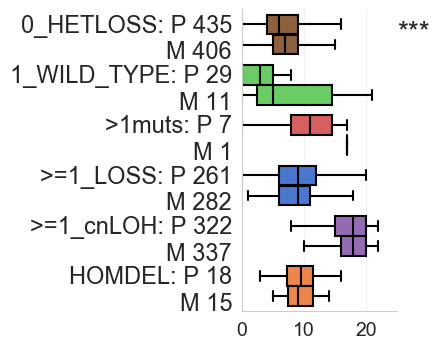

In [14]:
fig = plt.figure(figsize=(2,4))
ax = plt.subplot()

cancer_type = 'Breast Cancer'

master = load_clean_up_master(data_path + 'merged_data/master_file.pkl')
# we remover indeterminate and NA tp53_cn_state samples
master_cancer = master[master['Cancer_Type'] == cancer_type][master['tp53_cn_state'] != 'INDETERMINATE'][~master['tp53_cn_state'].isna()]
master_cancer_gi = master_cancer[master_cancer['chr_affected']!='NaN']



plot_mut_count_subgroups(master_cancer_gi,
                             ax1=ax,
                             cancer_type=cancer_type, 
                             metrics='chr_affected', 
                             title= '', 
                             xlim=25, 
                             met_prim = None,
                             hue=True,
                             legend=True,
                             continuous=False,
                            colors=True)

'''plot_mut_count_subgroups(master_cancer_gi,
                             ax1=ax,
                             cancer_type=cancer_type, 
                             metrics='chr_affected', 
                             title= '', 
                             xlim=25, 
                             met_prim = None,
                             hue=True,
                             legend=True,
                             continuous=False,
                             colors=True,
                             tp53_res_group= True)'''

In [24]:
master_cancer_gi[master_cancer_gi['tp53_res_group'] == 'uncertain'][master_cancer_gi['Sample_Type'] == 'Metastasis']['frac_genome_altered'].median()


0.642

In [15]:
cancer_type = 'Non-Small Cell Lung Cancer'

master = load_clean_up_master(data_path + 'merged_data/master_file.pkl')
# we remover indeterminate and NA tp53_cn_state samples
master_cancer = master[master['Cancer_Type'] == cancer_type][master['tp53_cn_state'] != 'INDETERMINATE'][~master['tp53_cn_state'].isna()]
master_cancer_gi = master_cancer[master_cancer['chr_affected']!='NaN']

get_groupby(master_cancer_gi, 'tp53_res_group', 'count')

count
tp53_res_group       
no_tp53_res      1407
tp53_res          495
uncertain         130

In [75]:
# import matplotlib.gridspec as gridspec

def cancer_panel(cancer_type):
    
    
    mc = list(islice(cycle(list(sns.color_palette("muted"))), None, 6))
    palette ={'>=1_LOSS':mc[0], 'HOMDEL':mc[1], '1_WILD_TYPE':mc[2], '>1muts':mc[3], '>=1_cnLOH':mc[4], '0_HETLOSS':mc[5]}
    palette_list = [mc[5],mc[2],mc[3],mc[4],mc[0],mc[1]]
    group_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '>=1_LOSS','HOMDEL']
    if cohort_type == 'no_wgd':
        master = non_wgd_load_and_cut(data_path + 'impact-facets-tp53/processed/no_wgd/master_no_wgd.pkl')
    
    # we remover indeterminate and NA tp53_cn_state samples
    master_cancer = master[master['Cancer_Type'] == cancer_type][master['tp53_cn_state'] != 'INDETERMINATE'][~master['tp53_cn_state'].isna()]
    
    
    fig = plt.figure(figsize=(40,40))
    outer = gridspec.GridSpec(nrows=20, ncols=18)

    ##==================================================================================================================
    # PIE CHART + Prim/Met + # of muts + mutation_type

    inner = gridspec.GridSpecFromSubplotSpec(nrows=3, ncols=18, subplot_spec=outer[2:5  , :18],wspace=1.5, hspace=1)
    ax_inner_pie = plt.Subplot(fig, inner[:3,:2])
    ax_inner_num_mut = plt.Subplot(fig, inner[:3,3:7])
    ax_inner_sampletype = plt.Subplot(fig, inner[:3,7:10])
    ax_inner_subgroup = plt.Subplot(fig, inner[:3,10:11])
    ax_inner_subgroup2 =  plt.Subplot(fig, inner[:3,11:12])
    
    ax_inner_muttype = plt.Subplot(fig, inner[:3,14:18])


    # PIE
    sizes = [master_cancer.shape[0] - master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] == 'DIPLOID'].shape[0] - master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] != 'DIPLOID'].shape[0] - master_cancer[master_cancer['tp53_count'] ==0][master_cancer['tp53_cn_state'] != 'DIPLOID'].shape[0], 
        master_cancer[master_cancer['tp53_count'] == 0][(master_cancer['tp53_cn_state'] == 'HOMDEL')| (master_cancer['tp53_cn_state'] == 'HETLOSS')].shape[0],
        master_cancer[master_cancer['tp53_count'] ==0][master_cancer['tp53_cn_state'] != 'DIPLOID'][~((master_cancer['tp53_cn_state'] == 'HOMDEL')| (master_cancer['tp53_cn_state'] == 'HETLOSS'))].shape[0],
        master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] != 'DIPLOID'].shape[0],
        master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] == 'DIPLOID'].shape[0]  
        ]
  
    total = sum(sizes)
    colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]

    labels = ['No TP53 hit', 'TP53 LOSS hit','TP53 Other CN hit', 'TP53 CN+mut hit',  'TP53 mut']
    wedges, plt_labels, junk = ax_inner_pie.pie(sizes, labels=labels, startangle=200, colors=sns.xkcd_palette(colors), autopct=lambda p: '{:.0f}'.format(p * total / 100), textprops={'fontsize': 17})
    junk = [ _.set_fontsize(15) for _ in junk]
    ax_inner_pie.set_title('TP53 Status', weight='bold', fontsize=20)

    fig.add_subplot(ax_inner_pie)

    # Subgroup Proportion (Numbers)
    
    
    group_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '>=1_LOSS','HOMDEL']
    ax_inner_sampletype.set_title('            Subgroup Proportion', fontsize=20, weight='bold')
    master_cancer_prim = master_cancer[master_cancer['Sample_Type'] == 'Primary']
    master_cancer_met = master_cancer[master_cancer['Sample_Type'] == 'Metastasis']
    master_cancer_new = master_cancer_prim.append(master_cancer_met)
    groupby_met = get_groupby(master_cancer_met, 'tp53_group', 'count')
    groupby_prim = get_groupby(master_cancer_prim, 'tp53_group', 'count')
    groupby_prim = groupby_prim.to_dict()['count'] ; groupby_met = groupby_met.to_dict()['count']

    for groupbys in [groupby_prim, groupby_met]:
        for group in ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']:
            if group not in groupbys: groupbys[group] = 0

    desired_order_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']
    groupby_prim = {k: groupby_prim[k] for k in desired_order_list}
    groupby_met = {k: groupby_met[k] for k in desired_order_list}


    g = sns.countplot(data=master_cancer_new, x='tp53_group', ax=ax_inner_sampletype, hue='Sample_Type',
                      order=group_list)
    ax_inner_sampletype.spines['right'].set_visible(False)
    ax_inner_sampletype.spines['top'].set_visible(False)
    ax_inner_sampletype.set_xlabel('')
    ax_inner_sampletype.set_ylabel('')
    ax_inner_sampletype.xaxis.set_tick_params(labelsize=14)
    ax_inner_sampletype.yaxis.set_tick_params(labelsize=14)
    ax_inner_sampletype.set_xticklabels(['P   M']*6)
    ax_inner_sampletype.get_legend().remove()

    rects = ax_inner_sampletype.patches
    labels = group_list*2
    for rect, label, i in zip(rects, labels, range(12)):
        height = rect.get_height()
        width = rect.get_width()
        rect.set_width(1*width)
        if np.isnan(height) : height = 0
        if i<=5:
            if int(groupby_prim[group_list[i]])<10:
                 ax_inner_sampletype.text(rect.get_x() + width/3 ,height*(101/100),  str(groupby_prim[group_list[i]]),
                ha='left', va='bottom', fontsize=15)
            elif int(groupby_prim[group_list[i]])<100:
                 ax_inner_sampletype.text(rect.get_x() + width/4 ,height*(101/100),  str(groupby_prim[group_list[i]]),
                ha='left', va='bottom', fontsize=15)
            else: 
                ax_inner_sampletype.text(rect.get_x(),height*(101/100),  str(groupby_prim[group_list[i]]),
                ha='left', va='bottom', fontsize=15)
        if i>5:
            if int(groupby_met[group_list[i-6]])<10:
                ax_inner_sampletype.text(rect.get_x()+ width/3,height*(101/100),  str(groupby_met[group_list[i-6]]),
                ha='left', va='bottom', fontsize=15)
            elif int(groupby_met[group_list[i-6]])<100:
                ax_inner_sampletype.text(rect.get_x()+ width/4,height*(101/100),  str(groupby_met[group_list[i-6]]),
                ha='left', va='bottom', fontsize=15)
            else:
                ax_inner_sampletype.text(rect.get_x(),height*(101/100),  str(groupby_met[group_list[i-6]]),
                ha='left', va='bottom', fontsize=15)
        rect.set_facecolor(palette[label])
    

    fig.add_subplot(ax_inner_sampletype)


    # Subgroup Proportion [0,1]
   
    metrics='tp53_group'

    count_prim = get_groupby(master_cancer[master_cancer['Sample_Type'] == 'Primary'], metrics, 'count_prim_' + metrics)
    count_met = get_groupby(master_cancer[master_cancer['Sample_Type'] == 'Metastasis'], metrics, 'count_met_' + metrics)
    freq_prim = pd.DataFrame(count_prim['count_prim_' + metrics]).sort_values(by=['count_prim_' + metrics], ascending=False)/ pd.DataFrame(count_prim['count_prim_' + metrics]).sum()
    freq_met = pd.DataFrame(count_met['count_met_' + metrics]).sort_values(by=['count_met_' + metrics], ascending=False)/ pd.DataFrame(count_met['count_met_' + metrics]).sum()
    freq_prim.columns=['P'] ; freq_met.columns=['M']
    freq = pd.concat([freq_prim, freq_met], axis=1)
    freq = freq.reindex(group_list)

    freq.T.plot(kind = 'bar', stacked=True, ax=ax_inner_subgroup, yticks=[0,0.25,0.5,0.75,1], color=palette_list)
    ax_inner_subgroup.set_title('', weight = 'bold', fontsize=20)
    ax_inner_subgroup.legend_.remove()
    ax_inner_subgroup.xaxis.set_major_formatter(matplotlib.ticker.IndexFormatter([ 'P\n' + str(pd.DataFrame(count_prim['count_prim_' + metrics]).sum().values), 'M\n' + str(pd.DataFrame(count_met['count_met_' + metrics]).sum().values)]))

    ax_inner_subgroup.spines['right'].set_visible(False)
    ax_inner_subgroup.spines['top'].set_visible(False)

    for container in ax_inner_subgroup.containers:
        for i, child in enumerate(container.get_children()):
            child.set_x(child.get_x() - 0.2)
            child.set_width(1)

    for tick in ax_inner_subgroup.get_xticklabels():
        tick.set_rotation(0)
    for tick in ax_inner_subgroup.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax_inner_subgroup.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    
    fig.add_subplot(ax_inner_subgroup)
    
    
    
    # tp53 residual Subgroup [0,1]
    metrics='tp53_res_group'
    res_group_list = ['no_tp53_res','tp53_res', 'uncertain']
    palette_res = ['#1E8449','#2ECC71',  '#7F8C8D']
    
    count_prim = get_groupby(master_cancer[master_cancer['Sample_Type'] == 'Primary'], metrics, 'count_prim_' + metrics)
    count_met = get_groupby(master_cancer[master_cancer['Sample_Type'] == 'Metastasis'], metrics, 'count_met_' + metrics)
    count_prim = count_prim.reindex(res_group_list)
    count_met = count_met.reindex(res_group_list)
    freq_prim = pd.DataFrame(count_prim['count_prim_' + metrics]).sort_values(by=['count_prim_' + metrics], ascending=False)/ pd.DataFrame(count_prim['count_prim_' + metrics]).sum()
    freq_met = pd.DataFrame(count_met['count_met_' + metrics]).sort_values(by=['count_met_' + metrics], ascending=False)/ pd.DataFrame(count_met['count_met_' + metrics]).sum()
    freq_prim.columns=['P'] ; freq_met.columns=['M']
    freq = pd.concat([freq_prim, freq_met], axis=1)
    freq = freq.reindex(res_group_list )

    freq.T.plot(kind = 'bar', stacked=True, ax=ax_inner_subgroup2, yticks=[], color=palette_res)
    ax_inner_subgroup2.set_title('', weight = 'bold', fontsize=12)

    # Shrink current axis by 20%
    box = ax_inner_subgroup2.get_position()
    ax_inner_subgroup2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax_inner_subgroup2.legend(['no tp53 residual', 'tp53 residual', 'uncertain'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
    ax_inner_subgroup2.xaxis.set_major_formatter(matplotlib.ticker.IndexFormatter([ 'P\n' + str(pd.DataFrame(count_prim['count_prim_' + metrics]).sum().values), 'M\n' + str(pd.DataFrame(count_met['count_met_' + metrics]).sum().values)]))

    ax_inner_subgroup2.spines['right'].set_visible(False)
    ax_inner_subgroup2.spines['top'].set_visible(False)

    for container in ax_inner_subgroup2.containers:
        for i, child in enumerate(container.get_children()):
            child.set_x(child.get_x() - 0.2)
            child.set_width(1)

    for tick in ax_inner_subgroup2.get_xticklabels():
        tick.set_rotation(0)
        
    for tick in ax_inner_subgroup2.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax_inner_subgroup2.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
        
    list_values = [None]*(len(count_prim['count_prim_tp53_res_group'].tolist())+len(count_met['count_met_tp53_res_group'].tolist()))
    list_values[::2] = count_prim['count_prim_tp53_res_group'].tolist()
    list_values[1::2] = count_met['count_met_tp53_res_group'].tolist()

    for rect, value in zip(ax_inner_subgroup2.patches, list_values):
        h = rect.get_height() /2.
        w = rect.get_width() /2.
        x, y = rect.get_xy()
        #We do not print NaN values
        if value == value: 
            ax_inner_subgroup2.text(x+w, y+h,value,horizontalalignment='center',verticalalignment='center', fontsize=14)
        
    fig.add_subplot(ax_inner_subgroup2)


    # # of Muts
    groups = ['0_HETLOSS', '>=1_cnLOH', '>=1_LOSS', '>1muts', '1_WILD_TYPE','HOMDEL']

    for i,group in enumerate(groups):
        master_group = master_cancer[master_cancer['tp53_group'] == group]#[master_cancer['tp53_count']<4]
        groupby_prim = get_groupby(master_group[master_group['Sample_Type'] == 'Primary'], 'tp53_count', group + '_count')
        groupby_met = get_groupby(master_group[master_group['Sample_Type'] == 'Metastasis'], 'tp53_count', group + '_count')
        if i == 0 : met = groupby_met ; prim = groupby_prim
        else: met = pd.concat([met, groupby_met], axis=1) ; prim = pd.concat([prim, groupby_prim], axis=1)
    for i in [0,1,2,3,4,5]:
        if i not in met.index: met.loc[i]=[0]*6
        if i not in prim.index: prim.loc[i]=[0]*6   
    met = met.fillna(0) ; prim = prim.fillna(0)
    met.index = ['0 | M', '1 | M', '2 | M', '3 | M', '4 | M', '5 | M'] ; prim.index = ['0 | P', '1 | P', '2 | P', '3 | P', '4 | P', '5 | P']
    count = pd.concat([met, prim], axis=0)
    count= count.fillna(0)
    count = count.reindex(['0 | P', '0 | M','1 | P','1 | M','2 | P','2 | M','3 | P','3 | M', '4 | P', '4 | M', '5 | P', '5 | M'])
    count.loc['>2 | M'] = count.apply(lambda x: x['3 | M'] + x['4 | M'] + x['5 | M'], axis=0)
    count.loc['>2 | P'] = count.apply(lambda x: x['3 | P'] + x['4 | P'] + x['5 | P'], axis=0)
    count = count.drop(['3 | P','3 | M', '4 | P', '4 | M', '5 | P', '5 | M'])

    h = count.plot(kind = 'bar', stacked=True, ax=ax_inner_num_mut)
    h.set_xticklabels(['0|P', '0|M','1|P','1|M','2|P','2|M','>2|P','>2|M'], rotation=0)

    # Put a legend to the right of the current axis
    ax_inner_num_mut.set_title('Number of TP53 mutations per sample',weight='bold', fontsize=20)
    ax_inner_num_mut.spines['right'].set_visible(False)
    ax_inner_num_mut.spines['top'].set_visible(False)
    ax_inner_num_mut.grid(True)

    palette_list_new = [mc[5],mc[4],mc[0],mc[3],mc[2], mc[1]]
    for j,container in enumerate(ax_inner_num_mut.containers):
        for i, child in enumerate(container.get_children()):
            child.set_facecolor(palette_list_new[j])
            if i%2 == 1: child.set_x(child.get_x() - 0.2)
            child.set_width(0.8)

    ax_inner_num_mut.set_xticks([0.1, 0.9, 2.1, 2.9, 4.1, 4.9, 6.1, 6.9])

    ax_inner_num_mut.legend(['0_HETLOSS', '>=1_cnLOH', '>=1_LOSS', '>1muts', '1_WILD_TYPE','HOMDEL'], fontsize=18)

    for tick in ax_inner_num_mut.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax_inner_num_mut.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 



    fig.add_subplot(ax_inner_num_mut)


    # Mutation Type
    
    mut_subgroups = ['>=1_LOSS', '>=1_cnLOH', '1_WILD_TYPE', 'HOMDEL', '>1muts']
    for subgroup in mut_subgroups:
        data_prim = master_cancer[master_cancer['tp53_group'] == subgroup][master_cancer['Sample_Type'] == 'Primary']
        data_met = master_cancer[master_cancer['tp53_group'] == subgroup][master_cancer['Sample_Type'] == 'Metastasis']
        data_1p = get_groupby(data_prim,'tp53_vc_group_1', 'count'); data_2p = get_groupby(data_prim,'tp53_vc_group_2', 'count'); data_3p = get_groupby(data_prim,'tp53_vc_group_3', 'count') ; data_4p = get_groupby(data_prim,'tp53_vc_group_4', 'count') ; data_5p = get_groupby(data_prim,'tp53_vc_group_5', 'count') 
        data_1m = get_groupby(data_met,'tp53_vc_group_1', 'count'); data_2m = get_groupby(data_met,'tp53_vc_group_2', 'count'); data_3m = get_groupby(data_met,'tp53_vc_group_3', 'count') ; data_4m = get_groupby(data_met,'tp53_vc_group_4', 'count') ; data_5m = get_groupby(data_met,'tp53_vc_group_5', 'count') 
        series_p = [data_1p,data_2p,data_3p,data_4p,data_5p]
        series_m = [data_1m,data_2m,data_3m,data_4m,data_5m]
        for i in range(len(series_p)):
            for line in ['175', '248', '273', 'hotspot', 'in_frame', 'missense', 'truncated']:
                if line not in list(series_p[i].index):
                    series_p[i] = series_p[i].append(pd.Series({'count': 0}, name=line))
        for i in range(len(series_m)):
            for line in ['175', '248', '273', 'hotspot', 'in_frame', 'missense', 'truncated']:
                if line not in list(series_m[i].index):
                    series_m[i] = series_m[i].append(pd.Series({'count': 0}, name=line))
        count_p = series_p[0].add(series_p[1]).add(series_p[2]).add(series_p[3]).add(series_p[4])
        count_m = series_m[0].add(series_m[1]).add(series_m[2]).add(series_m[3]).add(series_m[4])
        count_m.columns=[subgroup] ; count_p.columns=[subgroup]
        if subgroup == '>=1_LOSS': countm = count_m ; countp = count_p

        else: countm = pd.concat([countm, count_m], axis=1) ; countp = pd.concat([countp, count_p], axis=1)

    countm = countm.T.fillna(0) ; countp = countp.T.fillna(0)

    columns_m = list(countm.columns)
    columns_p = list(countp.columns)

    for column in columns_m:
        countm[column + '_r'] = countm.apply(lambda x: round(x[column]/x[columns_m].sum(),3), axis=1)
    for column in columns_p:   
        countp[column + '_r'] = countp.apply(lambda x: round(x[column]/x[columns_m].sum(),3), axis=1)
    countp['sum_p'] = countp[columns_p].sum(axis=1) ; countm['sum_m'] = countm[columns_m].sum(axis=1)
    countm = countm.set_index(pd.Series(['>=1_LOSS | M', '>=1_cnLOH | M', '1_WILD_TYPE | M', 'HOMDEL | M', '>1muts | M']))
    countp = countp.set_index(pd.Series(['>=1_LOSS | P', '>=1_cnLOH | P', '1_WILD_TYPE | P', 'HOMDEL | P', '>1muts | P']))

    count = pd.concat([countp, countm], axis=0).fillna(0)
    count = count.reindex(['1_WILD_TYPE | P','1_WILD_TYPE | M', '>1muts | P', '>1muts | M'
                           ,'>=1_LOSS | P','>=1_LOSS | M', '>=1_cnLOH | P', '>=1_cnLOH | M',
                            'HOMDEL | P','HOMDEL | M'])

    count = count.drop(['HOMDEL | P', 'HOMDEL | M'])

    df = count[['in_frame_r','truncated_r', '273_r', '248_r', '175_r','hotspot_r', 'missense_r']]
    h = df.plot(kind = 'barh', stacked=True, ax=ax_inner_muttype, yticks=[], colormap="Accent")
    ax_inner_muttype.legend(fontsize='small', ncol=1)
    ax_inner_muttype.set_xlabel('Proportion', fontsize=17)

    ax_inner_muttype.spines['right'].set_visible(False)
    ax_inner_muttype.spines['top'].set_visible(False)
    ax_inner_muttype.set_ylabel('')

    # Shrink current axis by 20%
    box = ax_inner_muttype.get_position()
    ax_inner_muttype.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax_inner_muttype.legend(['In Frame', 'Truncated', 'Hotspot 273','Hotspot 248','Hotspot 175', 'Other Hotspot', 'Other Missense'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
    ax_inner_muttype.set_title('Mutation Type Proportion',weight='bold', fontsize=20)


    for container in ax_inner_muttype.containers:
        for i, child in enumerate(container.get_children()):
            child.set_height(0.8)
            if i%2 == 1:
                child.set_y(child.get_y() - 0.2)


    for container in ax_inner_muttype.containers:
        for i, child in enumerate(container.get_children()):
            if i%2 == 1: child.set_y(child.get_y() - child.get_height())  
            if i%2 == 0: child.set_y(child.get_y() + child.get_height())


    try:
            ax_inner_muttype.set_yticklabels(['1_WILD_TYPE | P ('+ str(int(count.loc['1_WILD_TYPE | P', 'sum_p'])) + ')',
                                '1_WILD_TYPE | M ('+ str(int(count.loc['1_WILD_TYPE | M', 'sum_m'])) + ')',
                                '>1muts | P ('+ str(int(count.loc['>1muts | P', 'sum_p'])) + ')',
                                '>1muts | M ('+ str(int(count.loc['>1muts | M', 'sum_m'])) + ')',
                                '>=1_LOSS | P ('+ str(int(count.loc['>=1_LOSS | P', 'sum_p'])) + ')',
                                '>=1_LOSS | M ('+ str(int(count.loc['>=1_LOSS | M', 'sum_m'])) + ')',
                                '>=1_cnLOH | P ('+ str(int(count.loc['>=1_cnLOH | P', 'sum_p'])) + ')',
                                '>=1_cnLOH | M ('+ str(int(count.loc['>=1_cnLOH | M', 'sum_m'])) + ')'],
                                 fontsize=10)
    except: pass

    ax_inner_muttype.set_yticks([1, 0.2, 3,2.2, 5, 4.2, 7, 6.2])
    for tick in ax_inner_muttype.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax_inner_muttype.yaxis.get_major_ticks():
        tick.label.set_fontsize(17)


    fig.add_subplot(ax_inner_muttype)
    
    
     ##==================================================================================================================
    # mutation_count / chr_affected / chr_loss / chr_cnloh / chr_gain met VS prim

    inner_ter = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=6, subplot_spec=outer[6:7, :18],wspace=0.2, hspace=0)
    
    ax_inner_mut = plt.Subplot(fig, inner_ter[0])
    ax_inner_aff = plt.Subplot(fig, inner_ter[1])
    ax_inner_loss = plt.Subplot(fig, inner_ter[2])
    ax_inner_cnloh = plt.Subplot(fig, inner_ter[3])
    ax_inner_gain = plt.Subplot(fig, inner_ter[4])
    ax_inner_frac = plt.Subplot(fig, inner_ter[5])

    master_cancer_gi = master_cancer[master_cancer['chr_affected']!='NaN']
    
    boxplot_sampletype(master_cancer,
                     'mutation_count',
                     title='Overall Mutation Count', 
                     ax=ax_inner_mut,
                     title_font=20,
                     xlim=[0,30],
                    continuous=False)

    boxplot_sampletype(master_cancer_gi,
                     'chr_affected',
                     title='# of affected chromosomes', 
                     ax=ax_inner_aff,
                     title_font=20,
                     xlim=[0,25],
                    continuous=False,
                    legend=False)

    boxplot_sampletype(master_cancer_gi,
                     'chr_loss',
                     title='# of chromosomes affected by a LOSS',
                     ax=ax_inner_loss,
                     tp53_metrics=False,
                     title_font=20,
                     xlim=[0,25],
                     continuous=False,
                     legend=False)

    boxplot_sampletype(master_cancer_gi,
                     'chr_cnloh',
                     title='# of chromosomes affected by a CNLOH', 
                     title_font=20,
                     ax=ax_inner_cnloh,
                     tp53_metrics= False,
                     xlim=[0,15],
                     continuous=False,
                      legend=False)

    boxplot_sampletype(master_cancer_gi,
                     'chr_gain',
                     title='# of chromosomes affected by a GAIN', 
                     title_font=20,
                     ax=ax_inner_gain,
                     tp53_metrics= False,
                     xlim=[0,15],
                     continuous=False,
                      legend=False)
    
    boxplot_sampletype(master_cancer_gi,
                     'frac_genome_altered',
                     title='Fraction of genome altered', 
                     title_font=20,
                     ax=ax_inner_frac,
                     tp53_metrics= False,
                     xlim=[0,1],
                     continuous=False,
                     legend=False)

    fig.add_subplot(ax_inner_mut)
    fig.add_subplot(ax_inner_aff)
    fig.add_subplot(ax_inner_loss)
    fig.add_subplot(ax_inner_cnloh)
    fig.add_subplot(ax_inner_gain)
    fig.add_subplot(ax_inner_frac)
    
    
    ##==================================================================================================================
    # mutation_count / chr_affected / chr_loss / chr_cnloh / chr_gain fot tp53 residual subgroups

    inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=6, subplot_spec=outer[7:9, :18],wspace=0.2, hspace=0)
    ax_inner_mutsub = plt.Subplot(fig, inner[0])
    ax_inner_aff = plt.Subplot(fig, inner[1])
    ax_inner_loss = plt.Subplot(fig, inner[2])
    ax_inner_cnloh = plt.Subplot(fig, inner[3])
    ax_inner_gain = plt.Subplot(fig, inner[4])
    ax_inner_frac = plt.Subplot(fig, inner[5])
    
    
    plot_mut_count_subgroups(master_cancer_gi,
                             ax1=ax_inner_mutsub,
                             cancer_type=cancer_type, 
                             metrics='mutation_count', 
                             title= '', 
                             xlim=30, 
                             met_prim = None,
                             hue=True,
                             legend=True,
                             continuous=False,
                             colors=True,
                             tp53_res_group= True)
    plot_mut_count_subgroups(master_cancer_gi,
                             ax1=ax_inner_aff,
                             cancer_type=cancer_type, 
                             metrics='chr_affected', 
                             title= '', 
                             xlim=25, 
                             met_prim = None,
                             hue=True,
                             legend=False,
                             continuous=False,
                             colors=True,
                             tp53_res_group= True)
    plot_mut_count_subgroups(master_cancer_gi,
                             ax1=ax_inner_loss,
                             cancer_type=cancer_type, 
                             metrics='chr_loss', 
                             title= '', 
                             xlim=25, 
                             met_prim = None,
                             hue=True,
                             legend=False,
                             continuous=False,
                             colors=True,
                             tp53_res_group= True)
    plot_mut_count_subgroups(master_cancer_gi,
                             ax1=ax_inner_cnloh,
                             cancer_type=cancer_type, 
                             metrics='chr_cnloh', 
                             title= '', 
                             xlim=15, 
                             met_prim = None,
                             hue=True,
                             legend=False,
                             continuous=False,
                             colors=True,
                             tp53_res_group= True)
    plot_mut_count_subgroups(master_cancer_gi,
                             ax1=ax_inner_gain,
                             cancer_type=cancer_type, 
                             metrics='chr_gain', 
                             title= '', 
                             xlim=15, 
                             met_prim = None,
                             hue=True,
                             legend=False,
                             continuous=False,
                             colors=True,
                             tp53_res_group= True)
    plot_mut_count_subgroups(master_cancer_gi,
                             ax1=ax_inner_frac,
                             cancer_type=cancer_type, 
                             metrics='frac_genome_altered', 
                             title= '', 
                             xlim=1, 
                             met_prim = None,
                             hue=True,
                             legend=False,
                             continuous=False,
                             colors=True,
                             tp53_res_group= True)
    
    fig.add_subplot(ax_inner_mutsub)
    fig.add_subplot(ax_inner_aff)
    fig.add_subplot(ax_inner_loss)
    fig.add_subplot(ax_inner_cnloh)
    fig.add_subplot(ax_inner_gain)
    fig.add_subplot(ax_inner_frac)
    ##==================================================================================================================
    # mutation_count / chr_affected / chr_loss / chr_cnloh / chr_gain subgroups

    inner_4 = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=6, subplot_spec=outer[9:13, :18],wspace=0.2, hspace=0)
    ax_inner_mutsub = plt.Subplot(fig, inner_4[0])
    ax_inner_aff = plt.Subplot(fig, inner_4[1])
    ax_inner_loss = plt.Subplot(fig, inner_4[2])
    ax_inner_cnloh = plt.Subplot(fig, inner_4[3])
    ax_inner_gain = plt.Subplot(fig, inner_4[4])
    ax_inner_frac = plt.Subplot(fig, inner_4[5])
    
    plot_mut_count_subgroups(master_cancer,
                             ax1=ax_inner_mutsub,
                             cancer_type=cancer_type, 
                             metrics='mutation_count', 
                             title= '', 
                             xlim=30, 
                             met_prim = None,
                             hue=True,
                             continuous=False,
                            colors=True)

    plot_mut_count_subgroups(master_cancer_gi,
                             ax1=ax_inner_aff,
                             cancer_type=cancer_type, 
                             metrics='chr_affected', 
                             title= '', 
                             xlim=25, 
                             met_prim = None,
                             hue=True,
                             legend=False,
                             continuous=False,
                            colors=True)

    plot_mut_count_subgroups(master_cancer_gi,
                             ax1=ax_inner_loss,
                             cancer_type=cancer_type, 
                             metrics='chr_loss', 
                             title= '', 
                             xlim=25, 
                             met_prim = None,
                             hue=True,
                             continuous=False,
                            legend=False,
                            colors=True)

    plot_mut_count_subgroups(master_cancer_gi,
                             ax1=ax_inner_cnloh,
                             cancer_type=cancer_type, 
                             metrics='chr_cnloh', 
                             title= '', 
                             xlim=15, 
                             met_prim = None,
                             hue=True,
                             continuous=False,
                            legend=False,
                            colors=True)
    
    plot_mut_count_subgroups(master_cancer_gi,
                             ax1=ax_inner_gain,
                             cancer_type=cancer_type, 
                             metrics='chr_gain', 
                             title= '', 
                             xlim=15, 
                             met_prim = None,
                             hue=True,
                             continuous=False,
                             legend=False,
                            colors=True)
    
    plot_mut_count_subgroups(master_cancer_gi,
                             ax1=ax_inner_frac,
                             cancer_type=cancer_type, 
                             metrics='frac_genome_altered', 
                             title= '', 
                             xlim=1, 
                             met_prim = None,
                             hue=True,
                             continuous=False,
                             legend=False,
                            colors=True)
    
    fig.add_subplot(ax_inner_mutsub)
    fig.add_subplot(ax_inner_aff)
    fig.add_subplot(ax_inner_loss)
    fig.add_subplot(ax_inner_cnloh)
    fig.add_subplot(ax_inner_gain)
    fig.add_subplot(ax_inner_frac)


    
    
    ##==================================================================================================================
    # Purity / tp53_vaf / tp53_ccf MET vs PRIM

    inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=3, subplot_spec=outer[14:15, :8],wspace=0.2, hspace=3)
    ax_inner_pur = plt.Subplot(fig, inner[0,0])
    ax_inner_vaf = plt.Subplot(fig, inner[0,1])
    ax_inner_ccf = plt.Subplot(fig, inner[0,2])

    boxplot_sampletype(master_cancer,
                     'purity',
                     title='Purity', 
                     ax=ax_inner_pur,
                     title_font=20,
                    continuous=True)

    boxplot_sampletype(master_cancer,
                     'tp53_vaf',
                     title='TP53_VAF',
                     ax=ax_inner_vaf,
                     tp53_metrics=True,
                     title_font=20,
                     continuous=True,
                    legend=False)

    boxplot_sampletype(master_cancer,
                     'tp53_ccf',
                     title='TP53_CCF', 
                     title_font=20,
                     ax=ax_inner_ccf,
                     tp53_metrics= True,
                     continuous=True,
                     legend=False)

    fig.add_subplot(ax_inner_pur)
    fig.add_subplot(ax_inner_vaf)
    fig.add_subplot(ax_inner_ccf)

    ##==================================================================================================================
    # Purity / tp53_vaf / tp53_ccf met/prim Subgroups

    inner_bis = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=3, subplot_spec=outer[15:19, :8],wspace=0.2, hspace=0)
    ax_inner_pursub = plt.Subplot(fig, inner_bis[0,0])
    ax_inner_vafsub = plt.Subplot(fig, inner_bis[0,1])
    ax_inner_ccfsub = plt.Subplot(fig, inner_bis[0,2])

    plot_mut_count_subgroups(master_cancer,
                             ax1=ax_inner_pursub,
                             cancer_type=cancer_type, 
                             metrics='purity', 
                             title= 'Purity', 
                             xlim=1, 
                             met_prim = None,
                             hue=True,
                             continuous=True,
                             linewidth=1)

    plot_mut_count_subgroups(master_cancer, 
                             ax1=ax_inner_vafsub,
                             cancer_type=cancer_type, 
                             metrics='tp53_vaf', 
                             title= 'TP53_VAF', 
                             xlim=1, 
                             met_prim = None,
                             tp53_metrics=True,
                             hue=True,
                             continuous=True,
                             linewidth=1,
                            legend=False)

    plot_mut_count_subgroups(master_cancer, 
                             ax1=ax_inner_ccfsub,
                             cancer_type=cancer_type, 
                             metrics='tp53_ccf', 
                             title= 'TP53_CCF', 
                             xlim=1, 
                             met_prim = None,
                             hue=True,
                             tp53_metrics=True,
                             continuous=True,
                             linewidth=1,
                            legend=False)

    fig.add_subplot(ax_inner_pursub)
    fig.add_subplot(ax_inner_vafsub)
    fig.add_subplot(ax_inner_ccfsub)

    ##==================================================================================================================
    # ScatterPlots

    inner = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=2, subplot_spec=outer[14:19  , 9:18],wspace=0.2, hspace=0.3)
    ax_inner_vafm = plt.Subplot(fig, inner[0,0])
    ax_inner_vafp = plt.Subplot(fig, inner[1,0])
    ax_inner_ccfm = plt.Subplot(fig, inner[0,1])
    ax_inner_ccfp = plt.Subplot(fig, inner[1,1])

    plot_scatters(master_cancer, 
                  title='ScatterPlot for TP53_VAF - Metastasis', 
                  metrics='tp53_vaf', 
                  met_prim='Metastasis',
                  ax=ax_inner_vafm)
    plot_scatters(master_cancer, 
                  title='ScatterPlot for TP53_VAF - Primary', 
                  metrics='tp53_vaf', 
                  met_prim='Primary',
                  ax=ax_inner_vafp)
    plot_scatters(master_cancer, 
                  title='ScatterPlot for TP53_CCF - Metastasis', 
                  metrics='tp53_ccf', 
                  met_prim='Metastasis',
                  ax=ax_inner_ccfm)
    plot_scatters(master_cancer, 
                  title='ScatterPlot for TP53_CCF - Primary', 
                  metrics='tp53_ccf', 
                  met_prim='Primary',
                  ax=ax_inner_ccfp)


    fig.add_subplot(ax_inner_vafp)
    fig.add_subplot(ax_inner_vafm)
    fig.add_subplot(ax_inner_ccfp)
    fig.add_subplot(ax_inner_ccfm)
    
     ##==================================================================================================================
    '''# WGD
    inner = gridspec.GridSpecFromSubplotSpec(nrows=9, ncols=1, subplot_spec=outer[20:29  , :4],wspace=0.2, hspace=0.5)
    ax1 = plt.Subplot(fig, inner[0:1])
    ax2 = plt.Subplot(fig, inner[1:4])
    ax3 = plt.Subplot(fig, inner[4:9])
    
    
    # Sample Type
    a = pd.DataFrame(master_cancer[['Sample_Type', 'wgd']].groupby(['Sample_Type','wgd']).size(), columns=['count_'])
    a = a.unstack()
    a.columns = ['no_wgd', 'wgd']
    a['wgd_r'] = a.apply(lambda x: x.wgd / (x.no_wgd + x.wgd), axis=1)
    a['no_wgd_r'] = a.apply(lambda x: x.no_wgd / (x.no_wgd + x.wgd), axis=1)
    h = a[['wgd_r', 'no_wgd_r']].plot(kind = 'barh', stacked=True, ax=ax1, yticks=[])

    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.set_ylabel('')

    # Shrink current axis by 20%
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax1.legend(['WGD', 'No WGD'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
    ax1.set_title('WGD Proportion',weight='bold', fontsize=20)

    for container in ax1.containers:
        for i, child in enumerate(container.get_children()):
            child.set_height(0.8)
            if i%2 == 1:
                child.set_y(child.get_y() - 0.2)

    ax1.set_yticklabels(['M (' + str(int(a.loc['Metastasis', ['no_wgd', 'wgd']].sum())) + ')',
                   'P (' + str(int(a.loc['Primary', ['no_wgd', 'wgd']].sum())) + ')'], 
                                fontsize=18)

    #display(a)

    ax1.set_yticks([0.2,1])
    ax1.set_xticks([])
    
    # Tp53_res_group
    
    # Proportion of WGD
    group='tp53_res_group'
    countp = pd.DataFrame(master_cancer[master_cancer['Sample_Type'] == 'Primary'][[group, 'wgd']].groupby([group,'wgd']).size(), columns=['count_'])
    countm = pd.DataFrame(master_cancer[master_cancer['Sample_Type'] == 'Metastasis'][[group, 'wgd']].groupby([group,'wgd']).size(), columns=['count_'])
    countp = countp.unstack() ; countm = countm.unstack()
    countm = countm.fillna(0) ; countp = countp.fillna(0)
    countm.columns = ['no_wgd_m', 'wgd_m'] ; countp.columns = ['no_wgd_p', 'wgd_p']

    countm['wgd_r_m'] = countm.apply(lambda x: x.wgd_m / (x.no_wgd_m + x.wgd_m), axis=1)
    countm['no_wgd_r_m'] = countm.apply(lambda x: x.no_wgd_m / (x.no_wgd_m + x.wgd_m), axis=1)

    countp['wgd_r_p'] = countp.apply(lambda x: x.wgd_p / (x.no_wgd_p + x.wgd_p), axis=1)
    countp['no_wgd_r_p'] = countp.apply(lambda x: x.no_wgd_p / (x.no_wgd_p + x.wgd_p), axis=1)

    #display(countm)
    columns_m = list(countm.columns)
    columns_p = list(countp.columns)
    #display(countm.index)


    for line in ['tp53_res', 'no_tp53_res', 'uncertain']:
        if line not in list(countm.index):
            countm = countm.append(pd.Series({'no_wgd_m':0,'wgd_m':0,'wgd_r_m':0,'no_wgd_r_m':0}, name=line))
        if line not in list(countp.index):
            countp = countp.append(pd.Series({'no_wgd_p':0,'wgd_p':0,'wgd_r_p':0,'no_wgd_r_p':0}, name=line))


    countm = countm.reindex(['tp53_res', 'no_tp53_res', 'uncertain'])
    countp = countp.reindex(['tp53_res', 'no_tp53_res', 'uncertain'])
    countp['sum_p'] = countp[['no_wgd_p', 'wgd_p']].sum(axis=1) ; countm['sum_m'] = countm[['no_wgd_m', 'wgd_m']].sum(axis=1)
    countm = countm.set_index(pd.Series(['tp53_res | M','no_tp53_res | M', 'uncertain | M']))
    countp = countp.set_index(pd.Series(['tp53_res | P','no_tp53_res | P', 'uncertain | P']))

    count = pd.concat([countp, countm], axis=0).fillna(0)
    count = count.reindex(['tp53_res | P','tp53_res | M','no_tp53_res | P','no_tp53_res | M', 'uncertain | P', 'uncertain | M'])

    df = count[['wgd_r_p', 'no_wgd_r_p','wgd_r_m', 'no_wgd_r_m']]
    h = df.plot(kind = 'barh', stacked=True, ax=ax2, yticks=[], color=['#1f77b4','#ff7f0e'])
    ax2.legend(fontsize='small', ncol=1)
    ax2.set_xlabel('', fontsize=17)

    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_ylabel('')

    # Shrink current axis by 20%
    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax2.legend(['WGD', 'No WGD'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
    ax2.set_title('',weight='bold', fontsize=20)


    for container in ax2.containers:
        for i, child in enumerate(container.get_children()):
            child.set_height(0.8)
            if i%2 == 1:
                child.set_y(child.get_y() - 0.2)


    for container in ax2.containers:
        for i, child in enumerate(container.get_children()):
            if i%2 == 1: child.set_y(child.get_y() - child.get_height())  
            if i%2 == 0: child.set_y(child.get_y() + child.get_height())


    ax2.set_yticklabels(['uncertain | P ('+ str(int(count.loc['uncertain | P', 'sum_p'])) + ')',
                                'uncertain | M ('+ str(int(count.loc['uncertain | M', 'sum_m'])) + ')',
                                'no tp53 res | P ('+ str(int(count.loc['no_tp53_res | P', 'sum_p'])) + ')',
                                'no tp53 res  | M ('+ str(int(count.loc['no_tp53_res | M', 'sum_m'])) + ')',
                                'tp53 res | P ('+ str(int(count.loc['tp53_res | P', 'sum_p'])) + ')',
                                'tp53 res | M ('+ str(int(count.loc['tp53_res | M', 'sum_m'])) + ')'][::-1],
                                 fontsize=10)


    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(17)
    ax2.set_yticks([ 0.2,1, 2.2,3,  4.2,5])
    ax2.set_xticks([])
    ax2.get_legend().remove()
    
    
    # TP53 Subgroups
    # Proportion of WGD
    group='tp53_group'
    group_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '>=1_LOSS','HOMDEL']

    countp = pd.DataFrame(master_cancer[master_cancer['Sample_Type'] == 'Primary'][[group, 'wgd']].groupby([group,'wgd']).size(), columns=['count_'])
    countm = pd.DataFrame(master_cancer[master_cancer['Sample_Type'] == 'Metastasis'][[group, 'wgd']].groupby([group,'wgd']).size(), columns=['count_'])
    countp = countp.unstack() ; countm = countm.unstack()
    countm = countm.fillna(0) ; countp = countp.fillna(0)
    countm.columns = ['no_wgd_m', 'wgd_m'] ; countp.columns = ['no_wgd_p', 'wgd_p']

    countm['wgd_r_m'] = countm.apply(lambda x: x.wgd_m / (x.no_wgd_m + x.wgd_m), axis=1)
    countm['no_wgd_r_m'] = countm.apply(lambda x: x.no_wgd_m / (x.no_wgd_m + x.wgd_m), axis=1)

    countp['wgd_r_p'] = countp.apply(lambda x: x.wgd_p / (x.no_wgd_p + x.wgd_p), axis=1)
    countp['no_wgd_r_p'] = countp.apply(lambda x: x.no_wgd_p / (x.no_wgd_p + x.wgd_p), axis=1)

    #display(countm)
    columns_m = list(countm.columns)
    columns_p = list(countp.columns)
    #display(countm.index)


    for line in group_list:
        if line not in list(countm.index):
            countm = countm.append(pd.Series({'no_wgd_m':0,'wgd_m':0,'wgd_r_m':0,'no_wgd_r_m':0}, name=line))
        if line not in list(countp.index):
            countp = countp.append(pd.Series({'no_wgd_p':0,'wgd_p':0,'wgd_r_p':0,'no_wgd_r_p':0}, name=line))


    countm = countm.reindex(['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL'])
    countp = countp.reindex(['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL'])
    countp['sum_p'] = countp[['no_wgd_p', 'wgd_p']].sum(axis=1) ; countm['sum_m'] = countm[['no_wgd_m', 'wgd_m']].sum(axis=1)

    countm = countm.set_index(pd.Series(['0_HETLOSS | M','1_WILD_TYPE | M', '>1muts | M', '>=1_LOSS | M', '>=1_cnLOH | M', 'HOMDEL | M']))
    countp = countp.set_index(pd.Series(['0_HETLOSS | P','1_WILD_TYPE | P', '>1muts | P', '>=1_LOSS | P', '>=1_cnLOH | P', 'HOMDEL | P']))

    count = pd.concat([countp, countm], axis=0).fillna(0)
    count = count.reindex(['0_HETLOSS | M', '0_HETLOSS | P',
                           '1_WILD_TYPE | M','1_WILD_TYPE | P',
                           '>1muts | M','>1muts | P', 
                           '>=1_LOSS | M','>=1_LOSS | P',
                           '>=1_cnLOH | M','>=1_cnLOH | P',
                            'HOMDEL | M', 'HOMDEL | P'][::-1])


    df = count[['wgd_r_p', 'no_wgd_r_p','wgd_r_m', 'no_wgd_r_m']]
    h = df.plot(kind = 'barh', stacked=True, ax=ax3, yticks=[], color=['#1f77b4','#ff7f0e'])
    ax3.legend(fontsize='small', ncol=1)
    ax3.set_xlabel('Proportion', fontsize=17)

    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.set_ylabel('')

    # Shrink current axis by 20%
    box = ax3.get_position()
    ax3.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax3.legend(['WGD', 'No WGD'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
    ax3.set_title('',weight='bold', fontsize=20)


    for container in ax3.containers:
        for i, child in enumerate(container.get_children()):
            child.set_height(0.8)
            if i%2 == 1:
                child.set_y(child.get_y() - 0.2)


    for container in ax3.containers:
        for i, child in enumerate(container.get_children()):
            if i%2 == 1: child.set_y(child.get_y() - child.get_height())  
            if i%2 == 0: child.set_y(child.get_y() + child.get_height())


    ax3.set_yticklabels(['0_HETLOSS | P ('+ str(int(count.loc['0_HETLOSS | P', 'sum_p'])) + ')',
                        '0_HETLOSS | M ('+ str(int(count.loc['0_HETLOSS | M', 'sum_m'])) + ')',
                        '1_WILD_TYPE | P ('+ str(int(count.loc['1_WILD_TYPE | P', 'sum_p'])) + ')',
                        '1_WILD_TYPE  | M ('+ str(int(count.loc['1_WILD_TYPE | M', 'sum_m'])) + ')',
                        '>1muts | P ('+ str(int(count.loc['>1muts | P', 'sum_p'])) + ')',
                        '>1muts | M ('+ str(int(count.loc['>1muts | M', 'sum_m'])) + ')',
                        '>=1_LOSS | P ('+ str(int(count.loc['>=1_LOSS | P', 'sum_p'])) + ')',
                        '>=1_LOSS | M ('+ str(int(count.loc['>=1_LOSS | M', 'sum_m'])) + ')',
                        '>=1_cnLOH | P ('+ str(int(count.loc['>=1_cnLOH | P', 'sum_p'])) + ')',
                        '>=1_cnLOH | M ('+ str(int(count.loc['>=1_cnLOH | M', 'sum_m'])) + ')',
                        'HOMDEL | P ('+ str(int(count.loc['HOMDEL | P', 'sum_p'])) + ')',
                        'HOMDEL | M ('+ str(int(count.loc['HOMDEL | M', 'sum_m'])) + ')'][::-1],
                         fontsize=10)


    ax3.set_yticks([ 0.2,1, 2.2,3,  4.2,5, 6.2,7, 8.2,9 ,10.2,11])
    for tick in ax3.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax3.yaxis.get_major_ticks():
        tick.label.set_fontsize(17)
    ax3.get_legend().remove()
    

    fig.add_subplot(ax1)
    fig.add_subplot(ax2)
    fig.add_subplot(ax3)'''
    
    

    fig.subplots_adjust(left=0.1, bottom=0.07, right=0.92, top=0.95, wspace=2, hspace=1)

    fig.suptitle(cancer_type.upper() +' - NO WGD' 
                 '\n' + 
                 '{} samples - {} % of the cohort (P: {} - {} % | M: {} - {} %)'.format(master_cancer.shape[0],
                                                                                        round(100*float(len(master_cancer))/float(len(master)),2),
                                                                                        master_cancer[master_cancer['Sample_Type'] == 'Primary'].shape[0],
                                                                                        round(100*float(master_cancer[master_cancer['Sample_Type'] == 'Primary'].shape[0])/float(len(master_cancer)),1),
                                                                                        master_cancer[master_cancer['Sample_Type'] == 'Metastasis'].shape[0],
                                                                                        round(100*float(master_cancer[master_cancer['Sample_Type'] == 'Metastasis'].shape[0])/float(len(master_cancer)),1)) +
                 '\n'+
                 '{} samples with TP53 hits - {} % (P: {} - {} % | M: {} - {} %)'.format(master_cancer[(master_cancer['tp53_count'] >=1) | (master_cancer['tp53_cn_state'] != 'DIPLOID')].shape[0],
                                                                                         round(100*float(master_cancer[(master_cancer['tp53_count'] >=1) | (master_cancer['tp53_cn_state'] != 'DIPLOID')].shape[0])/float(len(master_cancer)),2),
                                                                                         master_cancer[(master_cancer['tp53_count'] >=1) | (master_cancer['tp53_cn_state'] != 'DIPLOID')][master_cancer['Sample_Type'] == 'Primary'].shape[0],
                                                                                         round(100*float(master_cancer[(master_cancer['tp53_count'] >=1) | (master_cancer['tp53_cn_state'] != 'DIPLOID')][master_cancer['Sample_Type'] == 'Primary'].shape[0])/float(master_cancer[(master_cancer['tp53_count'] >=1) | (master_cancer['tp53_cn_state'] != 'DIPLOID')].shape[0]),1),
                                                                                         master_cancer[(master_cancer['tp53_count'] >=1) | (master_cancer['tp53_cn_state'] != 'DIPLOID')][master_cancer['Sample_Type'] == 'Metastasis'].shape[0],
                                                                                         round(100*float(master_cancer[(master_cancer['tp53_count'] >=1) | (master_cancer['tp53_cn_state'] != 'DIPLOID')][master_cancer['Sample_Type'] == 'Metastasis'].shape[0])/float(master_cancer[(master_cancer['tp53_count'] >=1) | (master_cancer['tp53_cn_state'] != 'DIPLOID')].shape[0]),1)
                                                                                         ),

                 fontsize=40,fontweight='bold')

    plt.tight_layout()
    #fig.savefig('./cancer_summaries_no_wgd/%s_overall_summary_no_wgd.pdf' % cancer_type, format='pdf')
    #plt.show(fig)

## Launch Cancer Panel Code

In [76]:
cancer_count = get_groupby(master, 'Cancer_Type', 'count').sort_values(by='count', ascending = False)
cancer_list = list(cancer_count[cancer_count['count']>=100].index.values)
cohort_type == 'no_wgd'
cancer = 'Non-Small Cell Lung Cancer'
#for cancer in cancer_list:
cancer_panel(cancer)
print(cancer)
#cancer_panel('Breast Cancer')

Non-Small Cell Lung Cancer


In [30]:
cancer_list = list(cancer_count[cancer_count['count']>=200].index.values)
cancer_count

count
Cancer_Type                                                           
Breast Cancer                                                     2596
Non-Small Cell Lung Cancer                                        2080
Colorectal Cancer                                                 1652
Glioma                                                            1313
Prostate Cancer                                                   1301
Pancreatic Cancer                                                  972
Endometrial Cancer                                                 781
Melanoma                                                           730
Bladder Cancer                                                     592
Hepatobiliary Cancer                                               569
Renal Cell Carcinoma                                               507
Soft Tissue Sarcoma                                                503
Cancer of Unknown Primary                                          500
Ovarian Cancer                                                     369
Thyroid Cancer                                                     353
Gastrointestinal Stromal Tumor                                     337
Esophagogastric Cancer                                             330
Head and Neck Cancer                                               259
Mesothelioma                                                       180
Salivary Gland Cancer                                              162
Cervical Cancer                                                    150
Small Cell Lung Cancer                                             148
Skin Cancer, Non-Melanoma                                          147
Bone Cancer                                                        133
Mature B-Cell Neoplasms                                            115
Uterine Sarcoma                                                    114
Peripheral Nervous System                                          108
Gastrointestinal Neuroendocrine Tumor                               85
Germ Cell Tumor                                                     81
Small Bowel Cancer                                                  71
CNS Cancer                                                          69
Appendiceal Cancer                                                  66
Anal Cancer                                                         60
Retinoblastoma                                                      51
Breast Sarcoma                                                      44
Ampullary Cancer                                                    39
Sex Cord Stromal Tumor                                              32
Nerve Sheath Tumor                                                  30
Wilms Tumor                                                         28
Thymic Tumor                                                        25
Vaginal Cancer                                                      19
Miscellaneous Brain Tumor                                           18
Adrenocortical Carcinoma                                            18
Embryonal Tumor                                                     16
Mature T and NK Neoplasms                                           15
Sellar Tumor                                                        13
Miscellaneous Neuroepithelial Tumor                                  8
B-Lymphoblastic Leukemia/Lymphoma                                    7
Tubular Adenoma of the Colon                                         7
Peritoneal Cancer, NOS                                               7
Penile Cancer                                                        5
Blood Cancer, NOS                                                    4
Gestational Trophoblastic Disease                                    4
Pineal Tumor                                                         4
Choroid Plexus Tumor                                                 3
Gastrointestinal N

In [8]:
mc = list(islice(cycle(list(sns.color_palette("muted"))), None, 6))
palette ={'>=1_LOSS':mc[0], 'HOMDEL':mc[1], '1_WILD_TYPE':mc[2], '>1muts':mc[3], '>=1_cnLOH':mc[4], '0_HETLOSS':mc[5]}
palette_list = [mc[5],mc[2],mc[3],mc[4],mc[0],mc[1]]
group_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '>=1_LOSS','HOMDEL']
master = load_clean_up_master(data_path + 'merged_data/master_file.pkl')
# we remover indeterminate and NA tp53_cn_state samples
master_cancer = master[master['Cancer_Type'] == 'Breast Cancer'][master['tp53_cn_state'] != 'INDETERMINATE'][~master['tp53_cn_state'].isna()]

In [9]:
master_cancer[master_cancer['tp53_group'] == '>=1_cnLOH'].shape[0]

659

In [62]:
# Concat All PDFs
import os
from PyPDF2 import PdfFileMerger

cancer_list = list(cancer_count[cancer_count['count']>=100].index.values)
pdfs = os.listdir("./cancer_summaries_no_wgd/")
merger = PdfFileMerger()

reorder_pdfs = ['']*len(pdfs)
for pdf in pdfs:
    for i,cancer in enumerate(cancer_list):
        if cancer in pdf:
            reorder_pdfs[i]=pdf
print(reorder_pdfs)
for pdf in reorder_pdfs[:-1]:
    i=0
    while cancer_list[i] not in pdf:
        i+=1

    print("./cancer_summaries_no_wgd/"+pdf)
    merger.append("./cancer_summaries_no_wgd/"+pdf)
    

merger.write("./final_panels/ALL_CANCER_PANEL_NO_WGD.pdf")
merger.close()

['Breast Cancer_overall_summary_no_wgd.pdf', 'Non-Small Cell Lung Cancer_overall_summary_no_wgd.pdf', 'Colorectal Cancer_overall_summary_no_wgd.pdf', 'Glioma_overall_summary_no_wgd.pdf', 'Prostate Cancer_overall_summary_no_wgd.pdf', 'Pancreatic Cancer_overall_summary_no_wgd.pdf', 'Skin Cancer, Non-Melanoma_overall_summary_no_wgd.pdf', 'Endometrial Cancer_overall_summary_no_wgd.pdf', 'Hepatobiliary Cancer_overall_summary_no_wgd.pdf', 'Bladder Cancer_overall_summary_no_wgd.pdf', 'Renal Cell Carcinoma_overall_summary_no_wgd.pdf', 'Soft Tissue Sarcoma_overall_summary_no_wgd.pdf', 'Cancer of Unknown Primary_overall_summary_no_wgd.pdf', 'Ovarian Cancer_overall_summary_no_wgd.pdf', 'Gastrointestinal Stromal Tumor_overall_summary_no_wgd.pdf', 'Thyroid Cancer_overall_summary_no_wgd.pdf', 'Esophagogastric Cancer_overall_summary_no_wgd.pdf', 'Head and Neck Cancer_overall_summary_no_wgd.pdf', 'Mesothelioma_overall_summary_no_wgd.pdf', 'Non-Small Cell Lung Cancer_overall_summary_no_wgd.pdf', 'Saliv

In [27]:
def patch_violinplot(palette, ax, groupby_met, groupby_prim):
    from matplotlib.collections import PolyCollection
    from collections import Counter
    met = Counter(groupby_met) ; prim = Counter(groupby_prim)
    total = dict(met+prim)
    violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
    '''violins_final = [None]*12
    for i, group in enumerate(['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']):
        if groupby_met[group]<5:
            violins_final[2*i + 1] = 0
        if groupby_prim[group]<5:
            violins_final[2*i ] = 0
    for i,art_final in enumerate(violins_final):
        for art in violins:
            if art_final == None: violins_final[i] = art
        
    print(violins_final)
    print(violins)'''
    for i in range(len(violins)):
        try:
            violins[i].set_facecolor(palette[i])
        except: pass

def plot_mut_count_subgroups(df: pd.DataFrame, ax1, cancer_type: str, metrics: str, title: str = '',  xlim: int=25, met_prim = None, continuous=False, tp53_metrics=False, linewidth=1, width=1, hue=False):
    
    # Figure initialization
    if met_prim:
        df = df[df['Sample_Type'] == met_prim]

    ax1.set_xlim(0, xlim)
    ax1.tick_params(axis='both', which='major', labelsize=8)

    my_colors = list(islice(cycle(list(sns.color_palette("muted"))), None, 6))
    my_colors_remixed = [my_colors[5], my_colors[2], my_colors[3], my_colors[0], my_colors[4], my_colors[1]]
    my_colors_remixed_hue = [my_colors[5],my_colors[5], my_colors[2], my_colors[2],my_colors[3], my_colors[3],
                             my_colors[0],my_colors[0], my_colors[4],my_colors[4], my_colors[1], my_colors[1]]
    
    
    data = df
    data_cancer = data[data['Cancer_Type'] == cancer_type]

    if tp53_metrics:
        groupby= get_groupby(data_cancer[~data_cancer[metrics + '_1'].isna()], 'tp53_group', 'count')
        groupby_prim = get_groupby(data_cancer[data_cancer['Sample_Type'] == 'Primary'][~data_cancer[metrics + '_1'].isna()], 'tp53_group', 'count') 
        groupby_met = get_groupby(data_cancer[data_cancer['Sample_Type'] == 'Metastasis'][~data_cancer[metrics + '_1'].isna()], 'tp53_group', 'count')
        groupby = groupby.to_dict()['count'] ; groupby_prim = groupby_prim.to_dict()['count'] ; groupby_met = groupby_met.to_dict()['count']
        data_1 =  pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_1']])
        data_1.columns = ['Tumor_Id', metrics]
        data_2 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_2']])
        data_2.columns = ['Tumor_Id', metrics]
        data_3 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_3']])
        data_3.columns = ['Tumor_Id', metrics]
        data_4 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_4']])
        data_4.columns = ['Tumor_Id', metrics]
        data_5 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_5']])
        data_5.columns = ['Tumor_Id', metrics]
        data_tot = data_1.append(data_2)
        data_tot = data_tot.append(data_3)
        data_tot = data_tot.append(data_4)
        data_tot = data_tot.append(data_5)

        data_cancer = pd.merge(left=data_tot, right=data_cancer[['Tumor_Id','tp53_group', 'tp53_tcn', 'Sample_Type']],how='left', left_on='Tumor_Id',right_on='Tumor_Id')
        data_cancer_prim = data_cancer[data_cancer['Sample_Type'] == 'Primary'][~data_cancer[metrics].isna()]
        data_cancer_met = data_cancer[data_cancer['Sample_Type'] == 'Metastasis'][~data_cancer[metrics].isna()]
        groupby_met = get_groupby(data_cancer_met, 'tp53_group', 'count')
        groupby_prim = get_groupby(data_cancer_prim, 'tp53_group', 'count')
        groupby_prim = groupby_prim.to_dict()['count'] ; groupby_met = groupby_met.to_dict()['count']
    else:
        groupby = get_groupby(data_cancer, 'tp53_group', 'count') 
        groupby_prim = get_groupby(data_cancer[data_cancer['Sample_Type'] == 'Primary'], 'tp53_group', 'count') 
        groupby_met = get_groupby(data_cancer[data_cancer['Sample_Type'] == 'Metastasis'], 'tp53_group', 'count')
        groupby = groupby.to_dict()['count'] ; groupby_prim = groupby_prim.to_dict()['count'] ; groupby_met = groupby_met.to_dict()['count']
    
    for groupbys in [groupby, groupby_prim, groupby_met]:
        for group in ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']:
            if group not in groupbys: groupbys[group] = 0

    if continuous:
        if hue == True: 
            h=sns.violinplot(y="tp53_group",
                    x=metrics,
                    data=data_cancer,
                    ax=ax1,
                    dodge=False,
                    hue='Sample_Type',
                    split=True,
                    cut=0,
                    inner="quartile",
                    palette=my_colors_remixed,
                    order=['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL'],
                    linewidth=linewidth, 
                    width=width,
                    legend_out=False)
            #patch_violinplot(my_colors_remixed_hue, ax1, groupby_met, groupby_prim)
        else:
            h=sns.violinplot(y="tp53_group",
                    x=metrics,
                    data=data_cancer,
                    ax=ax1,
                    dodge=False,
                    split=True,
                    inner="quartile",
                    palette=my_colors_remixed,
                    order=['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL'],
                    linewidth=linewidth, 
                    width=width).set_title(title, weight='bold', fontsize=20)

    else:
        h=sns.boxplot(y="tp53_group",
                x=metrics,
                data=data_cancer,
                ax=ax1,
                dodge=False,
                palette=my_colors_remixed,
                order=['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']
                     ).set_title(title, weight='bold', fontsize=20)
    
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    if hue: 
        ax1.set_yticklabels(['0_HETLOSS: P ' + str(int(groupby_prim['0_HETLOSS'])) + '\nM '+str(int(groupby_met['0_HETLOSS'])),
                                 '1_WILD_TYPE: P '+ str(int(groupby_prim['1_WILD_TYPE']))+ '\nM '+str(int(groupby_met['1_WILD_TYPE'])),
                                 '>1muts: P '+ str(int(groupby_prim['>1muts']))+ '\nM '+str(int(groupby_met['>1muts'])),
                                 '>=1_LOSS: P '+ str(int(groupby_prim['>=1_LOSS']))+ '\nM '+str(int(groupby_met['>=1_LOSS'])),
                                 '>=1_cnLOH: P '+ str(int(groupby_prim['>=1_cnLOH']))+ '\nM '+str(int(groupby_met['>=1_cnLOH'])),
                                 'HOMDEL: P '+ str(int(groupby_prim['HOMDEL']))+ '\nM '+str(int(groupby_met['HOMDEL'])),
                                  ], fontsize=18)
        ax1.legend_.remove()
        ax1.set_title(title, weight='bold', fontsize=12)
            
    
    else:   
        try:
            ax1.set_yticklabels(['0_HETLOSS (' + str(int(groupby['0_HETLOSS'])) + ')',
                                 '1_WILD_TYPE ('+ str(int(groupby['1_WILD_TYPE'])) + ')',
                                 '>1muts ('+ str(int(groupby['>1muts'])) + ')',
                                 '>=1_LOSS ('+ str(int(groupby['>=1_LOSS'])) + ')\n123',
                                 '>=1_cnLOH ('+ str(int(groupby['>=1_cnLOH'])) + ')',
                                 'HOMDEL ('+ str(int(groupby['HOMDEL'])) + ')',
                                  ], fontsize=18)
        except: pass
    
    # Add significance

    for i,group in enumerate(['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']):
        master_group = data_cancer[data_cancer['tp53_group'] == group]
        statistic, p_value = ranksums(master_group[master_group['Sample_Type'] == 'Primary'][metrics].dropna().values,master_group[master_group['Sample_Type'] == 'Metastasis'][metrics].dropna().values)
        #print(p_value)
        if p_value<0.001:
            s='P<0.001'
        else:
            s='P=%.3f'%p_value
        ax1.annotate(s=s, xy=(0,0.97 - (1/6)*i), xycoords='axes fraction', fontsize=7)
    
    
    style(ax1)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(10) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(10)
   
    
        
        

Tumor_Id  tp53_vaf   tp53_group  tp53_tcn Sample_Type
0     P-0006554-T01-IM5       NaN         None       2.0     Primary
1     P-0010003-T01-IM5       NaN         None       2.0     Primary
2     P-0004584-T01-IM5       NaN         None       2.0     Primary
3     P-0022536-T01-IM6  0.298893       >1muts       2.0  Metastasis
4     P-0001253-T01-IM3  0.424779       >1muts       2.0     Primary
...                 ...       ...          ...       ...         ...
7695  P-0036307-T04-IM6       NaN         None       2.0  Metastasis
7696  P-0050463-T01-IM6       NaN         None       2.0     Primary
7697  P-0050620-T01-IM6       NaN         None       2.0     Primary
7698  P-0050659-T01-IM6       NaN         None       2.0     Primary
7699  P-0050637-T01-IM6       NaN  1_WILD_TYPE       2.0     Primary

[7700 rows x 5 columns]

count 
 
 
 tp53_group 
 
 
 
 
 
 1_WILD_TYPE 
 5 
 
 
 >1muts 
 14 
 
 
 >=1_LOSS 
 4 
 
 
 >=1_cnLOH 
 13 
 
 
 
 
 
 
 count 
 
 
 tp53_group 
 
 
 
 
 
 1_WILD_TYPE 
 60 
 
 
 >1muts 
 196 
 
 
 >=1_LOSS 
 90 
 
 
 >=1_cnLOH 
 172 
 
 
 HOMDEL 
 2

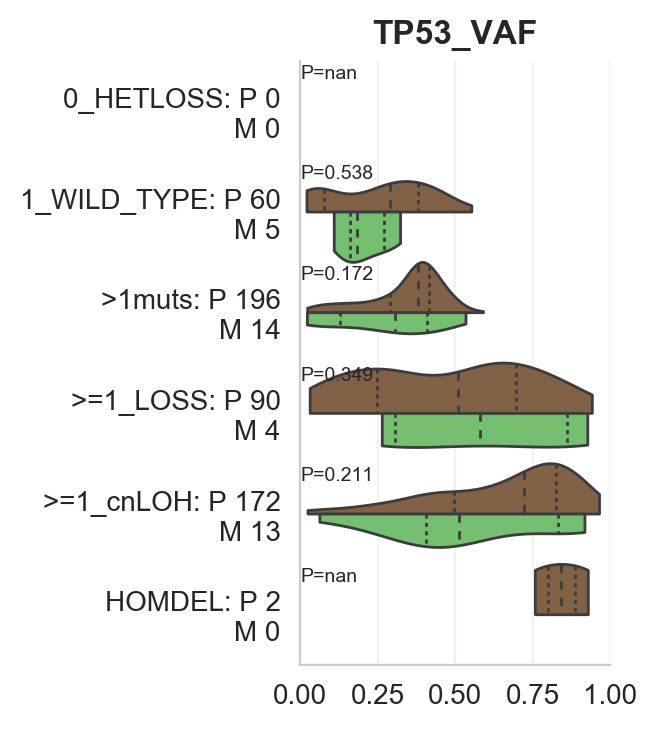

In [28]:
fig = plt.figure(figsize=(2,4))
ax = plt.subplot()


plot_mut_count_subgroups(master_cancer,
                         ax1=ax, 
                         cancer_type=cancer_type, 
                         metrics='tp53_vaf',
                         title='TP53_VAF',  
                         xlim=1, 
                         met_prim = None,
                         continuous=True,
                         tp53_metrics=True,
                         linewidth=1,
                         width=1,
                         hue=True)

In [4]:
master = load_clean_up_master(data_path + 'merged_data/master_file.pkl')